In [1]:
import numpy as np
import qnm
import bilby
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def shift_model(time, ts, tau, tau_q, fo, f_q, phi, phi_q, A, Aq, t0, **kwargs):
    
    """ 
    
    quantum shift (not fractional)
    
    
    """
    
    plus = np.zeros(len(time))
    cross = np.zeros(len(time))
    
    tidxg = time >= t0
    tidxq = time >= ts
    
    GR_part = A*np.exp(-(time[tidxg]-t0)/tau)*np.exp(1j*((time[tidxg]-t0)*2*np.pi*fo) + phi)
    
    
    plus[tidxg] += GR_part.real 
    
    plus[tidxq] += Q_part.real
    
    return {'plus': plus, 'cross': cross}

In [3]:
def frac_shift_1(time, frac_dw, frac_dtau, dphi, A, w, ts, phi, tau, **kwargs):
    
    """ 
    
    fractional shift: 1 Q mode 
    
    frac_dw, frac_dtau are defined as dw/w (or dtau/tau)
    ts is Q mode start time, phi is phase, w is angular freq., tau is damping time (assumed negative)
        
    outputs plus and cross polarizations as dictionary
    
    get Q values from create_bru_dict function
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
     
    omegar_term = w * (frac_dw) #q_w/w
    time_term_q = (time[tidq] - ts)
    phi_term = phi + dphi
    tau_term = tau * (frac_dtau)
    
    wave[tidq] = A * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    
    return {'plus': wave.real, 'cross': wave.imag}

In [4]:
def frac_shift_2(time, frac_dw, frac_dtau, frac_amp, dphi, A, t0, w, ts, phi, tau, **kwargs):
    
    """ 
    
    fractional shift: superposition of 1 GR mode and 1 Q mode 
    
    get Q values from create_bru_dict function 
    
    get GR values from qnm package
    
    """
    
    wave = np.zeros(len(time), np.complex128)
    
    tidq = time >= ts
    tidg = time >= t0
    
    amplitude = A
    omegar_term = w * (frac_dw)
    time_term_q = (time[tidq] - ts)
    time_term_g = (time[tidg] - t0)
    phi_term = phi + dphi
    tau_term = tau * (frac_dtau)
    
    wave[tidq] += frac_amp * amplitude * np.exp(1j*(omegar_term*time_term_q)) * np.exp(1j*(phi_term)) * np.exp(time_term_q/(tau*frac_dtau))
    wave[tidg] += amplitude * np.exp(1j*(w*time_term_g)) * np.exp(1j*(phi)) * np.exp(time_term_g/(tau))
    
    return {'plus': wave.real, 'cross': wave.imag}

In [5]:
def create_bru_values(m_odd, em, M, a, n_ref, A):
    
    """ 
    m_odd is odd integer, g_s is string coupling (GR == 1), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns dictionary: amplitude (quantum, g_s version), omega_real, tau, ts, freq
    outputs tau as a negative number
    
    a refractive index of 1 implies no leakage, AND does not work in this limit (n ~ 1/g_s)
    only the subrelativistic (slow) modes can escape (n>>1) based on boundary conditions 
    (the boundary conditions being the fact that this is a BH copycat)
        
    something to consider is that g_s cannot 0 (which it is in GR) in this model, otherwise there will be 
    no leakage or coupling to outside the "event horizon," which allows stuff to escape
        
    From previous work we can constrain g_s^2 to, at max, be 0.6, which is corresponds to n=1.2
    (this n won't work for this approximation anyway, because the modes close to n = 1 will not 
    escape)
        
    So: pick a g_s that is small but not too small! Strings gotta couple at least for stringy deviations, 
    so n can't be very big 
    
    Also, larger n will result in lower frequency: we can't go too low! LIGO gets real noisy
    if f is too low
        higher mass systems will also be low in frequency, so it's a balancing act
    
        
         
    """
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    g_s = 1/n_ref
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m, kerr+ radius 
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    ts = 1/omega_real 
    
    
    print("Q freq is {}".format(omega_real/(2*np.pi)))
    #print("Q tau is {}".format(tau))
    
    return {'omega_real_Q': omega_real,
            'tau_Q': tau, 'ts_Q': ts}

In [6]:
def create_GR_values(s, l, m, n, a, M):

    """
    grabs GR values to compare to quantum values
    assumes M in units Msun
    converts from 1/m --> 1/s for angular frequency using GR conversion
    
    returns dictionary of GR tau and GR real omega
    outputs tau as a negative number
    
    """
    
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    conversion_w = (c**3)/(G * M * Msun)
    
    grav = qnm.modes_cache(s=s,l=l,m=m,n=n)
    omega_GR, _, _ = grav(a=a)
    
    omega_real_GR = omega_GR.real * conversion_w
    omega_im_GR = omega_GR.imag * conversion_w
    tau_GR = 1/omega_im_GR
    
    print("GR freq is {}".format(omega_real_GR/(2*np.pi)))
    #print("GR tau is {}".format(tau_GR))
    
    return {'tau_GR': tau_GR, 'omega_real_GR': omega_real_GR}

In [7]:
def calc_fracs(tau_GR, tau_Q, omega_real_GR, omega_real_Q, **kwargs):
    
    w = omega_real_GR
    w_q = omega_real_Q
    #dw = w - w_q
    frac_dw = w_q/w
    
    print('frac_dw is {}'.format(frac_dw))
    tau = tau_GR
    tau_q = tau_Q
    #dtau = np.abs(tau-tau_q)
    frac_dtau = tau_q/tau
    
    return {'frac_dtau': frac_dtau, 'frac_dw': frac_dw}

In [8]:
def main(s, l, m, n, a, t0, n_ref, A, frac_amp, Mass_list, outdir):
    
    
    df = pd.DataFrame(columns={'frac_dw','w','H1_SNR','frac_dtau','tau','L1_SNR', 'log_bayes_factor'}, 
                      index=Mass_list)
    
    for value in Mass_list:
        
        #create GR/bru values
        GR_values = create_GR_values(s, l , m, n, a, value) #(s, l, m, n, a, M)
        Q_values = create_bru_values(1, 2, value, a, n_ref, A) #(m_odd, em, M, a, n_ref, A)
        
    
        #create fractional shifts
        fracs = calc_fracs(tau_GR=GR_values['tau_GR'], tau_Q=Q_values['tau_Q'], 
                           omega_real_GR=GR_values['omega_real_GR'], 
                           omega_real_Q=Q_values['omega_real_Q'])
        
        injection_parameters = dict(frac_dw=fracs['frac_dw'], frac_dtau=fracs['frac_dtau'], 
                            dphi=0, A=A, w=GR_values['omega_real_GR'], t0=0, phi=0, 
                            tau=GR_values['tau_GR'], geocent_time=0, frac_amp=frac_amp, ra=0, dec=0, psi=0, 
                            ts=Q_values['ts_Q'])
        
        print(injection_parameters)
        waveform = bilby.gw.waveform_generator.WaveformGenerator(
                    duration=1, sampling_frequency=4096,
                    time_domain_source_model=frac_shift_1,
                    start_time=injection_parameters['geocent_time'])
        
        #plot waveform for sanity check
        times = waveform.time_array
        wave = frac_shift_2(times, **injection_parameters)['plus']
        plt.plot(times, wave, label=value)
        plt.xlim(0,0.01)
        plt.xlabel('time (s)')
        plt.ylabel('amp')
        plt.legend()
        plt.show()
        
        ifos = bilby.gw.detector.InterferometerList(['H1', 'L1'])
        ifos.set_strain_data_from_power_spectral_densities(
            sampling_frequency=4096, duration=1,
            start_time=injection_parameters['geocent_time'])
        
        ifos.inject_signal(waveform_generator=waveform, parameters=injection_parameters)
        
        #create priors
        prior = injection_parameters.copy()
        prior['frac_dtau'] = bilby.core.prior.Uniform(0, 20, r'$d\tau/\tau}$')
        prior['frac_dw'] = bilby.core.prior.Uniform(0, 1, r'$d\omega/\omega$')
        
        #create likelihood
        likelihood = bilby.gw.GravitationalWaveTransient(
                    interferometers=ifos, waveform_generator=waveform)
        
        result = bilby.run_sampler(
            likelihood=likelihood, priors=prior, sampler='dynesty', npoints=500, walks=10, 
            nact=5, injection_parameters=injection_parameters, outdir=outdir, 
            label='mass{}_220_{}_{}_2mode_frac{}'.format(value, n_ref, A, frac_amp), resume=False)
        
        df.loc[value] = {'frac_dw': injection_parameters['frac_dw'],
                         'w':injection_parameters['w'],
                         'H1_SNR': ifos.meta_data['H1']['optimal_SNR'],
                         'L1_SNR': ifos.meta_data['L1']['optimal_SNR'],
                         'frac_dtau': injection_parameters['frac_dtau'],
                         'tau': injection_parameters['tau'],
                         'log_bayes_factor': result.log_bayes_factor}
        
        result.plot_corner(save=True)
    
    return df

GR freq is 862.5705847051892
Q freq is 141.33204892759247
frac_dw is 0.1638498360988013
{'frac_dw': 0.1638498360988013, 'frac_dtau': 13.088445449266699, 'dphi': 0, 'A': 9e-22, 'w': 5419.690824224949, 't0': 0, 'phi': 0, 'tau': -0.0012163366581207057, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.0011261065292659414}


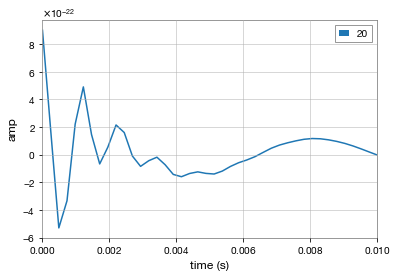

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
14:58 bilby INFO    : Injected signal in H1:
14:58 bilby INFO    :   optimal SNR = 14.11
14:58 bilby INFO    :   matched filter SNR = 14.42-0.21j
14:58 bilby INFO    :   frac_dw = 0.1638498360988013
14:58 bilby INFO    :   frac_dtau = 13.088445449266699
14:58 bilby INFO    :   dphi = 0
14:58 bilby INFO    :   A = 9e-22
14:58 bilby INFO    :   w = 5419.690824224949
14:58 bilby INFO    :   t0 = 0
14:58 bilby INFO    :   phi = 0
14:58 bilby INFO    :   tau = -0.0012163366581207057
14:58 bilby INFO    :   geocent_time = 0
14:58 bilby INFO    :   frac_amp = 0.2
14:58 bilby INFO    :   ra = 0
14:58 bilby INFO    :   dec = 0
14:58 bilby INFO    :   psi = 0
14:58 bilby INFO    :   ts = 0.0011261065292659414
14:58 bilby INFO    : Injected s


0it [00:00, ?it/s]

14:58 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x13a8b06d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
14:58 bilby INFO    : Checkpoint every n_check_point = 400000
14:58 bilby INFO    : Using dynesty version 1.0.1
14:58 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:00,  1.14it/s, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-440.74+/-0.17 dlogz:inf>0.10]
71it [00:00,  1.63it/s, bound:0 nc:2 ncall:581 eff:12.2% logz-ratio=-309.55+/-0.15 dlogz:559.411>0.10]
145it [00:01,  2.33it/s, bound:0 nc:2 ncall:662 eff:21.9% logz-ratio=-260.32+/-0.14 dlogz:510.103>0.10]
199it [00:01,  3.32it/s, bound:0 nc:2 ncall:748 eff:26.6% logz-ratio=-222.67+/-0.15 dlogz:472.043>0.10]
252it [00:01,  4.73it/s, bound:0 nc:1 ncall:832 eff:30.3% logz-ratio=-196.96+/-0.14 dlogz:446.193>0.10]
297it [00:01,  6.73it/s, bound:0 nc:3 ncall:918 eff:32.4% logz-ratio=-179.09+/-0.15 dlogz:431.195>0.10]
345it [00:01,  9.55it/s, bound:0 nc:3 ncall:1003 eff:34.4% logz-ratio=-157.84+/-0.15 dlogz:410.004>0.10]
391it [00:01, 13.49it/s, bound:0 nc:3 ncall:1111 eff:35.2% logz-ratio=-141.52+/-0.15 dlogz:394.154>0.10]
434it [00:01, 19.00it/s, bound:0 nc:2 ncall:1204 eff:36.0% logz-ratio=-128.64+/-0.14 dlogz:380.959>0.10]
476it [00:01, 26.44it/s, bound:0 nc:4 ncall:1324 eff:36.0% logz-rati

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/likelihood.py:192: RuntimeWarning: invalid value encountered in cdouble_scalars
  complex_matched_filter_snr = d_inner_h / (optimal_snr_squared**0.5)



1088it [00:05, 92.45it/s, bound:0 nc:12 ncall:4609 eff:23.6% logz-ratio=-12.15+/-0.14 dlogz:263.020>0.10]
1099it [00:05, 86.33it/s, bound:0 nc:2 ncall:4740 eff:23.2% logz-ratio=-11.12+/-0.14 dlogz:261.953>0.10] 
1114it [00:05, 98.45it/s, bound:0 nc:5 ncall:4831 eff:23.1% logz-ratio=-9.71+/-0.14 dlogz:260.547>0.10] 
1126it [00:06, 80.86it/s, bound:0 nc:15 ncall:5018 eff:22.4% logz-ratio=-7.80+/-0.15 dlogz:258.620>0.10]
1143it [00:06, 94.95it/s, bound:0 nc:6 ncall:5111 eff:22.4% logz-ratio=-5.75+/-0.15 dlogz:256.482>0.10] 
1155it [00:06, 98.95it/s, bound:0 nc:8 ncall:5208 eff:22.2% logz-ratio=-4.93+/-0.14 dlogz:255.626>0.10]
1167it [00:06, 86.71it/s, bound:0 nc:2 ncall:5365 eff:21.8% logz-ratio=-4.28+/-0.14 dlogz:254.934>0.10]
1177it [00:06, 85.39it/s, bound:0 nc:3 ncall:5472 eff:21.5% logz-ratio=-3.82+/-0.14 dlogz:254.448>0.10]
1187it [00:06, 77.90it/s, bound:0 nc:3 ncall:5606 eff:21.2% logz-ratio=-3.29+/-0.14 dlogz:253.912>0.10]
1196it [00:06, 76.58it/s, bound:0 nc:18 ncall:5714 eff:2

1587it [00:16, 26.59it/s, bound:0 nc:209 ncall:13677 eff:11.6% logz-ratio=55.00+/-0.17 dlogz:196.798>0.10]
1591it [00:16, 27.64it/s, bound:0 nc:21 ncall:13795 eff:11.5% logz-ratio=55.83+/-0.17 dlogz:195.953>0.10] 
1596it [00:16, 29.74it/s, bound:0 nc:38 ncall:13919 eff:11.5% logz-ratio=57.00+/-0.17 dlogz:194.775>0.10]
1600it [00:16, 30.94it/s, bound:0 nc:1 ncall:14026 eff:11.4% logz-ratio=57.86+/-0.17 dlogz:193.884>0.10] 
1604it [00:16, 32.21it/s, bound:0 nc:20 ncall:14122 eff:11.4% logz-ratio=58.65+/-0.17 dlogz:193.078>0.10]
1611it [00:16, 37.36it/s, bound:0 nc:24 ncall:14225 eff:11.3% logz-ratio=60.37+/-0.17 dlogz:191.477>0.10]
1616it [00:16, 37.03it/s, bound:0 nc:43 ncall:14350 eff:11.3% logz-ratio=61.52+/-0.17 dlogz:190.156>0.10]
1621it [00:17, 32.33it/s, bound:0 nc:69 ncall:14534 eff:11.2% logz-ratio=62.25+/-0.16 dlogz:189.413>0.10]
1626it [00:17, 35.74it/s, bound:0 nc:10 ncall:14628 eff:11.1% logz-ratio=63.21+/-0.17 dlogz:188.529>0.10]
1630it [00:17, 31.63it/s, bound:0 nc:47 ncal

1854it [00:26, 22.04it/s, bound:18 nc:39 ncall:22467 eff:8.3% logz-ratio=118.37+/-0.17 dlogz:132.994>0.10]
1857it [00:26, 22.35it/s, bound:18 nc:35 ncall:22576 eff:8.2% logz-ratio=119.05+/-0.17 dlogz:132.247>0.10]
1860it [00:26, 22.94it/s, bound:18 nc:24 ncall:22677 eff:8.2% logz-ratio=119.70+/-0.17 dlogz:131.671>0.10]
1863it [00:26, 22.43it/s, bound:19 nc:35 ncall:22792 eff:8.2% logz-ratio=120.42+/-0.17 dlogz:130.871>0.10]
1866it [00:26, 22.58it/s, bound:19 nc:36 ncall:22902 eff:8.1% logz-ratio=120.99+/-0.17 dlogz:130.274>0.10]
1869it [00:27, 22.89it/s, bound:19 nc:37 ncall:23006 eff:8.1% logz-ratio=121.75+/-0.17 dlogz:129.600>0.10]
1872it [00:27, 22.75it/s, bound:20 nc:37 ncall:23115 eff:8.1% logz-ratio=122.58+/-0.17 dlogz:128.746>0.10]
1875it [00:27, 22.32it/s, bound:20 nc:41 ncall:23232 eff:8.1% logz-ratio=123.22+/-0.17 dlogz:128.045>0.10]
1878it [00:27, 22.73it/s, bound:20 nc:36 ncall:23336 eff:8.0% logz-ratio=123.80+/-0.17 dlogz:127.466>0.10]
1881it [00:27, 22.14it/s, bound:21 nc

2068it [00:36, 20.52it/s, bound:43 nc:38 ncall:30684 eff:6.7% logz-ratio=159.05+/-0.17 dlogz:91.765>0.10]
2071it [00:36, 20.81it/s, bound:43 nc:35 ncall:30798 eff:6.7% logz-ratio=159.51+/-0.17 dlogz:91.337>0.10]
2074it [00:36, 20.69it/s, bound:44 nc:40 ncall:30919 eff:6.7% logz-ratio=160.00+/-0.17 dlogz:90.818>0.10]
2077it [00:37, 20.18it/s, bound:44 nc:46 ncall:31052 eff:6.7% logz-ratio=160.51+/-0.17 dlogz:90.371>0.10]
2080it [00:37, 19.90it/s, bound:44 nc:42 ncall:31174 eff:6.7% logz-ratio=161.13+/-0.18 dlogz:89.701>0.10]
2082it [00:37, 19.14it/s, bound:45 nc:37 ncall:31239 eff:6.7% logz-ratio=161.43+/-0.17 dlogz:89.365>0.10]
2084it [00:37, 18.30it/s, bound:45 nc:37 ncall:31317 eff:6.7% logz-ratio=161.69+/-0.17 dlogz:89.083>0.10]
2086it [00:37, 18.35it/s, bound:45 nc:33 ncall:31387 eff:6.6% logz-ratio=161.96+/-0.17 dlogz:88.815>0.10]
2088it [00:37, 18.54it/s, bound:45 nc:37 ncall:31459 eff:6.6% logz-ratio=162.22+/-0.17 dlogz:88.544>0.10]
2090it [00:37, 18.79it/s, bound:46 nc:41 ncall

2265it [00:46, 20.11it/s, bound:68 nc:38 ncall:38764 eff:5.8% logz-ratio=191.26+/-0.17 dlogz:59.146>0.10]
2268it [00:46, 20.13it/s, bound:68 nc:43 ncall:38888 eff:5.8% logz-ratio=191.57+/-0.17 dlogz:58.807>0.10]
2271it [00:46, 19.81it/s, bound:69 nc:39 ncall:39015 eff:5.8% logz-ratio=191.82+/-0.17 dlogz:58.532>0.10]
2273it [00:46, 19.62it/s, bound:69 nc:44 ncall:39102 eff:5.8% logz-ratio=191.99+/-0.17 dlogz:58.365>0.10]
2275it [00:47, 19.21it/s, bound:69 nc:46 ncall:39192 eff:5.8% logz-ratio=192.16+/-0.17 dlogz:58.192>0.10]
2277it [00:47, 19.20it/s, bound:69 nc:44 ncall:39276 eff:5.8% logz-ratio=192.32+/-0.17 dlogz:58.023>0.10]
2280it [00:47, 19.78it/s, bound:70 nc:37 ncall:39391 eff:5.8% logz-ratio=192.54+/-0.17 dlogz:57.790>0.10]
2282it [00:47, 19.38it/s, bound:70 nc:43 ncall:39480 eff:5.8% logz-ratio=192.69+/-0.17 dlogz:57.635>0.10]
2285it [00:47, 19.67it/s, bound:70 nc:39 ncall:39599 eff:5.8% logz-ratio=192.91+/-0.17 dlogz:57.409>0.10]
2287it [00:47, 18.02it/s, bound:71 nc:46 ncall

2436it [00:55, 19.40it/s, bound:90 nc:43 ncall:46041 eff:5.3% logz-ratio=208.08+/-0.17 dlogz:41.931>0.10]
2438it [00:55, 19.51it/s, bound:91 nc:45 ncall:46123 eff:5.3% logz-ratio=208.22+/-0.17 dlogz:41.786>0.10]
2440it [00:55, 19.37it/s, bound:91 nc:40 ncall:46210 eff:5.3% logz-ratio=208.38+/-0.17 dlogz:41.640>0.10]
2442it [00:55, 19.48it/s, bound:91 nc:40 ncall:46294 eff:5.3% logz-ratio=208.55+/-0.17 dlogz:41.469>0.10]
2445it [00:55, 19.91it/s, bound:91 nc:36 ncall:46411 eff:5.3% logz-ratio=208.78+/-0.17 dlogz:41.222>0.10]
2447it [00:56, 19.62it/s, bound:92 nc:46 ncall:46498 eff:5.3% logz-ratio=208.91+/-0.17 dlogz:41.077>0.10]
2450it [00:56, 19.78it/s, bound:92 nc:45 ncall:46622 eff:5.3% logz-ratio=209.13+/-0.17 dlogz:40.862>0.10]
2452it [00:56, 18.58it/s, bound:92 nc:41 ncall:46711 eff:5.2% logz-ratio=209.28+/-0.17 dlogz:40.710>0.10]
2454it [00:56, 17.50it/s, bound:93 nc:34 ncall:46790 eff:5.2% logz-ratio=209.43+/-0.17 dlogz:40.556>0.10]
2456it [00:56, 17.08it/s, bound:93 nc:42 ncall

2599it [01:04, 18.67it/s, bound:112 nc:41 ncall:53051 eff:4.9% logz-ratio=218.20+/-0.17 dlogz:31.529>0.10]
2601it [01:04, 18.69it/s, bound:113 nc:37 ncall:53135 eff:4.9% logz-ratio=218.32+/-0.17 dlogz:31.395>0.10]
2603it [01:04, 18.71it/s, bound:113 nc:43 ncall:53220 eff:4.9% logz-ratio=218.46+/-0.17 dlogz:31.258>0.10]
2606it [01:04, 19.07it/s, bound:113 nc:49 ncall:53347 eff:4.9% logz-ratio=218.67+/-0.17 dlogz:31.046>0.10]
2608it [01:04, 18.71it/s, bound:114 nc:44 ncall:53440 eff:4.9% logz-ratio=218.80+/-0.17 dlogz:30.903>0.10]
2610it [01:04, 18.72it/s, bound:114 nc:44 ncall:53529 eff:4.9% logz-ratio=218.93+/-0.17 dlogz:30.770>0.10]
2612it [01:04, 19.08it/s, bound:114 nc:39 ncall:53613 eff:4.9% logz-ratio=219.05+/-0.17 dlogz:30.642>0.10]
2614it [01:05, 19.18it/s, bound:114 nc:45 ncall:53700 eff:4.9% logz-ratio=219.16+/-0.17 dlogz:30.523>0.10]
2616it [01:05, 19.25it/s, bound:115 nc:41 ncall:53784 eff:4.9% logz-ratio=219.26+/-0.17 dlogz:30.414>0.10]
2619it [01:05, 19.57it/s, bound:115 n

2758it [01:12, 18.43it/s, bound:134 nc:46 ncall:59976 eff:4.6% logz-ratio=225.71+/-0.17 dlogz:23.670>0.10]
2760it [01:12, 18.32it/s, bound:135 nc:46 ncall:60068 eff:4.6% logz-ratio=225.78+/-0.17 dlogz:23.592>0.10]
2762it [01:12, 18.30it/s, bound:135 nc:43 ncall:60156 eff:4.6% logz-ratio=225.86+/-0.17 dlogz:23.513>0.10]
2764it [01:13, 18.45it/s, bound:135 nc:47 ncall:60244 eff:4.6% logz-ratio=225.93+/-0.17 dlogz:23.436>0.10]
2766it [01:13, 18.21it/s, bound:135 nc:51 ncall:60340 eff:4.6% logz-ratio=226.00+/-0.17 dlogz:23.362>0.10]
2768it [01:13, 18.39it/s, bound:136 nc:40 ncall:60425 eff:4.6% logz-ratio=226.06+/-0.17 dlogz:23.291>0.10]
2770it [01:13, 18.46it/s, bound:136 nc:46 ncall:60514 eff:4.6% logz-ratio=226.13+/-0.17 dlogz:23.222>0.10]
2772it [01:13, 18.17it/s, bound:136 nc:47 ncall:60607 eff:4.6% logz-ratio=226.19+/-0.17 dlogz:23.155>0.10]
2774it [01:13, 18.09it/s, bound:137 nc:47 ncall:60700 eff:4.6% logz-ratio=226.25+/-0.17 dlogz:23.090>0.10]
2777it [01:13, 18.91it/s, bound:137 n

2908it [01:21, 16.46it/s, bound:156 nc:43 ncall:66779 eff:4.4% logz-ratio=230.42+/-0.17 dlogz:18.653>0.10]
2910it [01:21, 16.62it/s, bound:156 nc:47 ncall:66877 eff:4.4% logz-ratio=230.49+/-0.17 dlogz:18.581>0.10]
2912it [01:21, 17.43it/s, bound:156 nc:42 ncall:66961 eff:4.3% logz-ratio=230.56+/-0.17 dlogz:18.510>0.10]
2914it [01:22, 17.34it/s, bound:156 nc:41 ncall:67054 eff:4.3% logz-ratio=230.62+/-0.17 dlogz:18.439>0.10]
2916it [01:22, 17.04it/s, bound:157 nc:41 ncall:67141 eff:4.3% logz-ratio=230.68+/-0.17 dlogz:18.371>0.10]
2918it [01:22, 15.72it/s, bound:157 nc:45 ncall:67233 eff:4.3% logz-ratio=230.75+/-0.17 dlogz:18.305>0.10]
2920it [01:22, 15.79it/s, bound:157 nc:51 ncall:67332 eff:4.3% logz-ratio=230.81+/-0.17 dlogz:18.238>0.10]
2922it [01:22, 16.21it/s, bound:158 nc:45 ncall:67430 eff:4.3% logz-ratio=230.87+/-0.17 dlogz:18.172>0.10]
2924it [01:22, 16.72it/s, bound:158 nc:47 ncall:67523 eff:4.3% logz-ratio=230.93+/-0.17 dlogz:18.109>0.10]
2926it [01:22, 16.71it/s, bound:158 n

3056it [01:30, 17.82it/s, bound:177 nc:41 ncall:73753 eff:4.1% logz-ratio=234.07+/-0.17 dlogz:14.691>0.10]
3058it [01:30, 17.60it/s, bound:177 nc:50 ncall:73854 eff:4.1% logz-ratio=234.12+/-0.17 dlogz:14.646>0.10]
3060it [01:30, 17.46it/s, bound:177 nc:51 ncall:73955 eff:4.1% logz-ratio=234.16+/-0.17 dlogz:14.600>0.10]
3062it [01:30, 17.70it/s, bound:178 nc:48 ncall:74048 eff:4.1% logz-ratio=234.20+/-0.17 dlogz:14.556>0.10]
3064it [01:30, 17.86it/s, bound:178 nc:42 ncall:74142 eff:4.1% logz-ratio=234.24+/-0.17 dlogz:14.512>0.10]
3066it [01:31, 17.95it/s, bound:178 nc:46 ncall:74236 eff:4.1% logz-ratio=234.28+/-0.17 dlogz:14.469>0.10]
3068it [01:31, 17.84it/s, bound:178 nc:47 ncall:74333 eff:4.1% logz-ratio=234.31+/-0.17 dlogz:14.426>0.10]
3070it [01:31, 17.84it/s, bound:179 nc:48 ncall:74425 eff:4.1% logz-ratio=234.35+/-0.17 dlogz:14.383>0.10]
3072it [01:31, 17.84it/s, bound:179 nc:48 ncall:74523 eff:4.1% logz-ratio=234.39+/-0.17 dlogz:14.340>0.10]
3074it [01:31, 17.71it/s, bound:179 n

3204it [01:38, 17.20it/s, bound:198 nc:48 ncall:80825 eff:4.0% logz-ratio=236.88+/-0.17 dlogz:11.634>0.10]
3206it [01:38, 17.28it/s, bound:198 nc:50 ncall:80924 eff:4.0% logz-ratio=236.92+/-0.17 dlogz:11.590>0.10]
3208it [01:39, 17.31it/s, bound:198 nc:49 ncall:81022 eff:4.0% logz-ratio=236.96+/-0.17 dlogz:11.546>0.10]
3210it [01:39, 17.06it/s, bound:199 nc:51 ncall:81123 eff:4.0% logz-ratio=237.00+/-0.17 dlogz:11.503>0.10]
3212it [01:39, 17.50it/s, bound:199 nc:44 ncall:81215 eff:4.0% logz-ratio=237.04+/-0.17 dlogz:11.460>0.10]
3214it [01:39, 17.55it/s, bound:199 nc:50 ncall:81312 eff:4.0% logz-ratio=237.07+/-0.17 dlogz:11.418>0.10]
3216it [01:39, 17.30it/s, bound:200 nc:50 ncall:81412 eff:4.0% logz-ratio=237.11+/-0.17 dlogz:11.377>0.10]
3218it [01:39, 17.42it/s, bound:200 nc:48 ncall:81509 eff:3.9% logz-ratio=237.15+/-0.17 dlogz:11.335>0.10]
3220it [01:39, 17.43it/s, bound:200 nc:46 ncall:81606 eff:3.9% logz-ratio=237.19+/-0.17 dlogz:11.294>0.10]
3222it [01:39, 17.13it/s, bound:200 n

3352it [01:47, 16.74it/s, bound:220 nc:49 ncall:88086 eff:3.8% logz-ratio=239.26+/-0.17 dlogz:8.953>0.10]
3354it [01:47, 16.50it/s, bound:220 nc:58 ncall:88193 eff:3.8% logz-ratio=239.28+/-0.17 dlogz:8.924>0.10]
3356it [01:47, 16.19it/s, bound:220 nc:52 ncall:88303 eff:3.8% logz-ratio=239.31+/-0.17 dlogz:8.894>0.10]
3358it [01:47, 16.25it/s, bound:221 nc:48 ncall:88403 eff:3.8% logz-ratio=239.33+/-0.17 dlogz:8.865>0.10]
3360it [01:48, 14.48it/s, bound:221 nc:50 ncall:88502 eff:3.8% logz-ratio=239.36+/-0.17 dlogz:8.834>0.10]
3362it [01:48, 14.25it/s, bound:221 nc:51 ncall:88602 eff:3.8% logz-ratio=239.39+/-0.17 dlogz:8.802>0.10]
3364it [01:48, 14.67it/s, bound:222 nc:50 ncall:88701 eff:3.8% logz-ratio=239.42+/-0.17 dlogz:8.771>0.10]
3366it [01:48, 15.44it/s, bound:222 nc:48 ncall:88796 eff:3.8% logz-ratio=239.45+/-0.17 dlogz:8.739>0.10]
3368it [01:48, 15.81it/s, bound:222 nc:48 ncall:88889 eff:3.8% logz-ratio=239.47+/-0.17 dlogz:8.707>0.10]
3370it [01:48, 16.00it/s, bound:222 nc:50 ncal

3502it [01:56, 16.45it/s, bound:242 nc:48 ncall:95568 eff:3.7% logz-ratio=240.96+/-0.17 dlogz:6.948>0.10]
3504it [01:56, 16.50it/s, bound:243 nc:49 ncall:95667 eff:3.7% logz-ratio=240.98+/-0.17 dlogz:6.923>0.10]
3506it [01:56, 16.35it/s, bound:243 nc:54 ncall:95771 eff:3.7% logz-ratio=241.00+/-0.17 dlogz:6.899>0.10]
3508it [01:57, 16.39it/s, bound:243 nc:51 ncall:95873 eff:3.7% logz-ratio=241.02+/-0.17 dlogz:6.874>0.10]
3510it [01:57, 16.58it/s, bound:244 nc:48 ncall:95968 eff:3.7% logz-ratio=241.04+/-0.17 dlogz:6.850>0.10]
3512it [01:57, 16.83it/s, bound:244 nc:49 ncall:96065 eff:3.7% logz-ratio=241.06+/-0.17 dlogz:6.825>0.10]
3514it [01:57, 16.69it/s, bound:244 nc:52 ncall:96169 eff:3.7% logz-ratio=241.09+/-0.17 dlogz:6.801>0.10]
3516it [01:57, 16.55it/s, bound:245 nc:51 ncall:96273 eff:3.7% logz-ratio=241.11+/-0.17 dlogz:6.776>0.10]
3518it [01:57, 16.51it/s, bound:245 nc:50 ncall:96372 eff:3.7% logz-ratio=241.13+/-0.17 dlogz:6.751>0.10]
3520it [01:57, 16.63it/s, bound:245 nc:50 ncal

3650it [02:05, 16.25it/s, bound:265 nc:51 ncall:103006 eff:3.5% logz-ratio=242.30+/-0.17 dlogz:5.311>0.10]
3652it [02:05, 16.26it/s, bound:266 nc:53 ncall:103108 eff:3.5% logz-ratio=242.32+/-0.17 dlogz:5.291>0.10]
3654it [02:05, 15.96it/s, bound:266 nc:49 ncall:103218 eff:3.5% logz-ratio=242.34+/-0.17 dlogz:5.272>0.10]
3656it [02:06, 16.27it/s, bound:266 nc:50 ncall:103317 eff:3.5% logz-ratio=242.35+/-0.17 dlogz:5.253>0.10]
3658it [02:06, 16.31it/s, bound:267 nc:49 ncall:103417 eff:3.5% logz-ratio=242.37+/-0.17 dlogz:5.234>0.10]
3660it [02:06, 15.51it/s, bound:267 nc:52 ncall:103518 eff:3.5% logz-ratio=242.38+/-0.17 dlogz:5.215>0.10]
3662it [02:06, 14.89it/s, bound:267 nc:50 ncall:103617 eff:3.5% logz-ratio=242.40+/-0.17 dlogz:5.196>0.10]
3664it [02:06, 15.23it/s, bound:268 nc:49 ncall:103719 eff:3.5% logz-ratio=242.41+/-0.17 dlogz:5.178>0.10]
3666it [02:06, 15.44it/s, bound:268 nc:50 ncall:103821 eff:3.5% logz-ratio=242.42+/-0.17 dlogz:5.159>0.10]
3668it [02:06, 15.49it/s, bound:268 n

3798it [02:14, 16.45it/s, bound:289 nc:51 ncall:110441 eff:3.4% logz-ratio=243.30+/-0.17 dlogz:4.029>0.10]
3800it [02:14, 16.42it/s, bound:289 nc:54 ncall:110544 eff:3.4% logz-ratio=243.31+/-0.17 dlogz:4.012>0.10]
3802it [02:15, 16.54it/s, bound:289 nc:51 ncall:110644 eff:3.4% logz-ratio=243.33+/-0.17 dlogz:3.996>0.10]
3804it [02:15, 16.52it/s, bound:290 nc:49 ncall:110744 eff:3.4% logz-ratio=243.34+/-0.17 dlogz:3.980>0.10]
3806it [02:15, 16.48it/s, bound:290 nc:50 ncall:110844 eff:3.4% logz-ratio=243.35+/-0.17 dlogz:3.964>0.10]
3808it [02:15, 16.45it/s, bound:290 nc:49 ncall:110946 eff:3.4% logz-ratio=243.36+/-0.17 dlogz:3.948>0.10]
3810it [02:15, 16.30it/s, bound:291 nc:49 ncall:111047 eff:3.4% logz-ratio=243.38+/-0.17 dlogz:3.932>0.10]
3812it [02:15, 16.45it/s, bound:291 nc:49 ncall:111146 eff:3.4% logz-ratio=243.39+/-0.17 dlogz:3.917>0.10]
3814it [02:15, 16.49it/s, bound:291 nc:52 ncall:111248 eff:3.4% logz-ratio=243.40+/-0.18 dlogz:3.901>0.10]
3816it [02:15, 15.31it/s, bound:292 n

3946it [02:23, 16.79it/s, bound:312 nc:49 ncall:117901 eff:3.3% logz-ratio=244.06+/-0.18 dlogz:3.008>0.10]
3948it [02:23, 16.44it/s, bound:313 nc:54 ncall:118007 eff:3.3% logz-ratio=244.07+/-0.18 dlogz:2.996>0.10]
3950it [02:24, 16.65it/s, bound:313 nc:49 ncall:118105 eff:3.3% logz-ratio=244.08+/-0.18 dlogz:2.984>0.10]
3952it [02:24, 16.32it/s, bound:313 nc:54 ncall:118213 eff:3.3% logz-ratio=244.09+/-0.18 dlogz:2.972>0.10]
3954it [02:24, 16.35it/s, bound:314 nc:49 ncall:118312 eff:3.3% logz-ratio=244.10+/-0.18 dlogz:2.960>0.10]
3956it [02:24, 16.53it/s, bound:314 nc:49 ncall:118412 eff:3.3% logz-ratio=244.11+/-0.18 dlogz:2.949>0.10]
3958it [02:24, 16.50it/s, bound:314 nc:52 ncall:118514 eff:3.3% logz-ratio=244.11+/-0.18 dlogz:2.937>0.10]
3960it [02:24, 16.59it/s, bound:315 nc:49 ncall:118613 eff:3.3% logz-ratio=244.12+/-0.18 dlogz:2.925>0.10]
3962it [02:24, 16.64it/s, bound:315 nc:50 ncall:118713 eff:3.3% logz-ratio=244.13+/-0.18 dlogz:2.913>0.10]
3964it [02:24, 16.72it/s, bound:315 n

4094it [02:32, 16.75it/s, bound:335 nc:51 ncall:125321 eff:3.3% logz-ratio=244.61+/-0.17 dlogz:2.227>0.10]
4096it [02:32, 16.70it/s, bound:336 nc:49 ncall:125422 eff:3.3% logz-ratio=244.62+/-0.17 dlogz:2.218>0.10]
4098it [02:32, 16.71it/s, bound:336 nc:49 ncall:125522 eff:3.3% logz-ratio=244.63+/-0.17 dlogz:2.209>0.10]
4100it [02:33, 16.77it/s, bound:336 nc:51 ncall:125622 eff:3.3% logz-ratio=244.63+/-0.17 dlogz:2.199>0.10]
4102it [02:33, 16.01it/s, bound:337 nc:52 ncall:125738 eff:3.3% logz-ratio=244.64+/-0.17 dlogz:2.190>0.10]
4104it [02:33, 16.24it/s, bound:337 nc:49 ncall:125838 eff:3.3% logz-ratio=244.65+/-0.17 dlogz:2.181>0.10]
4106it [02:33, 16.10it/s, bound:337 nc:50 ncall:125942 eff:3.3% logz-ratio=244.65+/-0.17 dlogz:2.172>0.10]
4108it [02:33, 16.24it/s, bound:338 nc:49 ncall:126042 eff:3.3% logz-ratio=244.66+/-0.17 dlogz:2.162>0.10]
4110it [02:33, 16.51it/s, bound:338 nc:49 ncall:126140 eff:3.3% logz-ratio=244.66+/-0.17 dlogz:2.153>0.10]
4112it [02:33, 16.69it/s, bound:338 n

4242it [02:41, 16.45it/s, bound:359 nc:50 ncall:132771 eff:3.2% logz-ratio=245.03+/-0.18 dlogz:1.617>0.10]
4244it [02:41, 16.50it/s, bound:359 nc:53 ncall:132873 eff:3.2% logz-ratio=245.04+/-0.18 dlogz:1.610>0.10]
4246it [02:41, 16.67it/s, bound:360 nc:49 ncall:132971 eff:3.2% logz-ratio=245.04+/-0.18 dlogz:1.602>0.10]
4248it [02:41, 16.55it/s, bound:360 nc:53 ncall:133075 eff:3.2% logz-ratio=245.05+/-0.18 dlogz:1.595>0.10]
4250it [02:42, 16.45it/s, bound:360 nc:49 ncall:133174 eff:3.2% logz-ratio=245.05+/-0.18 dlogz:1.588>0.10]
4252it [02:42, 16.00it/s, bound:361 nc:49 ncall:133273 eff:3.2% logz-ratio=245.06+/-0.18 dlogz:1.581>0.10]
4254it [02:42, 15.82it/s, bound:361 nc:52 ncall:133376 eff:3.2% logz-ratio=245.06+/-0.18 dlogz:1.574>0.10]
4256it [02:42, 15.99it/s, bound:361 nc:49 ncall:133474 eff:3.2% logz-ratio=245.07+/-0.18 dlogz:1.567>0.10]
4258it [02:42, 16.21it/s, bound:362 nc:50 ncall:133574 eff:3.2% logz-ratio=245.07+/-0.18 dlogz:1.560>0.10]
4260it [02:42, 16.39it/s, bound:362 n

4390it [02:50, 16.85it/s, bound:382 nc:49 ncall:140221 eff:3.1% logz-ratio=245.35+/-0.18 dlogz:1.157>0.10]
4392it [02:50, 16.74it/s, bound:382 nc:52 ncall:140324 eff:3.1% logz-ratio=245.36+/-0.18 dlogz:1.152>0.10]
4394it [02:50, 16.77it/s, bound:383 nc:49 ncall:140423 eff:3.1% logz-ratio=245.36+/-0.18 dlogz:1.146>0.10]
4396it [02:50, 16.73it/s, bound:383 nc:49 ncall:140521 eff:3.1% logz-ratio=245.37+/-0.18 dlogz:1.141>0.10]
4398it [02:51, 16.37it/s, bound:383 nc:55 ncall:140625 eff:3.1% logz-ratio=245.37+/-0.18 dlogz:1.136>0.10]
4400it [02:51, 16.29it/s, bound:384 nc:52 ncall:140727 eff:3.1% logz-ratio=245.37+/-0.18 dlogz:1.131>0.10]
4402it [02:51, 16.50it/s, bound:384 nc:50 ncall:140826 eff:3.1% logz-ratio=245.38+/-0.18 dlogz:1.125>0.10]
4404it [02:51, 16.41it/s, bound:384 nc:51 ncall:140931 eff:3.1% logz-ratio=245.38+/-0.18 dlogz:1.120>0.10]
4406it [02:51, 16.39it/s, bound:385 nc:52 ncall:141033 eff:3.1% logz-ratio=245.38+/-0.18 dlogz:1.115>0.10]
4408it [02:51, 16.61it/s, bound:385 n

4538it [02:59, 16.35it/s, bound:406 nc:51 ncall:147696 eff:3.1% logz-ratio=245.59+/-0.18 dlogz:0.823>0.10]
4540it [02:59, 16.46it/s, bound:406 nc:51 ncall:147797 eff:3.1% logz-ratio=245.60+/-0.18 dlogz:0.819>0.10]
4542it [02:59, 16.50it/s, bound:407 nc:49 ncall:147895 eff:3.1% logz-ratio=245.60+/-0.18 dlogz:0.815>0.10]
4544it [02:59, 16.47it/s, bound:407 nc:50 ncall:147994 eff:3.1% logz-ratio=245.60+/-0.18 dlogz:0.811>0.10]
4546it [02:59, 16.59it/s, bound:407 nc:49 ncall:148092 eff:3.1% logz-ratio=245.60+/-0.18 dlogz:0.808>0.10]
4548it [03:00, 16.06it/s, bound:408 nc:54 ncall:148201 eff:3.1% logz-ratio=245.61+/-0.18 dlogz:0.804>0.10]
4550it [03:00, 15.90it/s, bound:408 nc:52 ncall:148305 eff:3.1% logz-ratio=245.61+/-0.18 dlogz:0.800>0.10]
4552it [03:00, 14.50it/s, bound:408 nc:49 ncall:148404 eff:3.1% logz-ratio=245.61+/-0.18 dlogz:0.797>0.10]
4554it [03:00, 14.13it/s, bound:409 nc:49 ncall:148505 eff:3.1% logz-ratio=245.62+/-0.18 dlogz:0.793>0.10]
4556it [03:00, 14.26it/s, bound:409 n

4686it [03:08, 16.72it/s, bound:429 nc:49 ncall:155143 eff:3.0% logz-ratio=245.77+/-0.18 dlogz:0.587>0.10]
4688it [03:08, 16.75it/s, bound:430 nc:49 ncall:155241 eff:3.0% logz-ratio=245.77+/-0.18 dlogz:0.584>0.10]
4690it [03:09, 16.99it/s, bound:430 nc:49 ncall:155336 eff:3.0% logz-ratio=245.77+/-0.18 dlogz:0.581>0.10]
4692it [03:09, 16.96it/s, bound:430 nc:49 ncall:155435 eff:3.0% logz-ratio=245.77+/-0.18 dlogz:0.579>0.10]
4694it [03:09, 16.93it/s, bound:430 nc:51 ncall:155535 eff:3.0% logz-ratio=245.78+/-0.18 dlogz:0.576>0.10]
4696it [03:09, 16.83it/s, bound:431 nc:51 ncall:155635 eff:3.0% logz-ratio=245.78+/-0.18 dlogz:0.574>0.10]
4698it [03:09, 16.65it/s, bound:431 nc:52 ncall:155736 eff:3.0% logz-ratio=245.78+/-0.18 dlogz:0.571>0.10]
4700it [03:09, 16.63it/s, bound:431 nc:49 ncall:155836 eff:3.0% logz-ratio=245.78+/-0.18 dlogz:0.568>0.10]
4702it [03:09, 16.60it/s, bound:432 nc:49 ncall:155935 eff:3.0% logz-ratio=245.78+/-0.18 dlogz:0.566>0.10]
4704it [03:09, 16.67it/s, bound:432 n

4834it [03:18, 16.31it/s, bound:452 nc:53 ncall:162561 eff:3.0% logz-ratio=245.89+/-0.18 dlogz:0.420>0.10]
4836it [03:18, 16.01it/s, bound:453 nc:57 ncall:162669 eff:3.0% logz-ratio=245.90+/-0.18 dlogz:0.418>0.10]
4838it [03:18, 16.02it/s, bound:453 nc:51 ncall:162770 eff:3.0% logz-ratio=245.90+/-0.18 dlogz:0.417>0.10]
4840it [03:18, 16.25it/s, bound:453 nc:49 ncall:162870 eff:3.0% logz-ratio=245.90+/-0.18 dlogz:0.415>0.10]
4842it [03:18, 16.21it/s, bound:454 nc:50 ncall:162972 eff:3.0% logz-ratio=245.90+/-0.18 dlogz:0.413>0.10]
4844it [03:18, 16.41it/s, bound:454 nc:49 ncall:163070 eff:3.0% logz-ratio=245.90+/-0.18 dlogz:0.411>0.10]
4846it [03:18, 16.47it/s, bound:454 nc:50 ncall:163169 eff:3.0% logz-ratio=245.90+/-0.18 dlogz:0.409>0.10]
4848it [03:18, 16.51it/s, bound:455 nc:50 ncall:163268 eff:3.0% logz-ratio=245.91+/-0.18 dlogz:0.407>0.10]
4850it [03:18, 16.61it/s, bound:455 nc:50 ncall:163367 eff:3.0% logz-ratio=245.91+/-0.18 dlogz:0.406>0.10]
4852it [03:19, 16.69it/s, bound:455 n

4982it [03:27, 16.40it/s, bound:476 nc:49 ncall:170028 eff:2.9% logz-ratio=245.99+/-0.18 dlogz:0.303>0.10]
4984it [03:27, 16.52it/s, bound:476 nc:49 ncall:170128 eff:2.9% logz-ratio=245.99+/-0.18 dlogz:0.301>0.10]
4986it [03:27, 16.55it/s, bound:476 nc:51 ncall:170229 eff:2.9% logz-ratio=245.99+/-0.18 dlogz:0.300>0.10]
4988it [03:27, 16.42it/s, bound:477 nc:51 ncall:170329 eff:2.9% logz-ratio=245.99+/-0.18 dlogz:0.299>0.10]
4990it [03:27, 16.35it/s, bound:477 nc:49 ncall:170429 eff:2.9% logz-ratio=245.99+/-0.18 dlogz:0.297>0.10]
4992it [03:27, 15.52it/s, bound:477 nc:49 ncall:170529 eff:2.9% logz-ratio=246.00+/-0.18 dlogz:0.296>0.10]
4994it [03:28, 15.45it/s, bound:478 nc:51 ncall:170630 eff:2.9% logz-ratio=246.00+/-0.18 dlogz:0.295>0.10]
4996it [03:28, 15.79it/s, bound:478 nc:49 ncall:170728 eff:2.9% logz-ratio=246.00+/-0.18 dlogz:0.294>0.10]
4998it [03:28, 14.86it/s, bound:478 nc:50 ncall:170831 eff:2.9% logz-ratio=246.00+/-0.18 dlogz:0.292>0.10]
5000it [03:28, 15.08it/s, bound:479 n

5130it [03:37, 14.06it/s, bound:500 nc:58 ncall:177485 eff:2.9% logz-ratio=246.06+/-0.18 dlogz:0.219>0.10]
5132it [03:37, 14.35it/s, bound:500 nc:54 ncall:177591 eff:2.9% logz-ratio=246.06+/-0.18 dlogz:0.218>0.10]
5134it [03:37, 12.55it/s, bound:500 nc:52 ncall:177694 eff:2.9% logz-ratio=246.06+/-0.18 dlogz:0.217>0.10]
5136it [03:37, 12.46it/s, bound:501 nc:54 ncall:177797 eff:2.9% logz-ratio=246.06+/-0.18 dlogz:0.216>0.10]
5138it [03:38, 13.27it/s, bound:501 nc:55 ncall:177904 eff:2.9% logz-ratio=246.06+/-0.18 dlogz:0.216>0.10]
5140it [03:38, 14.13it/s, bound:501 nc:49 ncall:178003 eff:2.9% logz-ratio=246.06+/-0.18 dlogz:0.215>0.10]
5142it [03:38, 14.58it/s, bound:502 nc:49 ncall:178102 eff:2.9% logz-ratio=246.06+/-0.18 dlogz:0.214>0.10]
5144it [03:38, 14.90it/s, bound:502 nc:49 ncall:178201 eff:2.9% logz-ratio=246.07+/-0.18 dlogz:0.213>0.10]
5146it [03:38, 15.28it/s, bound:502 nc:49 ncall:178301 eff:2.9% logz-ratio=246.07+/-0.18 dlogz:0.212>0.10]
5148it [03:38, 15.33it/s, bound:503 n

5278it [03:46, 15.70it/s, bound:523 nc:50 ncall:184924 eff:2.9% logz-ratio=246.11+/-0.18 dlogz:0.160>0.10]
5280it [03:46, 15.30it/s, bound:523 nc:50 ncall:185024 eff:2.9% logz-ratio=246.11+/-0.18 dlogz:0.159>0.10]
5282it [03:47, 15.54it/s, bound:523 nc:49 ncall:185124 eff:2.9% logz-ratio=246.11+/-0.18 dlogz:0.158>0.10]
5284it [03:47, 15.97it/s, bound:523 nc:49 ncall:185222 eff:2.9% logz-ratio=246.11+/-0.18 dlogz:0.158>0.10]
5286it [03:47, 16.09it/s, bound:524 nc:50 ncall:185321 eff:2.9% logz-ratio=246.11+/-0.18 dlogz:0.157>0.10]
5288it [03:47, 15.94it/s, bound:524 nc:50 ncall:185423 eff:2.9% logz-ratio=246.11+/-0.18 dlogz:0.156>0.10]
5290it [03:47, 15.97it/s, bound:524 nc:49 ncall:185523 eff:2.9% logz-ratio=246.12+/-0.18 dlogz:0.156>0.10]
5292it [03:47, 15.37it/s, bound:525 nc:49 ncall:185622 eff:2.9% logz-ratio=246.12+/-0.18 dlogz:0.155>0.10]
5294it [03:47, 14.34it/s, bound:525 nc:50 ncall:185721 eff:2.9% logz-ratio=246.12+/-0.18 dlogz:0.154>0.10]
5296it [03:47, 14.93it/s, bound:525 n

5426it [03:55, 16.45it/s, bound:546 nc:49 ncall:192354 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.117>0.10]
5428it [03:56, 16.34it/s, bound:546 nc:54 ncall:192457 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.116>0.10]
5430it [03:56, 16.34it/s, bound:546 nc:49 ncall:192557 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.116>0.10]
5432it [03:56, 16.30it/s, bound:547 nc:51 ncall:192657 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.116>0.10]
5434it [03:56, 16.24it/s, bound:547 nc:52 ncall:192761 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.115>0.10]
5436it [03:56, 16.37it/s, bound:547 nc:51 ncall:192861 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.115>0.10]
5438it [03:56, 16.25it/s, bound:548 nc:51 ncall:192963 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.114>0.10]
5440it [03:56, 16.33it/s, bound:548 nc:51 ncall:193064 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.114>0.10]
5442it [03:56, 16.34it/s, bound:548 nc:49 ncall:193165 eff:2.8% logz-ratio=246.15+/-0.18 dlogz:0.113>0.10]
5444it [03:57, 16.39it/s, bound:549 n

15:02 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass20_220_9_9e-22_2mode_frac0.2_resume.pickle



5501it [04:01, 22.81it/s, bound:558 nc:1 ncall:196125 eff:3.1% logz-ratio=246.26+/-0.17 dlogz:0.000>0.10] 



15:02 bilby INFO    : Sampling time: 0:03:59.650278
15:02 bilby INFO    : Summary of results:
nsamples: 6001
log_noise_evidence: -4250.608
log_evidence: -4004.348 +/-  0.175
log_bayes_factor: 246.261 +/-  0.175



GR freq is 431.2852923525946
Q freq is 70.6660244563264
frac_dw is 0.16384983608148138
{'frac_dw': 0.16384983608148138, 'frac_dtau': 13.088445450650228, 'dphi': 0, 'A': 9e-22, 'w': 2709.8454121124746, 't0': 0, 'phi': 0, 'tau': -0.0024326733162414113, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.0022522130587699554}


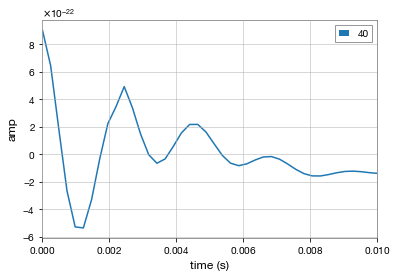

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:02 bilby INFO    : Injected signal in H1:
15:02 bilby INFO    :   optimal SNR = 17.57
15:02 bilby INFO    :   matched filter SNR = 17.77-1.07j
15:02 bilby INFO    :   frac_dw = 0.16384983608148138
15:02 bilby INFO    :   frac_dtau = 13.088445450650228
15:02 bilby INFO    :   dphi = 0
15:02 bilby INFO    :   A = 9e-22
15:02 bilby INFO    :   w = 2709.8454121124746
15:02 bilby INFO    :   t0 = 0
15:02 bilby INFO    :   phi = 0
15:02 bilby INFO    :   tau = -0.0024326733162414113
15:02 bilby INFO    :   geocent_time = 0
15:02 bilby INFO    :   frac_amp = 0.2
15:02 bilby INFO    :   ra = 0
15:02 bilby INFO    :   dec = 0
15:02 bilby INFO    :   psi = 0
15:02 bilby INFO    :   ts = 0.0022522130587699554
15:02 bilby INFO    : Injected


0it [00:00, ?it/s]

15:02 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12c5cdf10>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:02 bilby INFO    : Checkpoint every n_check_point = 400000
15:02 bilby INFO    : Using dynesty version 1.0.1
15:02 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:00,  1.12it/s, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-895.92+/-0.17 dlogz:inf>0.10]
75it [00:00,  1.60it/s, bound:0 nc:1 ncall:582 eff:12.9% logz-ratio=-683.54+/-0.14 dlogz:1067.221>0.10]
142it [00:01,  2.29it/s, bound:0 nc:2 ncall:665 eff:21.4% logz-ratio=-576.95+/-0.15 dlogz:960.965>0.10]
203it [00:01,  3.26it/s, bound:0 nc:2 ncall:747 eff:27.2% logz-ratio=-495.21+/-0.15 dlogz:879.052>0.10]
254it [00:01,  4.64it/s, bound:0 nc:3 ncall:831 eff:30.6% logz-ratio=-430.89+/-0.15 dlogz:814.220>0.10]
299it [00:01,  6.60it/s, bound:0 nc:1 ncall:919 eff:32.5% logz-ratio=-381.59+/-0.15 dlogz:765.145>0.10]
347it [00:01,  9.38it/s, bound:0 nc:3 ncall:1000 eff:34.7% logz-ratio=-336.53+/-0.16 dlogz:720.410>0.10]
393it [00:01, 13.25it/s, bound:0 nc:4 ncall:1103 eff:35.6% logz-ratio=-293.27+/-0.16 dlogz:676.804>0.10]
436it [00:01, 18.65it/s, bound:0 nc:1 ncall:1202 eff:36.3% logz-ratio=-260.36+/-0.14 dlogz:643.224>0.10]
477it [00:01, 25.91it/s, bound:0 nc:3 ncall:1325 eff:36.0% logz-rat

1385it [00:10, 45.89it/s, bound:0 nc:21 ncall:8328 eff:16.6% logz-ratio=24.84+/-0.16 dlogz:360.925>0.10]
1390it [00:10, 39.84it/s, bound:0 nc:5 ncall:8438 eff:16.5% logz-ratio=26.22+/-0.16 dlogz:359.508>0.10] 
1403it [00:10, 50.20it/s, bound:0 nc:2 ncall:8521 eff:16.5% logz-ratio=28.14+/-0.16 dlogz:357.486>0.10]
1410it [00:10, 50.16it/s, bound:0 nc:7 ncall:8619 eff:16.4% logz-ratio=29.23+/-0.16 dlogz:356.527>0.10]
1417it [00:11, 42.38it/s, bound:0 nc:1 ncall:8785 eff:16.1% logz-ratio=31.42+/-0.16 dlogz:354.340>0.10]
1424it [00:11, 46.52it/s, bound:0 nc:15 ncall:8886 eff:16.0% logz-ratio=33.16+/-0.16 dlogz:352.562>0.10]
1431it [00:11, 51.40it/s, bound:0 nc:24 ncall:8976 eff:15.9% logz-ratio=35.06+/-0.16 dlogz:350.688>0.10]
1437it [00:11, 45.84it/s, bound:0 nc:34 ncall:9120 eff:15.8% logz-ratio=36.92+/-0.17 dlogz:348.779>0.10]
1444it [00:11, 50.06it/s, bound:0 nc:30 ncall:9210 eff:15.7% logz-ratio=38.63+/-0.16 dlogz:347.045>0.10]
1450it [00:11, 42.23it/s, bound:0 nc:27 ncall:9338 eff:15.

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/likelihood.py:192: RuntimeWarning: invalid value encountered in cdouble_scalars
  complex_matched_filter_snr = d_inner_h / (optimal_snr_squared**0.5)



1531it [00:13, 35.14it/s, bound:0 nc:91 ncall:10879 eff:14.1% logz-ratio=65.51+/-0.17 dlogz:320.073>0.10]
1535it [00:13, 32.48it/s, bound:0 nc:16 ncall:10976 eff:14.0% logz-ratio=67.35+/-0.17 dlogz:318.295>0.10]
1541it [00:13, 37.20it/s, bound:0 nc:32 ncall:11061 eff:13.9% logz-ratio=69.47+/-0.17 dlogz:316.348>0.10]
1547it [00:13, 41.79it/s, bound:0 nc:20 ncall:11139 eff:13.9% logz-ratio=71.78+/-0.17 dlogz:313.889>0.10]
1552it [00:14, 38.63it/s, bound:0 nc:13 ncall:11237 eff:13.8% logz-ratio=73.68+/-0.17 dlogz:311.819>0.10]
1557it [00:14, 41.09it/s, bound:0 nc:37 ncall:11307 eff:13.8% logz-ratio=75.28+/-0.17 dlogz:310.172>0.10]
1564it [00:14, 40.91it/s, bound:0 nc:73 ncall:11421 eff:13.7% logz-ratio=77.92+/-0.17 dlogz:307.466>0.10]
1570it [00:14, 43.10it/s, bound:0 nc:23 ncall:11514 eff:13.6% logz-ratio=79.26+/-0.17 dlogz:306.100>0.10]
1575it [00:14, 39.41it/s, bound:0 nc:3 ncall:11618 eff:13.6% logz-ratio=80.45+/-0.17 dlogz:305.008>0.10] 
1580it [00:14, 39.78it/s, bound:0 nc:2 ncall:

1841it [00:25, 17.34it/s, bound:5 nc:30 ncall:19470 eff:9.5% logz-ratio=171.90+/-0.17 dlogz:213.146>0.10]
1844it [00:25, 18.70it/s, bound:5 nc:30 ncall:19570 eff:9.4% logz-ratio=172.77+/-0.17 dlogz:212.332>0.10]
1847it [00:25, 20.13it/s, bound:5 nc:35 ncall:19669 eff:9.4% logz-ratio=174.91+/-0.19 dlogz:210.711>0.10]
1850it [00:26, 20.65it/s, bound:6 nc:38 ncall:19779 eff:9.4% logz-ratio=176.65+/-0.18 dlogz:208.768>0.10]
1853it [00:26, 21.27it/s, bound:6 nc:35 ncall:19885 eff:9.3% logz-ratio=178.09+/-0.18 dlogz:207.074>0.10]
1856it [00:26, 21.85it/s, bound:6 nc:33 ncall:19991 eff:9.3% logz-ratio=179.07+/-0.18 dlogz:206.074>0.10]
1859it [00:26, 21.96it/s, bound:7 nc:37 ncall:20098 eff:9.2% logz-ratio=180.29+/-0.18 dlogz:204.886>0.10]
1862it [00:26, 20.72it/s, bound:7 nc:33 ncall:20206 eff:9.2% logz-ratio=182.19+/-0.18 dlogz:203.204>0.10]
1865it [00:26, 18.79it/s, bound:7 nc:39 ncall:20308 eff:9.2% logz-ratio=183.34+/-0.18 dlogz:201.795>0.10]
1867it [00:27, 17.08it/s, bound:8 nc:31 ncall:

2007it [00:35, 18.16it/s, bound:24 nc:38 ncall:25487 eff:7.9% logz-ratio=223.89+/-0.18 dlogz:160.809>0.10]
2009it [00:35, 17.84it/s, bound:24 nc:36 ncall:25559 eff:7.9% logz-ratio=224.33+/-0.18 dlogz:160.345>0.10]
2011it [00:35, 16.34it/s, bound:24 nc:38 ncall:25633 eff:7.8% logz-ratio=224.71+/-0.18 dlogz:159.943>0.10]
2013it [00:35, 16.12it/s, bound:24 nc:35 ncall:25704 eff:7.8% logz-ratio=225.07+/-0.17 dlogz:159.579>0.10]
2015it [00:35, 15.93it/s, bound:25 nc:37 ncall:25775 eff:7.8% logz-ratio=225.49+/-0.17 dlogz:159.186>0.10]
2017it [00:35, 16.14it/s, bound:25 nc:36 ncall:25848 eff:7.8% logz-ratio=225.94+/-0.18 dlogz:158.735>0.10]
2019it [00:36, 16.08it/s, bound:25 nc:38 ncall:25928 eff:7.8% logz-ratio=226.48+/-0.18 dlogz:158.236>0.10]
2021it [00:36, 16.32it/s, bound:25 nc:38 ncall:26004 eff:7.8% logz-ratio=226.88+/-0.18 dlogz:157.747>0.10]
2023it [00:36, 17.19it/s, bound:26 nc:28 ncall:26069 eff:7.8% logz-ratio=227.24+/-0.18 dlogz:157.382>0.10]
2025it [00:36, 15.57it/s, bound:26 nc

2164it [00:44, 20.95it/s, bound:42 nc:41 ncall:31431 eff:6.9% logz-ratio=263.16+/-0.18 dlogz:122.084>0.10]
2167it [00:45, 20.51it/s, bound:43 nc:43 ncall:31557 eff:6.9% logz-ratio=264.00+/-0.18 dlogz:121.205>0.10]
2170it [00:45, 20.72it/s, bound:43 nc:38 ncall:31672 eff:6.9% logz-ratio=264.77+/-0.18 dlogz:120.358>0.10]
2173it [00:45, 20.95it/s, bound:44 nc:34 ncall:31785 eff:6.8% logz-ratio=265.32+/-0.18 dlogz:119.770>0.10]
2176it [00:45, 20.49it/s, bound:44 nc:44 ncall:31913 eff:6.8% logz-ratio=265.88+/-0.18 dlogz:119.232>0.10]
2179it [00:45, 20.18it/s, bound:44 nc:44 ncall:32041 eff:6.8% logz-ratio=266.58+/-0.18 dlogz:118.589>0.10]
2182it [00:45, 20.14it/s, bound:45 nc:44 ncall:32163 eff:6.8% logz-ratio=267.53+/-0.18 dlogz:117.659>0.10]
2185it [00:45, 20.31it/s, bound:45 nc:39 ncall:32281 eff:6.8% logz-ratio=268.60+/-0.18 dlogz:116.590>0.10]
2188it [00:46, 20.84it/s, bound:45 nc:38 ncall:32392 eff:6.8% logz-ratio=269.69+/-0.18 dlogz:115.546>0.10]
2191it [00:46, 20.46it/s, bound:46 nc

2370it [00:55, 19.71it/s, bound:68 nc:41 ncall:39843 eff:5.9% logz-ratio=304.11+/-0.18 dlogz:80.669>0.10]
2372it [00:55, 19.38it/s, bound:69 nc:44 ncall:39929 eff:5.9% logz-ratio=304.54+/-0.18 dlogz:80.170>0.10]
2374it [00:55, 19.25it/s, bound:69 nc:44 ncall:40014 eff:5.9% logz-ratio=304.87+/-0.18 dlogz:79.798>0.10]
2376it [00:55, 19.47it/s, bound:69 nc:39 ncall:40097 eff:5.9% logz-ratio=305.15+/-0.18 dlogz:79.488>0.10]
2378it [00:55, 19.41it/s, bound:69 nc:42 ncall:40183 eff:5.9% logz-ratio=305.45+/-0.18 dlogz:79.204>0.10]
2380it [00:55, 19.33it/s, bound:70 nc:43 ncall:40268 eff:5.9% logz-ratio=305.75+/-0.18 dlogz:78.907>0.10]
2382it [00:55, 19.19it/s, bound:70 nc:43 ncall:40356 eff:5.9% logz-ratio=306.13+/-0.18 dlogz:78.553>0.10]
2384it [00:55, 19.20it/s, bound:70 nc:46 ncall:40443 eff:5.9% logz-ratio=306.49+/-0.18 dlogz:78.173>0.10]
2386it [00:55, 18.89it/s, bound:70 nc:43 ncall:40535 eff:5.9% logz-ratio=306.83+/-0.18 dlogz:77.828>0.10]
2388it [00:56, 18.79it/s, bound:71 nc:43 ncall

2549it [01:04, 19.25it/s, bound:92 nc:45 ncall:47411 eff:5.4% logz-ratio=328.96+/-0.18 dlogz:55.309>0.10]
2551it [01:04, 19.21it/s, bound:92 nc:44 ncall:47497 eff:5.4% logz-ratio=329.17+/-0.18 dlogz:55.085>0.10]
2553it [01:04, 18.97it/s, bound:93 nc:40 ncall:47586 eff:5.4% logz-ratio=329.39+/-0.18 dlogz:54.869>0.10]
2556it [01:04, 19.83it/s, bound:93 nc:36 ncall:47699 eff:5.4% logz-ratio=329.69+/-0.18 dlogz:54.549>0.10]
2558it [01:04, 19.72it/s, bound:93 nc:43 ncall:47785 eff:5.4% logz-ratio=329.87+/-0.18 dlogz:54.353>0.10]
2560it [01:04, 19.50it/s, bound:93 nc:44 ncall:47873 eff:5.3% logz-ratio=330.06+/-0.18 dlogz:54.171>0.10]
2562it [01:04, 18.90it/s, bound:94 nc:47 ncall:47967 eff:5.3% logz-ratio=330.27+/-0.18 dlogz:53.963>0.10]
2564it [01:05, 18.60it/s, bound:94 nc:46 ncall:48061 eff:5.3% logz-ratio=330.45+/-0.18 dlogz:53.764>0.10]
2566it [01:05, 18.55it/s, bound:94 nc:47 ncall:48152 eff:5.3% logz-ratio=330.63+/-0.18 dlogz:53.583>0.10]
2568it [01:05, 18.80it/s, bound:95 nc:43 ncall

2706it [01:12, 18.65it/s, bound:114 nc:44 ncall:54296 eff:5.0% logz-ratio=343.88+/-0.18 dlogz:40.016>0.10]
2708it [01:12, 18.44it/s, bound:114 nc:47 ncall:54389 eff:5.0% logz-ratio=343.99+/-0.18 dlogz:39.905>0.10]
2710it [01:12, 18.75it/s, bound:114 nc:43 ncall:54475 eff:5.0% logz-ratio=344.11+/-0.18 dlogz:39.790>0.10]
2713it [01:13, 19.22it/s, bound:115 nc:38 ncall:54592 eff:5.0% logz-ratio=344.32+/-0.18 dlogz:39.582>0.10]
2715it [01:13, 19.09it/s, bound:115 nc:45 ncall:54677 eff:5.0% logz-ratio=344.45+/-0.18 dlogz:39.440>0.10]
2717it [01:13, 18.61it/s, bound:115 nc:50 ncall:54773 eff:5.0% logz-ratio=344.59+/-0.18 dlogz:39.300>0.10]
2719it [01:13, 17.95it/s, bound:116 nc:51 ncall:54874 eff:5.0% logz-ratio=344.73+/-0.18 dlogz:39.160>0.10]
2721it [01:13, 17.99it/s, bound:116 nc:43 ncall:54967 eff:5.0% logz-ratio=344.88+/-0.18 dlogz:39.013>0.10]
2723it [01:13, 17.81it/s, bound:116 nc:51 ncall:55064 eff:4.9% logz-ratio=345.04+/-0.18 dlogz:38.852>0.10]
2725it [01:13, 18.16it/s, bound:116 n

2857it [01:20, 18.14it/s, bound:135 nc:47 ncall:61233 eff:4.7% logz-ratio=353.15+/-0.18 dlogz:30.437>0.10]
2859it [01:21, 18.05it/s, bound:135 nc:46 ncall:61328 eff:4.7% logz-ratio=353.24+/-0.18 dlogz:30.342>0.10]
2861it [01:21, 17.78it/s, bound:136 nc:49 ncall:61425 eff:4.7% logz-ratio=353.34+/-0.18 dlogz:30.245>0.10]
2863it [01:21, 17.65it/s, bound:136 nc:52 ncall:61523 eff:4.7% logz-ratio=353.43+/-0.18 dlogz:30.149>0.10]
2865it [01:21, 17.79it/s, bound:136 nc:45 ncall:61612 eff:4.7% logz-ratio=353.52+/-0.18 dlogz:30.054>0.10]
2867it [01:21, 17.68it/s, bound:137 nc:47 ncall:61707 eff:4.6% logz-ratio=353.61+/-0.18 dlogz:29.961>0.10]
2869it [01:21, 17.97it/s, bound:137 nc:47 ncall:61796 eff:4.6% logz-ratio=353.71+/-0.18 dlogz:29.861>0.10]
2871it [01:21, 18.15it/s, bound:137 nc:44 ncall:61887 eff:4.6% logz-ratio=353.81+/-0.18 dlogz:29.754>0.10]
2873it [01:21, 17.87it/s, bound:137 nc:47 ncall:61985 eff:4.6% logz-ratio=353.93+/-0.18 dlogz:29.638>0.10]
2875it [01:21, 17.68it/s, bound:138 n

3005it [01:29, 17.59it/s, bound:156 nc:49 ncall:68191 eff:4.4% logz-ratio=360.11+/-0.18 dlogz:23.174>0.10]
3007it [01:29, 17.62it/s, bound:157 nc:48 ncall:68283 eff:4.4% logz-ratio=360.18+/-0.18 dlogz:23.096>0.10]
3009it [01:29, 17.70it/s, bound:157 nc:44 ncall:68373 eff:4.4% logz-ratio=360.26+/-0.18 dlogz:23.016>0.10]
3011it [01:29, 17.69it/s, bound:157 nc:47 ncall:68468 eff:4.4% logz-ratio=360.34+/-0.18 dlogz:22.933>0.10]
3013it [01:29, 17.62it/s, bound:157 nc:46 ncall:68565 eff:4.4% logz-ratio=360.42+/-0.18 dlogz:22.850>0.10]
3015it [01:29, 17.70it/s, bound:158 nc:44 ncall:68658 eff:4.4% logz-ratio=360.49+/-0.18 dlogz:22.771>0.10]
3017it [01:30, 17.45it/s, bound:158 nc:47 ncall:68756 eff:4.4% logz-ratio=360.57+/-0.18 dlogz:22.690>0.10]
3019it [01:30, 16.96it/s, bound:158 nc:51 ncall:68862 eff:4.4% logz-ratio=360.65+/-0.18 dlogz:22.608>0.10]
3021it [01:30, 17.23it/s, bound:159 nc:46 ncall:68955 eff:4.4% logz-ratio=360.72+/-0.18 dlogz:22.528>0.10]
3023it [01:30, 17.22it/s, bound:159 n

3153it [01:37, 17.03it/s, bound:178 nc:49 ncall:75355 eff:4.2% logz-ratio=365.22+/-0.18 dlogz:17.770>0.10]
3155it [01:37, 17.20it/s, bound:178 nc:47 ncall:75450 eff:4.2% logz-ratio=365.29+/-0.18 dlogz:17.695>0.10]
3157it [01:38, 17.02it/s, bound:178 nc:54 ncall:75552 eff:4.2% logz-ratio=365.36+/-0.18 dlogz:17.618>0.10]
3159it [01:38, 17.01it/s, bound:179 nc:49 ncall:75650 eff:4.2% logz-ratio=365.43+/-0.18 dlogz:17.544>0.10]
3161it [01:38, 17.02it/s, bound:179 nc:49 ncall:75749 eff:4.2% logz-ratio=365.50+/-0.18 dlogz:17.473>0.10]
3163it [01:38, 16.97it/s, bound:179 nc:49 ncall:75847 eff:4.2% logz-ratio=365.56+/-0.18 dlogz:17.404>0.10]
3165it [01:38, 17.03it/s, bound:179 nc:50 ncall:75945 eff:4.2% logz-ratio=365.62+/-0.18 dlogz:17.336>0.10]
3167it [01:38, 17.10it/s, bound:180 nc:46 ncall:76042 eff:4.2% logz-ratio=365.68+/-0.18 dlogz:17.270>0.10]
3169it [01:38, 17.10it/s, bound:180 nc:51 ncall:76141 eff:4.2% logz-ratio=365.74+/-0.18 dlogz:17.205>0.10]
3171it [01:38, 17.05it/s, bound:180 n

3301it [01:46, 16.90it/s, bound:199 nc:49 ncall:82633 eff:4.0% logz-ratio=368.57+/-0.18 dlogz:14.105>0.10]
3303it [01:46, 16.92it/s, bound:200 nc:49 ncall:82731 eff:4.0% logz-ratio=368.60+/-0.18 dlogz:14.065>0.10]
3305it [01:46, 17.03it/s, bound:200 nc:50 ncall:82828 eff:4.0% logz-ratio=368.64+/-0.18 dlogz:14.027>0.10]
3307it [01:46, 16.91it/s, bound:200 nc:49 ncall:82926 eff:4.0% logz-ratio=368.67+/-0.18 dlogz:13.987>0.10]
3309it [01:47, 16.94it/s, bound:200 nc:46 ncall:83023 eff:4.0% logz-ratio=368.71+/-0.18 dlogz:13.947>0.10]
3311it [01:47, 16.83it/s, bound:201 nc:51 ncall:83124 eff:4.0% logz-ratio=368.75+/-0.18 dlogz:13.907>0.10]
3313it [01:47, 16.92it/s, bound:201 nc:50 ncall:83223 eff:4.0% logz-ratio=368.78+/-0.18 dlogz:13.867>0.10]
3315it [01:47, 17.07it/s, bound:201 nc:48 ncall:83320 eff:4.0% logz-ratio=368.82+/-0.18 dlogz:13.825>0.10]
3317it [01:47, 17.17it/s, bound:202 nc:47 ncall:83416 eff:4.0% logz-ratio=368.86+/-0.18 dlogz:13.785>0.10]
3319it [01:47, 17.06it/s, bound:202 n

3449it [01:55, 16.81it/s, bound:222 nc:49 ncall:90014 eff:3.8% logz-ratio=371.44+/-0.18 dlogz:10.937>0.10]
3451it [01:55, 16.96it/s, bound:222 nc:49 ncall:90112 eff:3.8% logz-ratio=371.47+/-0.18 dlogz:10.901>0.10]
3453it [01:55, 17.09it/s, bound:222 nc:49 ncall:90210 eff:3.8% logz-ratio=371.51+/-0.18 dlogz:10.863>0.10]
3455it [01:55, 16.89it/s, bound:223 nc:51 ncall:90312 eff:3.8% logz-ratio=371.54+/-0.18 dlogz:10.826>0.10]
3457it [01:55, 16.82it/s, bound:223 nc:52 ncall:90414 eff:3.8% logz-ratio=371.57+/-0.18 dlogz:10.788>0.10]
3459it [01:55, 16.62it/s, bound:223 nc:54 ncall:90518 eff:3.8% logz-ratio=371.61+/-0.18 dlogz:10.750>0.10]
3461it [01:56, 16.65it/s, bound:224 nc:50 ncall:90618 eff:3.8% logz-ratio=371.65+/-0.18 dlogz:10.709>0.10]
3463it [01:56, 16.74it/s, bound:224 nc:50 ncall:90718 eff:3.8% logz-ratio=371.68+/-0.18 dlogz:10.668>0.10]
3465it [01:56, 16.85it/s, bound:224 nc:49 ncall:90817 eff:3.8% logz-ratio=371.72+/-0.18 dlogz:10.627>0.10]
3467it [01:56, 16.65it/s, bound:225 n

3597it [02:04, 16.94it/s, bound:245 nc:49 ncall:97409 eff:3.7% logz-ratio=373.77+/-0.18 dlogz:8.310>0.10]
3599it [02:04, 16.52it/s, bound:245 nc:54 ncall:97512 eff:3.7% logz-ratio=373.79+/-0.18 dlogz:8.280>0.10]
3601it [02:04, 16.69it/s, bound:245 nc:49 ncall:97611 eff:3.7% logz-ratio=373.82+/-0.18 dlogz:8.249>0.10]
3603it [02:04, 16.63it/s, bound:246 nc:53 ncall:97713 eff:3.7% logz-ratio=373.85+/-0.18 dlogz:8.219>0.10]
3605it [02:04, 16.79it/s, bound:246 nc:49 ncall:97811 eff:3.7% logz-ratio=373.87+/-0.18 dlogz:8.188>0.10]
3607it [02:04, 16.72it/s, bound:246 nc:50 ncall:97913 eff:3.7% logz-ratio=373.90+/-0.18 dlogz:8.158>0.10]
3609it [02:04, 16.79it/s, bound:247 nc:49 ncall:98011 eff:3.7% logz-ratio=373.93+/-0.18 dlogz:8.128>0.10]
3611it [02:05, 16.67it/s, bound:247 nc:51 ncall:98111 eff:3.7% logz-ratio=373.95+/-0.18 dlogz:8.098>0.10]
3613it [02:05, 16.63it/s, bound:247 nc:49 ncall:98209 eff:3.7% logz-ratio=373.98+/-0.18 dlogz:8.068>0.10]
3615it [02:05, 16.73it/s, bound:247 nc:50 ncal

3745it [02:13, 16.74it/s, bound:268 nc:49 ncall:104849 eff:3.6% logz-ratio=375.32+/-0.18 dlogz:6.469>0.10]
3747it [02:13, 16.60it/s, bound:268 nc:50 ncall:104953 eff:3.6% logz-ratio=375.33+/-0.18 dlogz:6.448>0.10]
3749it [02:13, 16.36it/s, bound:268 nc:52 ncall:105055 eff:3.6% logz-ratio=375.35+/-0.18 dlogz:6.428>0.10]
3751it [02:13, 16.47it/s, bound:269 nc:49 ncall:105155 eff:3.6% logz-ratio=375.37+/-0.18 dlogz:6.408>0.10]
3753it [02:13, 16.44it/s, bound:269 nc:49 ncall:105253 eff:3.6% logz-ratio=375.38+/-0.18 dlogz:6.387>0.10]
3755it [02:13, 16.53it/s, bound:269 nc:51 ncall:105353 eff:3.6% logz-ratio=375.40+/-0.18 dlogz:6.366>0.10]
3757it [02:13, 16.57it/s, bound:270 nc:52 ncall:105454 eff:3.6% logz-ratio=375.42+/-0.18 dlogz:6.345>0.10]
3759it [02:13, 16.51it/s, bound:270 nc:54 ncall:105558 eff:3.6% logz-ratio=375.43+/-0.18 dlogz:6.325>0.10]
3761it [02:14, 16.49it/s, bound:270 nc:50 ncall:105661 eff:3.6% logz-ratio=375.45+/-0.18 dlogz:6.304>0.10]
3763it [02:14, 16.52it/s, bound:271 n

3893it [02:22, 16.64it/s, bound:291 nc:51 ncall:112317 eff:3.5% logz-ratio=376.55+/-0.18 dlogz:4.947>0.10]
3895it [02:22, 16.68it/s, bound:292 nc:50 ncall:112416 eff:3.5% logz-ratio=376.57+/-0.18 dlogz:4.928>0.10]
3897it [02:22, 16.71it/s, bound:292 nc:49 ncall:112514 eff:3.5% logz-ratio=376.58+/-0.18 dlogz:4.909>0.10]
3899it [02:22, 16.84it/s, bound:292 nc:50 ncall:112613 eff:3.5% logz-ratio=376.60+/-0.18 dlogz:4.891>0.10]
3901it [02:22, 16.71it/s, bound:293 nc:49 ncall:112712 eff:3.5% logz-ratio=376.61+/-0.18 dlogz:4.872>0.10]
3903it [02:22, 16.77it/s, bound:293 nc:50 ncall:112812 eff:3.5% logz-ratio=376.63+/-0.18 dlogz:4.853>0.10]
3905it [02:22, 16.72it/s, bound:293 nc:50 ncall:112912 eff:3.5% logz-ratio=376.64+/-0.18 dlogz:4.835>0.10]
3907it [02:22, 16.58it/s, bound:294 nc:52 ncall:113015 eff:3.5% logz-ratio=376.66+/-0.18 dlogz:4.817>0.10]
3909it [02:22, 16.80it/s, bound:294 nc:49 ncall:113113 eff:3.5% logz-ratio=376.67+/-0.18 dlogz:4.798>0.10]
3911it [02:23, 16.95it/s, bound:294 n

4041it [02:30, 16.84it/s, bound:315 nc:49 ncall:119754 eff:3.4% logz-ratio=377.49+/-0.18 dlogz:3.729>0.10]
4043it [02:31, 16.92it/s, bound:315 nc:49 ncall:119854 eff:3.4% logz-ratio=377.50+/-0.18 dlogz:3.714>0.10]
4045it [02:31, 16.56it/s, bound:315 nc:51 ncall:119958 eff:3.4% logz-ratio=377.51+/-0.18 dlogz:3.700>0.10]
4047it [02:31, 16.52it/s, bound:316 nc:49 ncall:120059 eff:3.4% logz-ratio=377.52+/-0.18 dlogz:3.686>0.10]
4049it [02:31, 16.47it/s, bound:316 nc:50 ncall:120163 eff:3.4% logz-ratio=377.53+/-0.18 dlogz:3.671>0.10]
4051it [02:31, 16.63it/s, bound:316 nc:50 ncall:120262 eff:3.4% logz-ratio=377.55+/-0.18 dlogz:3.657>0.10]
4053it [02:31, 16.74it/s, bound:317 nc:49 ncall:120360 eff:3.4% logz-ratio=377.56+/-0.18 dlogz:3.643>0.10]
4055it [02:31, 16.83it/s, bound:317 nc:49 ncall:120458 eff:3.4% logz-ratio=377.57+/-0.18 dlogz:3.629>0.10]
4057it [02:31, 16.44it/s, bound:317 nc:55 ncall:120567 eff:3.4% logz-ratio=377.58+/-0.18 dlogz:3.615>0.10]
4059it [02:32, 16.46it/s, bound:318 n

4189it [02:39, 16.36it/s, bound:338 nc:51 ncall:127175 eff:3.3% logz-ratio=378.18+/-0.18 dlogz:2.779>0.10]
4191it [02:40, 16.48it/s, bound:338 nc:50 ncall:127274 eff:3.3% logz-ratio=378.19+/-0.18 dlogz:2.768>0.10]
4193it [02:40, 16.57it/s, bound:338 nc:49 ncall:127375 eff:3.3% logz-ratio=378.20+/-0.18 dlogz:2.757>0.10]
4195it [02:40, 16.43it/s, bound:339 nc:54 ncall:127479 eff:3.3% logz-ratio=378.21+/-0.18 dlogz:2.746>0.10]
4197it [02:40, 16.57it/s, bound:339 nc:49 ncall:127578 eff:3.3% logz-ratio=378.22+/-0.18 dlogz:2.735>0.10]
4199it [02:40, 16.53it/s, bound:339 nc:49 ncall:127679 eff:3.3% logz-ratio=378.22+/-0.18 dlogz:2.724>0.10]
4201it [02:40, 16.46it/s, bound:340 nc:51 ncall:127780 eff:3.3% logz-ratio=378.23+/-0.18 dlogz:2.713>0.10]
4203it [02:40, 16.24it/s, bound:340 nc:57 ncall:127888 eff:3.3% logz-ratio=378.24+/-0.18 dlogz:2.702>0.10]
4205it [02:40, 16.49it/s, bound:340 nc:49 ncall:127987 eff:3.3% logz-ratio=378.25+/-0.18 dlogz:2.691>0.10]
4207it [02:40, 16.52it/s, bound:341 n

4337it [02:49, 16.57it/s, bound:361 nc:50 ncall:134626 eff:3.2% logz-ratio=378.68+/-0.18 dlogz:2.056>0.10]
4339it [02:49, 16.56it/s, bound:362 nc:50 ncall:134727 eff:3.2% logz-ratio=378.69+/-0.18 dlogz:2.047>0.10]
4341it [02:49, 16.57it/s, bound:362 nc:50 ncall:134830 eff:3.2% logz-ratio=378.69+/-0.18 dlogz:2.039>0.10]
4343it [02:49, 16.19it/s, bound:362 nc:56 ncall:134937 eff:3.2% logz-ratio=378.70+/-0.18 dlogz:2.031>0.10]
4345it [02:49, 16.31it/s, bound:363 nc:49 ncall:135035 eff:3.2% logz-ratio=378.71+/-0.18 dlogz:2.022>0.10]
4347it [02:49, 16.57it/s, bound:363 nc:49 ncall:135133 eff:3.2% logz-ratio=378.71+/-0.18 dlogz:2.014>0.10]
4349it [02:49, 16.72it/s, bound:363 nc:49 ncall:135232 eff:3.2% logz-ratio=378.72+/-0.18 dlogz:2.005>0.10]
4351it [02:50, 16.86it/s, bound:364 nc:49 ncall:135330 eff:3.2% logz-ratio=378.72+/-0.18 dlogz:1.997>0.10]
4353it [02:50, 16.71it/s, bound:364 nc:50 ncall:135435 eff:3.2% logz-ratio=378.73+/-0.18 dlogz:1.989>0.10]
4355it [02:50, 16.74it/s, bound:364 n

4485it [02:58, 16.79it/s, bound:384 nc:50 ncall:142046 eff:3.2% logz-ratio=379.05+/-0.18 dlogz:1.504>0.10]
4487it [02:58, 16.74it/s, bound:385 nc:49 ncall:142147 eff:3.2% logz-ratio=379.06+/-0.18 dlogz:1.497>0.10]
4489it [02:58, 16.93it/s, bound:385 nc:49 ncall:142245 eff:3.2% logz-ratio=379.06+/-0.18 dlogz:1.491>0.10]
4491it [02:58, 16.88it/s, bound:385 nc:50 ncall:142346 eff:3.2% logz-ratio=379.07+/-0.18 dlogz:1.484>0.10]
4493it [02:58, 16.86it/s, bound:386 nc:51 ncall:142446 eff:3.2% logz-ratio=379.07+/-0.18 dlogz:1.478>0.10]
4495it [02:58, 16.80it/s, bound:386 nc:50 ncall:142547 eff:3.2% logz-ratio=379.08+/-0.18 dlogz:1.471>0.10]
4497it [02:58, 16.94it/s, bound:386 nc:50 ncall:142646 eff:3.2% logz-ratio=379.08+/-0.18 dlogz:1.465>0.10]
4499it [02:58, 16.81it/s, bound:387 nc:52 ncall:142748 eff:3.2% logz-ratio=379.08+/-0.18 dlogz:1.459>0.10]
4501it [02:59, 16.94it/s, bound:387 nc:49 ncall:142846 eff:3.2% logz-ratio=379.09+/-0.18 dlogz:1.452>0.10]
4503it [02:59, 16.80it/s, bound:387 n

4633it [03:06, 16.76it/s, bound:408 nc:50 ncall:149514 eff:3.1% logz-ratio=379.34+/-0.18 dlogz:1.087>0.10]
4635it [03:07, 16.52it/s, bound:409 nc:49 ncall:149619 eff:3.1% logz-ratio=379.34+/-0.18 dlogz:1.082>0.10]
4637it [03:07, 16.66it/s, bound:409 nc:49 ncall:149719 eff:3.1% logz-ratio=379.34+/-0.18 dlogz:1.077>0.10]
4639it [03:07, 16.80it/s, bound:409 nc:50 ncall:149818 eff:3.1% logz-ratio=379.34+/-0.18 dlogz:1.072>0.10]
4641it [03:07, 16.91it/s, bound:409 nc:49 ncall:149916 eff:3.1% logz-ratio=379.35+/-0.18 dlogz:1.068>0.10]
4643it [03:07, 16.65it/s, bound:410 nc:50 ncall:150017 eff:3.1% logz-ratio=379.35+/-0.18 dlogz:1.063>0.10]
4645it [03:07, 16.55it/s, bound:410 nc:52 ncall:150119 eff:3.1% logz-ratio=379.35+/-0.18 dlogz:1.058>0.10]
4647it [03:07, 16.46it/s, bound:410 nc:49 ncall:150218 eff:3.1% logz-ratio=379.36+/-0.18 dlogz:1.054>0.10]
4649it [03:07, 16.56it/s, bound:411 nc:50 ncall:150317 eff:3.1% logz-ratio=379.36+/-0.18 dlogz:1.049>0.10]
4651it [03:08, 16.75it/s, bound:411 n

4781it [03:15, 16.83it/s, bound:432 nc:49 ncall:156945 eff:3.0% logz-ratio=379.55+/-0.18 dlogz:0.778>0.10]
4783it [03:15, 16.86it/s, bound:432 nc:50 ncall:157044 eff:3.0% logz-ratio=379.55+/-0.18 dlogz:0.775>0.10]
4785it [03:16, 16.64it/s, bound:432 nc:49 ncall:157143 eff:3.0% logz-ratio=379.56+/-0.18 dlogz:0.771>0.10]
4787it [03:16, 16.41it/s, bound:433 nc:52 ncall:157248 eff:3.0% logz-ratio=379.56+/-0.18 dlogz:0.768>0.10]
4789it [03:16, 16.42it/s, bound:433 nc:52 ncall:157351 eff:3.0% logz-ratio=379.56+/-0.18 dlogz:0.764>0.10]
4791it [03:16, 16.51it/s, bound:433 nc:49 ncall:157453 eff:3.0% logz-ratio=379.56+/-0.18 dlogz:0.761>0.10]
4793it [03:16, 16.67it/s, bound:434 nc:49 ncall:157551 eff:3.0% logz-ratio=379.57+/-0.18 dlogz:0.757>0.10]
4795it [03:16, 16.66it/s, bound:434 nc:52 ncall:157652 eff:3.0% logz-ratio=379.57+/-0.18 dlogz:0.754>0.10]
4797it [03:16, 16.70it/s, bound:434 nc:50 ncall:157751 eff:3.0% logz-ratio=379.57+/-0.18 dlogz:0.751>0.10]
4799it [03:16, 16.87it/s, bound:434 n

4929it [03:24, 16.72it/s, bound:455 nc:50 ncall:164370 eff:3.0% logz-ratio=379.71+/-0.18 dlogz:0.557>0.10]
4931it [03:24, 16.84it/s, bound:455 nc:49 ncall:164468 eff:3.0% logz-ratio=379.71+/-0.18 dlogz:0.554>0.10]
4933it [03:24, 16.93it/s, bound:455 nc:50 ncall:164567 eff:3.0% logz-ratio=379.72+/-0.18 dlogz:0.552>0.10]
4935it [03:25, 16.85it/s, bound:456 nc:51 ncall:164667 eff:3.0% logz-ratio=379.72+/-0.18 dlogz:0.549>0.10]
4937it [03:25, 16.75it/s, bound:456 nc:49 ncall:164766 eff:3.0% logz-ratio=379.72+/-0.18 dlogz:0.547>0.10]
4939it [03:25, 16.00it/s, bound:456 nc:53 ncall:164879 eff:3.0% logz-ratio=379.72+/-0.18 dlogz:0.544>0.10]
4941it [03:25, 16.19it/s, bound:457 nc:50 ncall:164978 eff:3.0% logz-ratio=379.72+/-0.18 dlogz:0.542>0.10]
4943it [03:25, 16.24it/s, bound:457 nc:50 ncall:165077 eff:3.0% logz-ratio=379.73+/-0.18 dlogz:0.540>0.10]
4945it [03:25, 16.39it/s, bound:457 nc:49 ncall:165178 eff:3.0% logz-ratio=379.73+/-0.18 dlogz:0.537>0.10]
4947it [03:25, 16.39it/s, bound:458 n

5077it [03:33, 16.47it/s, bound:479 nc:53 ncall:171859 eff:3.0% logz-ratio=379.83+/-0.18 dlogz:0.400>0.10]
5079it [03:33, 16.45it/s, bound:479 nc:53 ncall:171962 eff:3.0% logz-ratio=379.83+/-0.18 dlogz:0.398>0.10]
5081it [03:33, 16.70it/s, bound:479 nc:49 ncall:172060 eff:3.0% logz-ratio=379.83+/-0.18 dlogz:0.397>0.10]
5083it [03:33, 16.73it/s, bound:480 nc:49 ncall:172159 eff:3.0% logz-ratio=379.84+/-0.18 dlogz:0.395>0.10]
5085it [03:34, 16.86it/s, bound:480 nc:50 ncall:172258 eff:3.0% logz-ratio=379.84+/-0.18 dlogz:0.393>0.10]
5087it [03:34, 16.94it/s, bound:480 nc:49 ncall:172358 eff:3.0% logz-ratio=379.84+/-0.18 dlogz:0.391>0.10]
5089it [03:34, 16.86it/s, bound:481 nc:49 ncall:172456 eff:3.0% logz-ratio=379.84+/-0.18 dlogz:0.390>0.10]
5091it [03:34, 16.97it/s, bound:481 nc:49 ncall:172555 eff:3.0% logz-ratio=379.84+/-0.18 dlogz:0.388>0.10]
5093it [03:34, 16.86it/s, bound:481 nc:49 ncall:172653 eff:2.9% logz-ratio=379.84+/-0.18 dlogz:0.386>0.10]
5095it [03:34, 16.82it/s, bound:481 n

5225it [03:42, 16.50it/s, bound:502 nc:52 ncall:179294 eff:2.9% logz-ratio=379.92+/-0.18 dlogz:0.289>0.10]
5227it [03:42, 16.71it/s, bound:502 nc:50 ncall:179393 eff:2.9% logz-ratio=379.92+/-0.18 dlogz:0.288>0.10]
5229it [03:42, 16.91it/s, bound:502 nc:49 ncall:179491 eff:2.9% logz-ratio=379.92+/-0.18 dlogz:0.287>0.10]
5231it [03:42, 16.92it/s, bound:502 nc:51 ncall:179591 eff:2.9% logz-ratio=379.92+/-0.18 dlogz:0.285>0.10]
5233it [03:42, 16.75it/s, bound:503 nc:49 ncall:179693 eff:2.9% logz-ratio=379.92+/-0.18 dlogz:0.284>0.10]
5235it [03:43, 16.86it/s, bound:503 nc:49 ncall:179792 eff:2.9% logz-ratio=379.92+/-0.18 dlogz:0.283>0.10]
5237it [03:43, 17.03it/s, bound:503 nc:49 ncall:179890 eff:2.9% logz-ratio=379.93+/-0.18 dlogz:0.282>0.10]
5239it [03:43, 16.86it/s, bound:504 nc:52 ncall:179992 eff:2.9% logz-ratio=379.93+/-0.18 dlogz:0.281>0.10]
5241it [03:43, 16.85it/s, bound:504 nc:49 ncall:180093 eff:2.9% logz-ratio=379.93+/-0.18 dlogz:0.279>0.10]
5243it [03:43, 16.63it/s, bound:504 n

5373it [03:51, 16.90it/s, bound:525 nc:49 ncall:186735 eff:2.9% logz-ratio=379.98+/-0.18 dlogz:0.210>0.10]
5375it [03:51, 16.80it/s, bound:526 nc:51 ncall:186837 eff:2.9% logz-ratio=379.98+/-0.18 dlogz:0.209>0.10]
5377it [03:51, 16.91it/s, bound:526 nc:49 ncall:186935 eff:2.9% logz-ratio=379.99+/-0.18 dlogz:0.208>0.10]
5379it [03:51, 16.90it/s, bound:526 nc:49 ncall:187035 eff:2.9% logz-ratio=379.99+/-0.18 dlogz:0.207>0.10]
5381it [03:51, 16.71it/s, bound:527 nc:52 ncall:187138 eff:2.9% logz-ratio=379.99+/-0.18 dlogz:0.207>0.10]
5383it [03:51, 16.89it/s, bound:527 nc:49 ncall:187236 eff:2.9% logz-ratio=379.99+/-0.18 dlogz:0.206>0.10]
5385it [03:52, 16.95it/s, bound:527 nc:50 ncall:187335 eff:2.9% logz-ratio=379.99+/-0.18 dlogz:0.205>0.10]
5387it [03:52, 17.05it/s, bound:527 nc:49 ncall:187433 eff:2.9% logz-ratio=379.99+/-0.18 dlogz:0.204>0.10]
5389it [03:52, 16.94it/s, bound:528 nc:49 ncall:187533 eff:2.9% logz-ratio=379.99+/-0.18 dlogz:0.203>0.10]
5391it [03:52, 16.74it/s, bound:528 n

5521it [04:00, 16.58it/s, bound:549 nc:53 ncall:194184 eff:2.8% logz-ratio=380.03+/-0.18 dlogz:0.153>0.10]
5523it [04:00, 16.53it/s, bound:549 nc:50 ncall:194287 eff:2.8% logz-ratio=380.03+/-0.18 dlogz:0.153>0.10]
5525it [04:00, 16.64it/s, bound:549 nc:49 ncall:194387 eff:2.8% logz-ratio=380.03+/-0.18 dlogz:0.152>0.10]
5527it [04:00, 16.56it/s, bound:550 nc:54 ncall:194490 eff:2.8% logz-ratio=380.03+/-0.18 dlogz:0.151>0.10]
5529it [04:00, 16.76it/s, bound:550 nc:49 ncall:194588 eff:2.8% logz-ratio=380.04+/-0.18 dlogz:0.151>0.10]
5531it [04:00, 16.85it/s, bound:550 nc:50 ncall:194687 eff:2.8% logz-ratio=380.04+/-0.18 dlogz:0.150>0.10]
5533it [04:00, 16.67it/s, bound:551 nc:54 ncall:194790 eff:2.8% logz-ratio=380.04+/-0.18 dlogz:0.149>0.10]
5535it [04:01, 16.82it/s, bound:551 nc:49 ncall:194889 eff:2.8% logz-ratio=380.04+/-0.18 dlogz:0.149>0.10]
5537it [04:01, 16.82it/s, bound:551 nc:51 ncall:194990 eff:2.8% logz-ratio=380.04+/-0.18 dlogz:0.148>0.10]
5539it [04:01, 16.49it/s, bound:552 n

5669it [04:09, 16.60it/s, bound:572 nc:50 ncall:201638 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.112>0.10]
5671it [04:09, 16.71it/s, bound:572 nc:51 ncall:201738 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.112>0.10]
5673it [04:09, 16.76it/s, bound:573 nc:49 ncall:201837 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.111>0.10]
5675it [04:09, 16.25it/s, bound:573 nc:52 ncall:201940 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.111>0.10]
5677it [04:09, 16.10it/s, bound:573 nc:50 ncall:202039 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.110>0.10]
5679it [04:09, 16.27it/s, bound:574 nc:51 ncall:202139 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.110>0.10]
5681it [04:09, 16.54it/s, bound:574 nc:50 ncall:202238 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.110>0.10]
5683it [04:09, 16.25it/s, bound:574 nc:52 ncall:202347 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.109>0.10]
5685it [04:10, 16.35it/s, bound:575 nc:50 ncall:202447 eff:2.8% logz-ratio=380.07+/-0.18 dlogz:0.109>0.10]
5687it [04:10, 16.27it/s, bound:575 n

15:06 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass40_220_9_9e-22_2mode_frac0.2_resume.pickle



5724it [04:13, 22.61it/s, bound:581 nc:1 ncall:204424 eff:3.0% logz-ratio=380.17+/-0.18 dlogz:0.000>0.10] 



15:06 bilby INFO    : Sampling time: 0:04:11.606219
15:06 bilby INFO    : Summary of results:
nsamples: 6224
log_noise_evidence: -4560.034
log_evidence: -4179.859 +/-  0.180
log_bayes_factor: 380.175 +/-  0.180



GR freq is 287.523528235063
Q freq is 47.110682969962056
frac_dw is 0.16384983607827397
{'frac_dw': 0.16384983607827397, 'frac_dtau': 13.088445450906436, 'dphi': 0, 'A': 9e-22, 'w': 1806.5636080749828, 't0': 0, 'phi': 0, 'tau': -0.0036490099743621174, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.003378319588221065}


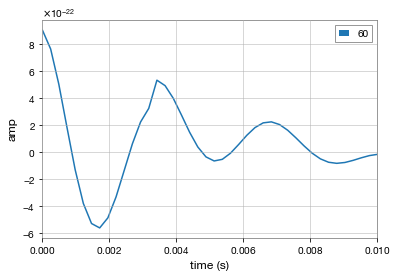

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:06 bilby INFO    : Injected signal in H1:
15:06 bilby INFO    :   optimal SNR = 17.76
15:06 bilby INFO    :   matched filter SNR = 17.99+2.49j
15:06 bilby INFO    :   frac_dw = 0.16384983607827397
15:06 bilby INFO    :   frac_dtau = 13.088445450906436
15:06 bilby INFO    :   dphi = 0
15:06 bilby INFO    :   A = 9e-22
15:06 bilby INFO    :   w = 1806.5636080749828
15:06 bilby INFO    :   t0 = 0
15:06 bilby INFO    :   phi = 0
15:06 bilby INFO    :   tau = -0.0036490099743621174
15:06 bilby INFO    :   geocent_time = 0
15:06 bilby INFO    :   frac_amp = 0.2
15:06 bilby INFO    :   ra = 0
15:06 bilby INFO    :   dec = 0
15:06 bilby INFO    :   psi = 0
15:06 bilby INFO    :   ts = 0.003378319588221065
15:06 bilby INFO    : Injected 


0it [00:00, ?it/s]

15:06 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x13cb706d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:06 bilby INFO    : Checkpoint every n_check_point = 500000
15:06 bilby INFO    : Using dynesty version 1.0.1
15:06 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:00,  1.14it/s, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-1348.64+/-0.17 dlogz:inf>0.10]
77it [00:00,  1.63it/s, bound:0 nc:1 ncall:583 eff:13.2% logz-ratio=-1024.98+/-0.15 dlogz:1427.948>0.10]
149it [00:01,  2.33it/s, bound:0 nc:1 ncall:663 eff:22.5% logz-ratio=-841.45+/-0.17 dlogz:1261.589>0.10]
209it [00:01,  3.32it/s, bound:0 nc:1 ncall:748 eff:27.9% logz-ratio=-710.55+/-0.17 dlogz:1128.434>0.10]
268it [00:01,  4.73it/s, bound:0 nc:3 ncall:832 eff:32.2% logz-ratio=-593.14+/-0.16 dlogz:1008.405>0.10]
319it [00:01,  6.73it/s, bound:0 nc:3 ncall:919 eff:34.7% logz-ratio=-502.12+/-0.15 dlogz:916.830>0.10] 
368it [00:01,  9.53it/s, bound:0 nc:6 ncall:1034 eff:35.6% logz-ratio=-419.32+/-0.15 dlogz:834.100>0.10]
414it [00:01, 13.50it/s, bound:0 nc:1 ncall:1121 eff:36.9% logz-ratio=-344.73+/-0.16 dlogz:759.117>0.10]
460it [00:01, 18.95it/s, bound:0 nc:1 ncall:1240 eff:37.1% logz-ratio=-281.61+/-0.17 dlogz:698.365>0.10]
502it [00:01, 26.44it/s, bound:0 nc:1 ncall:1348 eff:37.2% lo

1405it [00:10, 57.83it/s, bound:0 nc:27 ncall:9024 eff:15.6% logz-ratio=46.75+/-0.16 dlogz:366.038>0.10]
1412it [00:10, 54.75it/s, bound:0 nc:32 ncall:9149 eff:15.4% logz-ratio=48.30+/-0.16 dlogz:364.739>0.10]
1422it [00:10, 58.34it/s, bound:0 nc:47 ncall:9278 eff:15.3% logz-ratio=51.86+/-0.17 dlogz:361.042>0.10]
1429it [00:11, 50.23it/s, bound:0 nc:16 ncall:9442 eff:15.1% logz-ratio=53.54+/-0.16 dlogz:359.274>0.10]
1435it [00:11, 50.39it/s, bound:0 nc:17 ncall:9543 eff:15.0% logz-ratio=55.01+/-0.16 dlogz:357.821>0.10]
1441it [00:11, 45.73it/s, bound:0 nc:5 ncall:9684 eff:14.9% logz-ratio=57.83+/-0.17 dlogz:355.184>0.10] 
1451it [00:11, 51.79it/s, bound:0 nc:50 ncall:9801 eff:14.8% logz-ratio=62.71+/-0.18 dlogz:350.855>0.10]
1457it [00:11, 47.65it/s, bound:0 nc:27 ncall:9935 eff:14.7% logz-ratio=64.96+/-0.17 dlogz:347.866>0.10]
1463it [00:11, 47.76it/s, bound:0 nc:2 ncall:10046 eff:14.6% logz-ratio=66.29+/-0.16 dlogz:346.458>0.10]
1469it [00:12, 41.27it/s, bound:0 nc:25 ncall:10215 eff

1769it [00:22, 21.03it/s, bound:5 nc:39 ncall:18899 eff:9.4% logz-ratio=187.13+/-0.18 dlogz:227.820>0.10]
1772it [00:22, 19.79it/s, bound:6 nc:31 ncall:18999 eff:9.3% logz-ratio=188.18+/-0.18 dlogz:226.488>0.10]
1775it [00:22, 19.03it/s, bound:6 nc:34 ncall:19108 eff:9.3% logz-ratio=189.70+/-0.18 dlogz:225.343>0.10]
1777it [00:22, 18.40it/s, bound:6 nc:40 ncall:19183 eff:9.3% logz-ratio=191.17+/-0.18 dlogz:223.866>0.10]
1779it [00:22, 18.12it/s, bound:6 nc:31 ncall:19246 eff:9.2% logz-ratio=192.25+/-0.18 dlogz:222.581>0.10]
1781it [00:22, 16.50it/s, bound:7 nc:35 ncall:19316 eff:9.2% logz-ratio=192.90+/-0.18 dlogz:221.739>0.10]
1783it [00:22, 15.87it/s, bound:7 nc:41 ncall:19391 eff:9.2% logz-ratio=193.53+/-0.18 dlogz:221.142>0.10]
1785it [00:23, 16.19it/s, bound:7 nc:39 ncall:19466 eff:9.2% logz-ratio=194.16+/-0.18 dlogz:220.508>0.10]
1787it [00:23, 17.09it/s, bound:7 nc:34 ncall:19526 eff:9.2% logz-ratio=194.73+/-0.17 dlogz:219.861>0.10]
1789it [00:23, 17.04it/s, bound:7 nc:39 ncall:

1928it [00:31, 16.21it/s, bound:24 nc:41 ncall:24824 eff:7.8% logz-ratio=240.16+/-0.18 dlogz:174.157>0.10]
1930it [00:31, 16.02it/s, bound:24 nc:37 ncall:24910 eff:7.7% logz-ratio=240.60+/-0.18 dlogz:173.657>0.10]
1932it [00:32, 14.62it/s, bound:25 nc:51 ncall:25000 eff:7.7% logz-ratio=241.09+/-0.18 dlogz:173.256>0.10]
1934it [00:32, 15.17it/s, bound:25 nc:40 ncall:25083 eff:7.7% logz-ratio=241.70+/-0.18 dlogz:172.615>0.10]
1936it [00:32, 15.50it/s, bound:25 nc:37 ncall:25161 eff:7.7% logz-ratio=242.12+/-0.18 dlogz:172.111>0.10]
1938it [00:32, 15.46it/s, bound:25 nc:45 ncall:25239 eff:7.7% logz-ratio=242.43+/-0.17 dlogz:171.747>0.10]
1940it [00:32, 15.52it/s, bound:26 nc:39 ncall:25318 eff:7.7% logz-ratio=242.87+/-0.17 dlogz:171.393>0.10]
1943it [00:32, 16.97it/s, bound:26 nc:35 ncall:25426 eff:7.6% logz-ratio=244.31+/-0.18 dlogz:170.213>0.10]
1945it [00:32, 17.18it/s, bound:26 nc:28 ncall:25494 eff:7.6% logz-ratio=245.11+/-0.18 dlogz:169.336>0.10]
1947it [00:33, 16.93it/s, bound:26 nc

2104it [00:41, 21.09it/s, bound:46 nc:33 ncall:31820 eff:6.6% logz-ratio=288.65+/-0.18 dlogz:125.287>0.10]
2107it [00:41, 20.69it/s, bound:46 nc:40 ncall:31942 eff:6.6% logz-ratio=289.19+/-0.18 dlogz:124.678>0.10]
2110it [00:42, 20.38it/s, bound:47 nc:44 ncall:32067 eff:6.6% logz-ratio=289.81+/-0.18 dlogz:124.079>0.10]
2113it [00:42, 20.21it/s, bound:47 nc:42 ncall:32192 eff:6.6% logz-ratio=290.27+/-0.18 dlogz:123.550>0.10]
2116it [00:42, 20.33it/s, bound:47 nc:42 ncall:32312 eff:6.5% logz-ratio=290.71+/-0.18 dlogz:123.104>0.10]
2119it [00:42, 20.43it/s, bound:48 nc:43 ncall:32431 eff:6.5% logz-ratio=291.15+/-0.17 dlogz:122.669>0.10]
2122it [00:42, 19.96it/s, bound:48 nc:46 ncall:32563 eff:6.5% logz-ratio=291.51+/-0.17 dlogz:122.270>0.10]
2125it [00:42, 20.29it/s, bound:49 nc:35 ncall:32678 eff:6.5% logz-ratio=291.85+/-0.17 dlogz:121.927>0.10]
2128it [00:43, 20.20it/s, bound:49 nc:44 ncall:32803 eff:6.5% logz-ratio=292.22+/-0.17 dlogz:121.567>0.10]
2131it [00:43, 20.31it/s, bound:49 nc

2305it [00:51, 19.39it/s, bound:71 nc:42 ncall:40163 eff:5.7% logz-ratio=328.61+/-0.18 dlogz:84.890>0.10]
2307it [00:52, 19.31it/s, bound:72 nc:41 ncall:40248 eff:5.7% logz-ratio=328.94+/-0.18 dlogz:84.514>0.10]
2309it [00:52, 18.97it/s, bound:72 nc:48 ncall:40339 eff:5.7% logz-ratio=329.22+/-0.18 dlogz:84.214>0.10]
2311it [00:52, 19.11it/s, bound:72 nc:45 ncall:40425 eff:5.7% logz-ratio=329.57+/-0.18 dlogz:83.908>0.10]
2313it [00:52, 19.35it/s, bound:73 nc:39 ncall:40506 eff:5.7% logz-ratio=330.10+/-0.18 dlogz:83.486>0.10]
2315it [00:52, 19.36it/s, bound:73 nc:42 ncall:40591 eff:5.7% logz-ratio=330.65+/-0.18 dlogz:82.873>0.10]
2317it [00:52, 19.14it/s, bound:73 nc:41 ncall:40680 eff:5.7% logz-ratio=331.06+/-0.18 dlogz:82.411>0.10]
2320it [00:52, 19.71it/s, bound:73 nc:37 ncall:40798 eff:5.7% logz-ratio=331.69+/-0.18 dlogz:81.790>0.10]
2323it [00:52, 19.88it/s, bound:74 nc:41 ncall:40919 eff:5.7% logz-ratio=332.18+/-0.18 dlogz:81.232>0.10]
2326it [00:53, 19.95it/s, bound:74 nc:44 ncall

2472it [01:00, 18.91it/s, bound:94 nc:44 ncall:47316 eff:5.2% logz-ratio=353.06+/-0.18 dlogz:60.055>0.10]
2474it [01:00, 18.87it/s, bound:94 nc:44 ncall:47403 eff:5.2% logz-ratio=353.35+/-0.18 dlogz:59.750>0.10]
2476it [01:00, 18.58it/s, bound:94 nc:47 ncall:47494 eff:5.2% logz-ratio=353.62+/-0.18 dlogz:59.473>0.10]
2478it [01:01, 18.61it/s, bound:95 nc:44 ncall:47580 eff:5.2% logz-ratio=353.88+/-0.18 dlogz:59.202>0.10]
2480it [01:01, 18.20it/s, bound:95 nc:46 ncall:47676 eff:5.2% logz-ratio=354.14+/-0.18 dlogz:58.944>0.10]
2482it [01:01, 18.44it/s, bound:95 nc:45 ncall:47763 eff:5.2% logz-ratio=354.38+/-0.18 dlogz:58.685>0.10]
2484it [01:01, 18.45it/s, bound:96 nc:44 ncall:47851 eff:5.2% logz-ratio=354.60+/-0.18 dlogz:58.455>0.10]
2486it [01:01, 18.40it/s, bound:96 nc:43 ncall:47942 eff:5.2% logz-ratio=354.86+/-0.18 dlogz:58.216>0.10]
2489it [01:01, 18.82it/s, bound:96 nc:45 ncall:48067 eff:5.2% logz-ratio=355.22+/-0.18 dlogz:57.830>0.10]
2491it [01:01, 18.55it/s, bound:97 nc:47 ncall

2632it [01:09, 17.85it/s, bound:116 nc:42 ncall:54284 eff:4.8% logz-ratio=368.59+/-0.18 dlogz:44.165>0.10]
2634it [01:09, 17.76it/s, bound:116 nc:47 ncall:54379 eff:4.8% logz-ratio=368.79+/-0.18 dlogz:43.955>0.10]
2637it [01:09, 18.16it/s, bound:116 nc:49 ncall:54510 eff:4.8% logz-ratio=369.06+/-0.18 dlogz:43.663>0.10]
2639it [01:09, 18.50it/s, bound:117 nc:47 ncall:54594 eff:4.8% logz-ratio=369.25+/-0.18 dlogz:43.482>0.10]
2641it [01:09, 18.49it/s, bound:117 nc:46 ncall:54684 eff:4.8% logz-ratio=369.44+/-0.18 dlogz:43.287>0.10]
2643it [01:09, 18.88it/s, bound:117 nc:45 ncall:54768 eff:4.8% logz-ratio=369.63+/-0.18 dlogz:43.096>0.10]
2646it [01:09, 19.24it/s, bound:118 nc:43 ncall:54891 eff:4.8% logz-ratio=369.96+/-0.18 dlogz:42.765>0.10]
2648it [01:10, 19.20it/s, bound:118 nc:39 ncall:54978 eff:4.8% logz-ratio=370.17+/-0.18 dlogz:42.550>0.10]
2650it [01:10, 19.41it/s, bound:118 nc:40 ncall:55062 eff:4.8% logz-ratio=370.36+/-0.18 dlogz:42.347>0.10]
2652it [01:10, 19.29it/s, bound:118 n

2789it [01:17, 18.14it/s, bound:138 nc:46 ncall:61212 eff:4.6% logz-ratio=380.94+/-0.18 dlogz:31.456>0.10]
2791it [01:17, 18.30it/s, bound:138 nc:46 ncall:61302 eff:4.6% logz-ratio=381.05+/-0.18 dlogz:31.336>0.10]
2793it [01:17, 18.36it/s, bound:138 nc:45 ncall:61389 eff:4.5% logz-ratio=381.16+/-0.18 dlogz:31.220>0.10]
2795it [01:17, 18.70it/s, bound:138 nc:42 ncall:61475 eff:4.5% logz-ratio=381.28+/-0.18 dlogz:31.099>0.10]
2797it [01:17, 18.48it/s, bound:139 nc:40 ncall:61564 eff:4.5% logz-ratio=381.41+/-0.18 dlogz:30.970>0.10]
2799it [01:18, 18.32it/s, bound:139 nc:44 ncall:61656 eff:4.5% logz-ratio=381.54+/-0.18 dlogz:30.840>0.10]
2801it [01:18, 18.29it/s, bound:139 nc:47 ncall:61749 eff:4.5% logz-ratio=381.65+/-0.18 dlogz:30.714>0.10]
2803it [01:18, 17.88it/s, bound:140 nc:49 ncall:61844 eff:4.5% logz-ratio=381.77+/-0.18 dlogz:30.593>0.10]
2805it [01:18, 18.12it/s, bound:140 nc:45 ncall:61934 eff:4.5% logz-ratio=381.89+/-0.18 dlogz:30.470>0.10]
2807it [01:18, 18.56it/s, bound:140 n

2937it [01:25, 16.90it/s, bound:159 nc:49 ncall:68106 eff:4.3% logz-ratio=388.63+/-0.18 dlogz:23.456>0.10]
2939it [01:25, 16.98it/s, bound:159 nc:43 ncall:68204 eff:4.3% logz-ratio=388.73+/-0.18 dlogz:23.355>0.10]
2941it [01:26, 17.42it/s, bound:159 nc:46 ncall:68295 eff:4.3% logz-ratio=388.83+/-0.18 dlogz:23.253>0.10]
2943it [01:26, 17.45it/s, bound:160 nc:48 ncall:68390 eff:4.3% logz-ratio=388.93+/-0.18 dlogz:23.151>0.10]
2945it [01:26, 17.31it/s, bound:160 nc:49 ncall:68489 eff:4.3% logz-ratio=389.03+/-0.18 dlogz:23.045>0.10]
2947it [01:26, 17.65it/s, bound:160 nc:45 ncall:68580 eff:4.3% logz-ratio=389.14+/-0.18 dlogz:22.935>0.10]
2949it [01:26, 17.47it/s, bound:161 nc:50 ncall:68678 eff:4.3% logz-ratio=389.25+/-0.18 dlogz:22.819>0.10]
2951it [01:26, 17.47it/s, bound:161 nc:49 ncall:68775 eff:4.3% logz-ratio=389.36+/-0.18 dlogz:22.705>0.10]
2953it [01:26, 17.49it/s, bound:161 nc:49 ncall:68871 eff:4.3% logz-ratio=389.46+/-0.18 dlogz:22.597>0.10]
2955it [01:26, 17.21it/s, bound:161 n

3085it [01:34, 17.50it/s, bound:180 nc:47 ncall:75190 eff:4.1% logz-ratio=394.42+/-0.18 dlogz:17.373>0.10]
3087it [01:34, 17.29it/s, bound:180 nc:51 ncall:75290 eff:4.1% logz-ratio=394.47+/-0.18 dlogz:17.319>0.10]
3089it [01:34, 17.18it/s, bound:181 nc:49 ncall:75389 eff:4.1% logz-ratio=394.52+/-0.18 dlogz:17.264>0.10]
3091it [01:34, 17.38it/s, bound:181 nc:49 ncall:75485 eff:4.1% logz-ratio=394.57+/-0.18 dlogz:17.211>0.10]
3093it [01:34, 17.44it/s, bound:181 nc:49 ncall:75581 eff:4.1% logz-ratio=394.62+/-0.18 dlogz:17.159>0.10]
3095it [01:34, 17.35it/s, bound:182 nc:46 ncall:75678 eff:4.1% logz-ratio=394.66+/-0.18 dlogz:17.110>0.10]
3097it [01:34, 17.61it/s, bound:182 nc:47 ncall:75770 eff:4.1% logz-ratio=394.71+/-0.18 dlogz:17.060>0.10]
3099it [01:35, 17.62it/s, bound:182 nc:46 ncall:75866 eff:4.1% logz-ratio=394.75+/-0.18 dlogz:17.011>0.10]
3101it [01:35, 17.76it/s, bound:182 nc:47 ncall:75958 eff:4.1% logz-ratio=394.80+/-0.18 dlogz:16.962>0.10]
3103it [01:35, 17.36it/s, bound:183 n

3233it [01:42, 17.30it/s, bound:202 nc:50 ncall:82463 eff:3.9% logz-ratio=398.04+/-0.18 dlogz:13.457>0.10]
3235it [01:43, 17.02it/s, bound:202 nc:53 ncall:82568 eff:3.9% logz-ratio=398.09+/-0.18 dlogz:13.407>0.10]
3237it [01:43, 17.01it/s, bound:203 nc:49 ncall:82666 eff:3.9% logz-ratio=398.13+/-0.18 dlogz:13.357>0.10]
3239it [01:43, 17.23it/s, bound:203 nc:50 ncall:82761 eff:3.9% logz-ratio=398.18+/-0.18 dlogz:13.307>0.10]
3241it [01:43, 17.02it/s, bound:203 nc:49 ncall:82858 eff:3.9% logz-ratio=398.22+/-0.18 dlogz:13.260>0.10]
3243it [01:43, 17.07it/s, bound:204 nc:49 ncall:82955 eff:3.9% logz-ratio=398.26+/-0.18 dlogz:13.213>0.10]
3245it [01:43, 16.58it/s, bound:204 nc:57 ncall:83060 eff:3.9% logz-ratio=398.30+/-0.18 dlogz:13.168>0.10]
3247it [01:43, 17.00it/s, bound:204 nc:49 ncall:83154 eff:3.9% logz-ratio=398.34+/-0.18 dlogz:13.123>0.10]
3249it [01:43, 17.02it/s, bound:204 nc:49 ncall:83254 eff:3.9% logz-ratio=398.38+/-0.18 dlogz:13.078>0.10]
3251it [01:44, 17.00it/s, bound:205 n

3381it [01:51, 16.57it/s, bound:225 nc:50 ncall:89888 eff:3.8% logz-ratio=401.11+/-0.18 dlogz:10.078>0.10]
3383it [01:51, 16.58it/s, bound:226 nc:51 ncall:89989 eff:3.8% logz-ratio=401.15+/-0.18 dlogz:10.044>0.10]
3385it [01:52, 16.56it/s, bound:226 nc:49 ncall:90090 eff:3.8% logz-ratio=401.18+/-0.18 dlogz:10.009>0.10]
3387it [01:52, 16.64it/s, bound:226 nc:49 ncall:90191 eff:3.8% logz-ratio=401.21+/-0.18 dlogz:9.973>0.10] 
3389it [01:52, 16.68it/s, bound:227 nc:50 ncall:90290 eff:3.8% logz-ratio=401.24+/-0.18 dlogz:9.937>0.10]
3391it [01:52, 16.82it/s, bound:227 nc:51 ncall:90389 eff:3.8% logz-ratio=401.27+/-0.18 dlogz:9.901>0.10]
3393it [01:52, 16.91it/s, bound:227 nc:52 ncall:90489 eff:3.7% logz-ratio=401.30+/-0.18 dlogz:9.866>0.10]
3395it [01:52, 16.80it/s, bound:228 nc:50 ncall:90590 eff:3.7% logz-ratio=401.33+/-0.18 dlogz:9.832>0.10]
3397it [01:52, 16.86it/s, bound:228 nc:49 ncall:90690 eff:3.7% logz-ratio=401.36+/-0.18 dlogz:9.798>0.10]
3399it [01:52, 16.69it/s, bound:228 nc:49 

3531it [02:00, 16.82it/s, bound:249 nc:50 ncall:97424 eff:3.6% logz-ratio=403.13+/-0.18 dlogz:7.761>0.10]
3533it [02:00, 16.69it/s, bound:249 nc:49 ncall:97527 eff:3.6% logz-ratio=403.15+/-0.18 dlogz:7.737>0.10]
3535it [02:01, 16.56it/s, bound:250 nc:53 ncall:97630 eff:3.6% logz-ratio=403.17+/-0.18 dlogz:7.712>0.10]
3537it [02:01, 16.47it/s, bound:250 nc:54 ncall:97735 eff:3.6% logz-ratio=403.19+/-0.18 dlogz:7.687>0.10]
3539it [02:01, 16.56it/s, bound:250 nc:50 ncall:97836 eff:3.6% logz-ratio=403.21+/-0.18 dlogz:7.662>0.10]
3541it [02:01, 16.68it/s, bound:251 nc:49 ncall:97935 eff:3.6% logz-ratio=403.23+/-0.18 dlogz:7.637>0.10]
3543it [02:01, 16.61it/s, bound:251 nc:49 ncall:98035 eff:3.6% logz-ratio=403.25+/-0.18 dlogz:7.612>0.10]
3545it [02:01, 16.71it/s, bound:251 nc:51 ncall:98136 eff:3.6% logz-ratio=403.27+/-0.18 dlogz:7.588>0.10]
3547it [02:01, 16.71it/s, bound:252 nc:51 ncall:98236 eff:3.6% logz-ratio=403.29+/-0.18 dlogz:7.563>0.10]
3549it [02:01, 16.69it/s, bound:252 nc:51 ncal

3679it [02:09, 16.56it/s, bound:273 nc:51 ncall:104931 eff:3.5% logz-ratio=404.55+/-0.18 dlogz:6.043>0.10]
3681it [02:09, 16.41it/s, bound:273 nc:52 ncall:105037 eff:3.5% logz-ratio=404.56+/-0.18 dlogz:6.024>0.10]
3683it [02:09, 16.38it/s, bound:274 nc:53 ncall:105140 eff:3.5% logz-ratio=404.58+/-0.18 dlogz:6.004>0.10]
3685it [02:10, 16.60it/s, bound:274 nc:50 ncall:105239 eff:3.5% logz-ratio=404.60+/-0.18 dlogz:5.985>0.10]
3687it [02:10, 16.83it/s, bound:274 nc:49 ncall:105337 eff:3.5% logz-ratio=404.61+/-0.18 dlogz:5.966>0.10]
3689it [02:10, 16.68it/s, bound:275 nc:51 ncall:105439 eff:3.5% logz-ratio=404.63+/-0.18 dlogz:5.947>0.10]
3691it [02:10, 16.70it/s, bound:275 nc:51 ncall:105540 eff:3.5% logz-ratio=404.64+/-0.18 dlogz:5.928>0.10]
3693it [02:10, 16.79it/s, bound:275 nc:51 ncall:105640 eff:3.5% logz-ratio=404.66+/-0.18 dlogz:5.909>0.10]
3695it [02:10, 16.79it/s, bound:276 nc:51 ncall:105740 eff:3.5% logz-ratio=404.67+/-0.18 dlogz:5.890>0.10]
3697it [02:10, 16.91it/s, bound:276 n

3827it [02:18, 16.45it/s, bound:297 nc:53 ncall:112407 eff:3.4% logz-ratio=405.58+/-0.18 dlogz:4.721>0.10]
3829it [02:18, 16.67it/s, bound:297 nc:50 ncall:112506 eff:3.4% logz-ratio=405.59+/-0.18 dlogz:4.704>0.10]
3831it [02:18, 16.75it/s, bound:297 nc:51 ncall:112607 eff:3.4% logz-ratio=405.61+/-0.18 dlogz:4.687>0.10]
3833it [02:18, 16.72it/s, bound:298 nc:49 ncall:112707 eff:3.4% logz-ratio=405.62+/-0.18 dlogz:4.670>0.10]
3835it [02:19, 16.84it/s, bound:298 nc:49 ncall:112805 eff:3.4% logz-ratio=405.63+/-0.18 dlogz:4.653>0.10]
3837it [02:19, 16.78it/s, bound:298 nc:49 ncall:112905 eff:3.4% logz-ratio=405.65+/-0.18 dlogz:4.636>0.10]
3839it [02:19, 16.58it/s, bound:299 nc:49 ncall:113004 eff:3.4% logz-ratio=405.66+/-0.18 dlogz:4.619>0.10]
3841it [02:19, 16.64it/s, bound:299 nc:50 ncall:113106 eff:3.4% logz-ratio=405.67+/-0.18 dlogz:4.602>0.10]
3843it [02:19, 16.33it/s, bound:299 nc:55 ncall:113212 eff:3.4% logz-ratio=405.69+/-0.18 dlogz:4.585>0.10]
3845it [02:19, 16.47it/s, bound:300 n

3975it [02:27, 16.60it/s, bound:320 nc:51 ncall:119898 eff:3.3% logz-ratio=406.43+/-0.18 dlogz:3.590>0.10]
3977it [02:27, 16.62it/s, bound:321 nc:50 ncall:119999 eff:3.3% logz-ratio=406.44+/-0.18 dlogz:3.577>0.10]
3979it [02:27, 16.67it/s, bound:321 nc:49 ncall:120098 eff:3.3% logz-ratio=406.45+/-0.18 dlogz:3.563>0.10]
3981it [02:27, 16.48it/s, bound:321 nc:49 ncall:120199 eff:3.3% logz-ratio=406.46+/-0.18 dlogz:3.549>0.10]
3983it [02:27, 16.29it/s, bound:322 nc:51 ncall:120304 eff:3.3% logz-ratio=406.47+/-0.18 dlogz:3.536>0.10]
3985it [02:28, 16.35it/s, bound:322 nc:50 ncall:120404 eff:3.3% logz-ratio=406.48+/-0.18 dlogz:3.522>0.10]
3987it [02:28, 16.56it/s, bound:322 nc:49 ncall:120503 eff:3.3% logz-ratio=406.49+/-0.18 dlogz:3.509>0.10]
3989it [02:28, 16.60it/s, bound:323 nc:49 ncall:120603 eff:3.3% logz-ratio=406.50+/-0.18 dlogz:3.496>0.10]
3991it [02:28, 16.69it/s, bound:323 nc:49 ncall:120703 eff:3.3% logz-ratio=406.51+/-0.18 dlogz:3.482>0.10]
3993it [02:28, 16.87it/s, bound:323 n

4123it [02:36, 16.85it/s, bound:344 nc:49 ncall:127355 eff:3.2% logz-ratio=407.08+/-0.18 dlogz:2.692>0.10]
4125it [02:36, 16.49it/s, bound:344 nc:52 ncall:127462 eff:3.2% logz-ratio=407.08+/-0.18 dlogz:2.681>0.10]
4127it [02:36, 16.23it/s, bound:345 nc:51 ncall:127569 eff:3.2% logz-ratio=407.09+/-0.18 dlogz:2.671>0.10]
4129it [02:36, 16.51it/s, bound:345 nc:49 ncall:127667 eff:3.2% logz-ratio=407.10+/-0.18 dlogz:2.660>0.10]
4131it [02:36, 16.71it/s, bound:345 nc:50 ncall:127766 eff:3.2% logz-ratio=407.11+/-0.18 dlogz:2.650>0.10]
4133it [02:36, 16.49it/s, bound:346 nc:49 ncall:127871 eff:3.2% logz-ratio=407.11+/-0.18 dlogz:2.639>0.10]
4135it [02:37, 16.17it/s, bound:346 nc:54 ncall:127981 eff:3.2% logz-ratio=407.12+/-0.18 dlogz:2.629>0.10]
4137it [02:37, 16.40it/s, bound:346 nc:51 ncall:128081 eff:3.2% logz-ratio=407.13+/-0.18 dlogz:2.618>0.10]
4139it [02:37, 16.28it/s, bound:347 nc:51 ncall:128183 eff:3.2% logz-ratio=407.14+/-0.18 dlogz:2.608>0.10]
4141it [02:37, 16.40it/s, bound:347 n

4271it [02:45, 16.90it/s, bound:367 nc:49 ncall:134794 eff:3.2% logz-ratio=407.56+/-0.18 dlogz:1.993>0.10]
4273it [02:45, 16.72it/s, bound:368 nc:52 ncall:134896 eff:3.2% logz-ratio=407.56+/-0.18 dlogz:1.985>0.10]
4275it [02:45, 16.69it/s, bound:368 nc:52 ncall:134998 eff:3.2% logz-ratio=407.57+/-0.18 dlogz:1.976>0.10]
4277it [02:45, 16.71it/s, bound:368 nc:51 ncall:135100 eff:3.2% logz-ratio=407.57+/-0.18 dlogz:1.968>0.10]
4279it [02:45, 16.34it/s, bound:369 nc:57 ncall:135208 eff:3.2% logz-ratio=407.58+/-0.18 dlogz:1.960>0.10]
4281it [02:45, 16.66it/s, bound:369 nc:49 ncall:135306 eff:3.2% logz-ratio=407.58+/-0.18 dlogz:1.951>0.10]
4283it [02:45, 16.86it/s, bound:369 nc:49 ncall:135404 eff:3.2% logz-ratio=407.59+/-0.18 dlogz:1.943>0.10]
4285it [02:46, 16.77it/s, bound:370 nc:49 ncall:135502 eff:3.2% logz-ratio=407.60+/-0.18 dlogz:1.935>0.10]
4287it [02:46, 16.75it/s, bound:370 nc:50 ncall:135604 eff:3.2% logz-ratio=407.60+/-0.18 dlogz:1.927>0.10]
4289it [02:46, 16.81it/s, bound:370 n

4419it [02:54, 16.64it/s, bound:391 nc:51 ncall:142295 eff:3.1% logz-ratio=407.93+/-0.18 dlogz:1.446>0.10]
4421it [02:54, 16.34it/s, bound:392 nc:49 ncall:142398 eff:3.1% logz-ratio=407.93+/-0.18 dlogz:1.440>0.10]
4423it [02:54, 16.53it/s, bound:392 nc:49 ncall:142497 eff:3.1% logz-ratio=407.94+/-0.18 dlogz:1.433>0.10]
4425it [02:54, 16.68it/s, bound:392 nc:49 ncall:142596 eff:3.1% logz-ratio=407.94+/-0.18 dlogz:1.427>0.10]
4427it [02:54, 16.30it/s, bound:393 nc:50 ncall:142704 eff:3.1% logz-ratio=407.95+/-0.18 dlogz:1.421>0.10]
4429it [02:54, 16.48it/s, bound:393 nc:51 ncall:142804 eff:3.1% logz-ratio=407.95+/-0.18 dlogz:1.414>0.10]
4431it [02:54, 15.70it/s, bound:393 nc:49 ncall:142903 eff:3.1% logz-ratio=407.95+/-0.18 dlogz:1.408>0.10]
4433it [02:55, 15.80it/s, bound:394 nc:51 ncall:143003 eff:3.1% logz-ratio=407.96+/-0.18 dlogz:1.402>0.10]
4435it [02:55, 16.15it/s, bound:394 nc:50 ncall:143102 eff:3.1% logz-ratio=407.96+/-0.18 dlogz:1.396>0.10]
4437it [02:55, 16.13it/s, bound:394 n

4567it [03:03, 16.48it/s, bound:416 nc:53 ncall:149761 eff:3.0% logz-ratio=408.21+/-0.18 dlogz:1.039>0.10]
4569it [03:03, 16.66it/s, bound:416 nc:49 ncall:149859 eff:3.0% logz-ratio=408.22+/-0.18 dlogz:1.034>0.10]
4571it [03:03, 16.73it/s, bound:416 nc:51 ncall:149959 eff:3.0% logz-ratio=408.22+/-0.18 dlogz:1.030>0.10]
4573it [03:03, 16.51it/s, bound:417 nc:55 ncall:150063 eff:3.0% logz-ratio=408.22+/-0.18 dlogz:1.025>0.10]
4575it [03:03, 16.65it/s, bound:417 nc:49 ncall:150161 eff:3.0% logz-ratio=408.22+/-0.18 dlogz:1.020>0.10]
4577it [03:03, 16.62it/s, bound:417 nc:53 ncall:150263 eff:3.0% logz-ratio=408.23+/-0.18 dlogz:1.016>0.10]
4579it [03:03, 16.71it/s, bound:418 nc:49 ncall:150361 eff:3.0% logz-ratio=408.23+/-0.18 dlogz:1.011>0.10]
4581it [03:03, 16.70it/s, bound:418 nc:49 ncall:150463 eff:3.0% logz-ratio=408.23+/-0.18 dlogz:1.007>0.10]
4583it [03:04, 16.75it/s, bound:418 nc:50 ncall:150562 eff:3.0% logz-ratio=408.24+/-0.18 dlogz:1.002>0.10]
4585it [03:04, 16.79it/s, bound:419 n

4715it [03:12, 16.65it/s, bound:439 nc:49 ncall:157242 eff:3.0% logz-ratio=408.42+/-0.18 dlogz:0.744>0.10]
4717it [03:12, 16.48it/s, bound:440 nc:54 ncall:157346 eff:3.0% logz-ratio=408.42+/-0.18 dlogz:0.741>0.10]
4719it [03:12, 16.54it/s, bound:440 nc:51 ncall:157447 eff:3.0% logz-ratio=408.42+/-0.18 dlogz:0.737>0.10]
4721it [03:12, 16.41it/s, bound:440 nc:53 ncall:157552 eff:3.0% logz-ratio=408.43+/-0.18 dlogz:0.734>0.10]
4723it [03:12, 16.31it/s, bound:441 nc:54 ncall:157656 eff:3.0% logz-ratio=408.43+/-0.18 dlogz:0.731>0.10]
4725it [03:12, 16.46it/s, bound:441 nc:50 ncall:157757 eff:3.0% logz-ratio=408.43+/-0.18 dlogz:0.727>0.10]
4727it [03:12, 16.60it/s, bound:441 nc:50 ncall:157856 eff:3.0% logz-ratio=408.43+/-0.18 dlogz:0.724>0.10]
4729it [03:12, 16.60it/s, bound:442 nc:51 ncall:157956 eff:3.0% logz-ratio=408.44+/-0.18 dlogz:0.721>0.10]
4731it [03:12, 16.40it/s, bound:442 nc:52 ncall:158058 eff:3.0% logz-ratio=408.44+/-0.18 dlogz:0.718>0.10]
4733it [03:13, 16.55it/s, bound:442 n

4863it [03:20, 16.81it/s, bound:463 nc:55 ncall:164732 eff:3.0% logz-ratio=408.57+/-0.18 dlogz:0.534>0.10]
4865it [03:21, 16.65it/s, bound:464 nc:49 ncall:164832 eff:3.0% logz-ratio=408.57+/-0.18 dlogz:0.531>0.10]
4867it [03:21, 16.61it/s, bound:464 nc:49 ncall:164935 eff:3.0% logz-ratio=408.57+/-0.18 dlogz:0.529>0.10]
4869it [03:21, 16.79it/s, bound:464 nc:49 ncall:165033 eff:3.0% logz-ratio=408.58+/-0.18 dlogz:0.527>0.10]
4871it [03:21, 16.83it/s, bound:465 nc:50 ncall:165132 eff:2.9% logz-ratio=408.58+/-0.18 dlogz:0.524>0.10]
4873it [03:21, 16.69it/s, bound:465 nc:53 ncall:165235 eff:2.9% logz-ratio=408.58+/-0.18 dlogz:0.522>0.10]
4875it [03:21, 16.46it/s, bound:465 nc:53 ncall:165337 eff:2.9% logz-ratio=408.58+/-0.18 dlogz:0.520>0.10]
4877it [03:21, 16.65it/s, bound:466 nc:49 ncall:165435 eff:2.9% logz-ratio=408.58+/-0.18 dlogz:0.517>0.10]
4879it [03:21, 16.69it/s, bound:466 nc:49 ncall:165536 eff:2.9% logz-ratio=408.59+/-0.18 dlogz:0.515>0.10]
4881it [03:21, 16.67it/s, bound:466 n

5011it [03:29, 16.74it/s, bound:488 nc:51 ncall:172213 eff:2.9% logz-ratio=408.68+/-0.18 dlogz:0.384>0.10]
5013it [03:29, 16.86it/s, bound:488 nc:50 ncall:172312 eff:2.9% logz-ratio=408.69+/-0.18 dlogz:0.383>0.10]
5015it [03:30, 16.99it/s, bound:488 nc:49 ncall:172410 eff:2.9% logz-ratio=408.69+/-0.18 dlogz:0.381>0.10]
5017it [03:30, 17.01it/s, bound:488 nc:50 ncall:172509 eff:2.9% logz-ratio=408.69+/-0.18 dlogz:0.379>0.10]
5019it [03:30, 16.93it/s, bound:489 nc:49 ncall:172609 eff:2.9% logz-ratio=408.69+/-0.18 dlogz:0.378>0.10]
5021it [03:30, 16.79it/s, bound:489 nc:49 ncall:172713 eff:2.9% logz-ratio=408.69+/-0.18 dlogz:0.376>0.10]
5023it [03:30, 16.68it/s, bound:489 nc:54 ncall:172817 eff:2.9% logz-ratio=408.69+/-0.18 dlogz:0.374>0.10]
5025it [03:30, 16.47it/s, bound:490 nc:56 ncall:172922 eff:2.9% logz-ratio=408.69+/-0.18 dlogz:0.373>0.10]
5027it [03:30, 16.61it/s, bound:490 nc:49 ncall:173022 eff:2.9% logz-ratio=408.70+/-0.18 dlogz:0.371>0.10]
5029it [03:30, 16.64it/s, bound:490 n

5159it [03:38, 16.50it/s, bound:511 nc:57 ncall:179686 eff:2.9% logz-ratio=408.77+/-0.18 dlogz:0.278>0.10]
5161it [03:38, 16.76it/s, bound:511 nc:49 ncall:179784 eff:2.9% logz-ratio=408.77+/-0.18 dlogz:0.277>0.10]
5163it [03:38, 16.64it/s, bound:512 nc:51 ncall:179886 eff:2.9% logz-ratio=408.77+/-0.18 dlogz:0.275>0.10]
5165it [03:39, 16.38it/s, bound:512 nc:52 ncall:179990 eff:2.9% logz-ratio=408.77+/-0.18 dlogz:0.274>0.10]
5167it [03:39, 16.51it/s, bound:512 nc:49 ncall:180091 eff:2.9% logz-ratio=408.77+/-0.18 dlogz:0.273>0.10]
5169it [03:39, 16.70it/s, bound:513 nc:49 ncall:180189 eff:2.9% logz-ratio=408.77+/-0.18 dlogz:0.272>0.10]
5171it [03:39, 16.89it/s, bound:513 nc:49 ncall:180287 eff:2.9% logz-ratio=408.78+/-0.18 dlogz:0.271>0.10]
5173it [03:39, 16.81it/s, bound:513 nc:52 ncall:180389 eff:2.9% logz-ratio=408.78+/-0.18 dlogz:0.270>0.10]
5175it [03:39, 16.67it/s, bound:514 nc:53 ncall:180492 eff:2.9% logz-ratio=408.78+/-0.18 dlogz:0.268>0.10]
5177it [03:39, 16.84it/s, bound:514 n

5307it [03:47, 16.64it/s, bound:535 nc:53 ncall:187141 eff:2.8% logz-ratio=408.83+/-0.18 dlogz:0.202>0.10]
5309it [03:47, 16.79it/s, bound:535 nc:50 ncall:187240 eff:2.8% logz-ratio=408.83+/-0.18 dlogz:0.201>0.10]
5311it [03:47, 16.86it/s, bound:535 nc:49 ncall:187338 eff:2.8% logz-ratio=408.83+/-0.18 dlogz:0.200>0.10]
5313it [03:47, 16.87it/s, bound:535 nc:51 ncall:187438 eff:2.8% logz-ratio=408.84+/-0.18 dlogz:0.199>0.10]
5315it [03:48, 16.78it/s, bound:536 nc:49 ncall:187538 eff:2.8% logz-ratio=408.84+/-0.18 dlogz:0.198>0.10]
5317it [03:48, 16.77it/s, bound:536 nc:51 ncall:187639 eff:2.8% logz-ratio=408.84+/-0.18 dlogz:0.198>0.10]
5319it [03:48, 16.44it/s, bound:536 nc:49 ncall:187748 eff:2.8% logz-ratio=408.84+/-0.18 dlogz:0.197>0.10]
5321it [03:48, 16.48it/s, bound:537 nc:52 ncall:187849 eff:2.8% logz-ratio=408.84+/-0.18 dlogz:0.196>0.10]
5323it [03:48, 16.64it/s, bound:537 nc:49 ncall:187947 eff:2.8% logz-ratio=408.84+/-0.18 dlogz:0.195>0.10]
5325it [03:48, 16.56it/s, bound:537 n

5455it [03:56, 16.67it/s, bound:558 nc:50 ncall:194605 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.147>0.10]
5457it [03:56, 16.70it/s, bound:559 nc:50 ncall:194705 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.147>0.10]
5459it [03:56, 16.72it/s, bound:559 nc:50 ncall:194807 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.146>0.10]
5461it [03:56, 16.45it/s, bound:559 nc:52 ncall:194915 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.145>0.10]
5463it [03:56, 16.44it/s, bound:560 nc:49 ncall:195017 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.145>0.10]
5465it [03:57, 16.41it/s, bound:560 nc:51 ncall:195121 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.144>0.10]
5467it [03:57, 16.45it/s, bound:560 nc:53 ncall:195224 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.144>0.10]
5469it [03:57, 16.26it/s, bound:561 nc:52 ncall:195330 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.143>0.10]
5471it [03:57, 16.41it/s, bound:561 nc:50 ncall:195432 eff:2.8% logz-ratio=408.88+/-0.18 dlogz:0.142>0.10]
5473it [03:57, 16.54it/s, bound:561 n

5603it [04:05, 16.66it/s, bound:582 nc:50 ncall:202066 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.108>0.10]
5605it [04:05, 16.64it/s, bound:582 nc:50 ncall:202168 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.108>0.10]
5607it [04:05, 16.16it/s, bound:583 nc:61 ncall:202279 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.107>0.10]
5609it [04:05, 16.10it/s, bound:583 nc:56 ncall:202386 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.107>0.10]
5611it [04:05, 16.29it/s, bound:583 nc:49 ncall:202485 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.106>0.10]
5613it [04:05, 16.44it/s, bound:584 nc:50 ncall:202584 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.106>0.10]
5615it [04:06, 16.37it/s, bound:584 nc:54 ncall:202689 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.105>0.10]
5617it [04:06, 16.57it/s, bound:584 nc:51 ncall:202789 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.105>0.10]
5619it [04:06, 16.45it/s, bound:585 nc:49 ncall:202893 eff:2.8% logz-ratio=408.92+/-0.18 dlogz:0.105>0.10]
5621it [04:06, 16.66it/s, bound:585 n

15:10 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass60_220_9_9e-22_2mode_frac0.2_resume.pickle



5640it [04:08, 22.72it/s, bound:588 nc:1 ncall:203945 eff:3.0% logz-ratio=409.02+/-0.18 dlogz:0.000>0.10] 



15:10 bilby INFO    : Sampling time: 0:04:06.728835
15:10 bilby INFO    : Summary of results:
nsamples: 6140
log_noise_evidence: -4530.425
log_evidence: -4121.408 +/-  0.178
log_bayes_factor: 409.018 +/-  0.178



GR freq is 215.6426461762973
Q freq is 35.33301222722946
frac_dw is 0.16384983607715137
{'frac_dw': 0.16384983607715137, 'frac_dtau': 13.088445450996113, 'dphi': 0, 'A': 9e-22, 'w': 1354.9227060562373, 't0': 0, 'phi': 0, 'tau': -0.004865346632482823, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.004504426117658948}


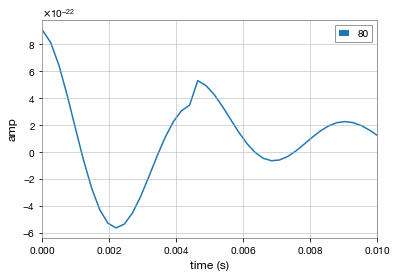

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:10 bilby INFO    : Injected signal in H1:
15:10 bilby INFO    :   optimal SNR = 15.59
15:10 bilby INFO    :   matched filter SNR = 16.77-0.24j
15:10 bilby INFO    :   frac_dw = 0.16384983607715137
15:10 bilby INFO    :   frac_dtau = 13.088445450996113
15:10 bilby INFO    :   dphi = 0
15:10 bilby INFO    :   A = 9e-22
15:10 bilby INFO    :   w = 1354.9227060562373
15:10 bilby INFO    :   t0 = 0
15:10 bilby INFO    :   phi = 0
15:10 bilby INFO    :   tau = -0.004865346632482823
15:10 bilby INFO    :   geocent_time = 0
15:10 bilby INFO    :   frac_amp = 0.2
15:10 bilby INFO    :   ra = 0
15:10 bilby INFO    :   dec = 0
15:10 bilby INFO    :   psi = 0
15:10 bilby INFO    :   ts = 0.004504426117658948
15:10 bilby INFO    : Injected s


0it [00:00, ?it/s]

15:10 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x13cbe14d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:10 bilby INFO    : Checkpoint every n_check_point = 500000
15:10 bilby INFO    : Using dynesty version 1.0.1
15:10 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:00,  1.14it/s, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-1804.76+/-0.17 dlogz:inf>0.10]
77it [00:00,  1.63it/s, bound:0 nc:1 ncall:583 eff:13.2% logz-ratio=-1273.08+/-0.17 dlogz:1647.221>0.10]
144it [00:01,  2.33it/s, bound:0 nc:1 ncall:666 eff:21.6% logz-ratio=-1052.11+/-0.15 dlogz:1421.969>0.10]
199it [00:01,  3.32it/s, bound:0 nc:1 ncall:751 eff:26.5% logz-ratio=-863.54+/-0.16 dlogz:1233.679>0.10] 
253it [00:01,  4.73it/s, bound:0 nc:5 ncall:836 eff:30.3% logz-ratio=-733.18+/-0.16 dlogz:1103.740>0.10]
308it [00:01,  6.73it/s, bound:0 nc:1 ncall:921 eff:33.4% logz-ratio=-615.75+/-0.15 dlogz:985.468>0.10] 
356it [00:01,  9.55it/s, bound:0 nc:1 ncall:1017 eff:35.0% logz-ratio=-519.95+/-0.15 dlogz:889.247>0.10]
403it [00:01, 13.50it/s, bound:0 nc:2 ncall:1115 eff:36.1% logz-ratio=-437.76+/-0.17 dlogz:808.416>0.10]
448it [00:01, 18.99it/s, bound:0 nc:1 ncall:1221 eff:36.7% logz-ratio=-379.75+/-0.16 dlogz:749.508>0.10]
491it [00:01, 26.57it/s, bound:0 nc:1 ncall:1318 eff:37.3% 

1419it [00:10, 40.47it/s, bound:0 nc:19 ncall:9041 eff:15.7% logz-ratio=83.42+/-0.16 dlogz:285.234>0.10]
1425it [00:10, 42.30it/s, bound:0 nc:33 ncall:9148 eff:15.6% logz-ratio=85.84+/-0.17 dlogz:282.711>0.10]
1430it [00:10, 40.94it/s, bound:0 nc:4 ncall:9267 eff:15.4% logz-ratio=86.98+/-0.16 dlogz:281.502>0.10] 
1435it [00:10, 38.67it/s, bound:0 nc:22 ncall:9399 eff:15.3% logz-ratio=88.17+/-0.16 dlogz:280.316>0.10]
1442it [00:11, 42.31it/s, bound:0 nc:66 ncall:9513 eff:15.2% logz-ratio=90.04+/-0.16 dlogz:278.484>0.10]
1449it [00:11, 45.49it/s, bound:0 nc:32 ncall:9625 eff:15.1% logz-ratio=91.69+/-0.16 dlogz:276.701>0.10]
1455it [00:11, 48.06it/s, bound:0 nc:18 ncall:9720 eff:15.0% logz-ratio=92.85+/-0.16 dlogz:275.579>0.10]
1461it [00:11, 42.22it/s, bound:0 nc:24 ncall:9886 eff:14.8% logz-ratio=94.23+/-0.16 dlogz:274.267>0.10]
1466it [00:11, 43.68it/s, bound:0 nc:9 ncall:9979 eff:14.7% logz-ratio=96.23+/-0.17 dlogz:272.289>0.10] 
1471it [00:11, 43.49it/s, bound:0 nc:4 ncall:10083 eff:

1750it [00:21, 22.91it/s, bound:6 nc:37 ncall:18844 eff:9.3% logz-ratio=179.40+/-0.17 dlogz:188.922>0.10]
1753it [00:21, 23.41it/s, bound:6 nc:37 ncall:18944 eff:9.3% logz-ratio=180.62+/-0.18 dlogz:187.630>0.10]
1756it [00:21, 23.14it/s, bound:7 nc:41 ncall:19053 eff:9.2% logz-ratio=181.88+/-0.18 dlogz:186.453>0.10]
1759it [00:22, 22.73it/s, bound:7 nc:36 ncall:19168 eff:9.2% logz-ratio=182.89+/-0.18 dlogz:185.322>0.10]
1762it [00:22, 22.67it/s, bound:7 nc:38 ncall:19279 eff:9.1% logz-ratio=183.85+/-0.18 dlogz:184.423>0.10]
1765it [00:22, 22.85it/s, bound:8 nc:38 ncall:19384 eff:9.1% logz-ratio=184.80+/-0.17 dlogz:183.383>0.10]
1768it [00:22, 22.26it/s, bound:8 nc:34 ncall:19499 eff:9.1% logz-ratio=185.51+/-0.17 dlogz:182.611>0.10]
1771it [00:22, 22.05it/s, bound:8 nc:41 ncall:19615 eff:9.0% logz-ratio=186.50+/-0.17 dlogz:181.741>0.10]
1774it [00:22, 21.95it/s, bound:9 nc:40 ncall:19729 eff:9.0% logz-ratio=187.56+/-0.18 dlogz:180.668>0.10]
1777it [00:22, 21.56it/s, bound:9 nc:42 ncall:

1972it [00:32, 20.37it/s, bound:33 nc:43 ncall:27433 eff:7.2% logz-ratio=236.87+/-0.17 dlogz:130.768>0.10]
1975it [00:32, 20.40it/s, bound:34 nc:41 ncall:27555 eff:7.2% logz-ratio=237.30+/-0.17 dlogz:130.315>0.10]
1978it [00:32, 20.28it/s, bound:34 nc:42 ncall:27677 eff:7.1% logz-ratio=237.68+/-0.17 dlogz:129.912>0.10]
1981it [00:32, 20.83it/s, bound:34 nc:39 ncall:27790 eff:7.1% logz-ratio=238.07+/-0.17 dlogz:129.561>0.10]
1984it [00:32, 20.79it/s, bound:35 nc:39 ncall:27910 eff:7.1% logz-ratio=238.69+/-0.17 dlogz:128.986>0.10]
1987it [00:32, 21.05it/s, bound:35 nc:42 ncall:28027 eff:7.1% logz-ratio=239.47+/-0.18 dlogz:128.304>0.10]
1990it [00:32, 21.22it/s, bound:35 nc:38 ncall:28143 eff:7.1% logz-ratio=240.26+/-0.18 dlogz:127.413>0.10]
1993it [00:33, 21.42it/s, bound:36 nc:39 ncall:28256 eff:7.1% logz-ratio=240.85+/-0.18 dlogz:126.791>0.10]
1996it [00:33, 20.80it/s, bound:36 nc:39 ncall:28385 eff:7.0% logz-ratio=241.43+/-0.17 dlogz:126.209>0.10]
1999it [00:33, 20.16it/s, bound:37 nc

2192it [00:42, 19.43it/s, bound:61 nc:45 ncall:36248 eff:6.0% logz-ratio=282.91+/-0.18 dlogz:84.654>0.10]
2194it [00:42, 19.16it/s, bound:61 nc:44 ncall:36336 eff:6.0% logz-ratio=283.15+/-0.18 dlogz:84.390>0.10]
2197it [00:42, 19.71it/s, bound:61 nc:42 ncall:36455 eff:6.0% logz-ratio=283.61+/-0.18 dlogz:83.966>0.10]
2199it [00:43, 19.25it/s, bound:62 nc:42 ncall:36541 eff:6.0% logz-ratio=283.93+/-0.18 dlogz:83.640>0.10]
2202it [00:43, 19.26it/s, bound:62 nc:45 ncall:36667 eff:6.0% logz-ratio=284.39+/-0.18 dlogz:83.174>0.10]
2205it [00:43, 20.10it/s, bound:62 nc:41 ncall:36779 eff:6.0% logz-ratio=284.92+/-0.18 dlogz:82.645>0.10]
2208it [00:43, 20.13it/s, bound:63 nc:36 ncall:36902 eff:6.0% logz-ratio=285.54+/-0.18 dlogz:82.108>0.10]
2211it [00:43, 20.14it/s, bound:63 nc:43 ncall:37028 eff:6.0% logz-ratio=286.22+/-0.18 dlogz:81.387>0.10]
2214it [00:43, 20.52it/s, bound:64 nc:39 ncall:37143 eff:6.0% logz-ratio=286.70+/-0.18 dlogz:80.824>0.10]
2217it [00:43, 20.23it/s, bound:64 nc:42 ncall

2372it [00:52, 17.30it/s, bound:84 nc:46 ncall:43828 eff:5.4% logz-ratio=307.52+/-0.18 dlogz:59.653>0.10]
2375it [00:52, 18.30it/s, bound:84 nc:37 ncall:43946 eff:5.4% logz-ratio=307.82+/-0.18 dlogz:59.337>0.10]
2377it [00:52, 18.51it/s, bound:84 nc:46 ncall:44033 eff:5.4% logz-ratio=308.02+/-0.18 dlogz:59.133>0.10]
2379it [00:52, 18.81it/s, bound:85 nc:42 ncall:44116 eff:5.4% logz-ratio=308.20+/-0.18 dlogz:58.941>0.10]
2382it [00:52, 19.36it/s, bound:85 nc:38 ncall:44237 eff:5.4% logz-ratio=308.46+/-0.18 dlogz:58.676>0.10]
2384it [00:52, 19.42it/s, bound:85 nc:45 ncall:44323 eff:5.4% logz-ratio=308.65+/-0.18 dlogz:58.490>0.10]
2387it [00:52, 19.42it/s, bound:86 nc:42 ncall:44446 eff:5.4% logz-ratio=308.93+/-0.17 dlogz:58.197>0.10]
2389it [00:52, 17.62it/s, bound:86 nc:36 ncall:44529 eff:5.4% logz-ratio=309.12+/-0.17 dlogz:58.014>0.10]
2391it [00:53, 17.73it/s, bound:86 nc:40 ncall:44601 eff:5.4% logz-ratio=309.29+/-0.17 dlogz:57.826>0.10]
2394it [00:53, 18.37it/s, bound:86 nc:41 ncall

2528it [01:01, 18.16it/s, bound:104 nc:44 ncall:50453 eff:5.0% logz-ratio=321.71+/-0.18 dlogz:45.256>0.10]
2530it [01:01, 18.48it/s, bound:105 nc:46 ncall:50537 eff:5.0% logz-ratio=321.94+/-0.18 dlogz:45.029>0.10]
2532it [01:01, 18.58it/s, bound:105 nc:44 ncall:50626 eff:5.0% logz-ratio=322.16+/-0.18 dlogz:44.803>0.10]
2534it [01:01, 18.92it/s, bound:105 nc:43 ncall:50710 eff:5.0% logz-ratio=322.43+/-0.18 dlogz:44.561>0.10]
2536it [01:01, 18.89it/s, bound:106 nc:44 ncall:50797 eff:5.0% logz-ratio=322.69+/-0.18 dlogz:44.279>0.10]
2538it [01:01, 19.08it/s, bound:106 nc:43 ncall:50883 eff:5.0% logz-ratio=322.95+/-0.18 dlogz:44.018>0.10]
2541it [01:01, 19.38it/s, bound:106 nc:42 ncall:51008 eff:5.0% logz-ratio=323.29+/-0.18 dlogz:43.656>0.10]
2543it [01:02, 19.53it/s, bound:106 nc:45 ncall:51092 eff:5.0% logz-ratio=323.52+/-0.18 dlogz:43.421>0.10]
2545it [01:02, 19.24it/s, bound:107 nc:44 ncall:51181 eff:5.0% logz-ratio=323.75+/-0.18 dlogz:43.198>0.10]
2547it [01:02, 19.09it/s, bound:107 n

2691it [01:10, 16.09it/s, bound:126 nc:42 ncall:57449 eff:4.7% logz-ratio=334.87+/-0.18 dlogz:31.751>0.10]
2693it [01:10, 15.06it/s, bound:127 nc:42 ncall:57538 eff:4.7% logz-ratio=335.01+/-0.18 dlogz:31.604>0.10]
2695it [01:10, 15.04it/s, bound:127 nc:40 ncall:57623 eff:4.7% logz-ratio=335.13+/-0.18 dlogz:31.472>0.10]
2697it [01:10, 15.01it/s, bound:127 nc:44 ncall:57711 eff:4.7% logz-ratio=335.25+/-0.18 dlogz:31.342>0.10]
2699it [01:10, 15.25it/s, bound:128 nc:44 ncall:57794 eff:4.7% logz-ratio=335.37+/-0.18 dlogz:31.217>0.10]
2701it [01:10, 15.71it/s, bound:128 nc:50 ncall:57886 eff:4.7% logz-ratio=335.50+/-0.18 dlogz:31.094>0.10]
2703it [01:10, 16.54it/s, bound:128 nc:46 ncall:57973 eff:4.7% logz-ratio=335.62+/-0.18 dlogz:30.966>0.10]
2705it [01:10, 17.22it/s, bound:128 nc:41 ncall:58059 eff:4.7% logz-ratio=335.75+/-0.18 dlogz:30.835>0.10]
2707it [01:10, 17.36it/s, bound:129 nc:47 ncall:58152 eff:4.7% logz-ratio=335.88+/-0.18 dlogz:30.700>0.10]
2709it [01:11, 17.39it/s, bound:129 n

2841it [01:19, 16.24it/s, bound:148 nc:47 ncall:64206 eff:4.4% logz-ratio=342.62+/-0.18 dlogz:23.664>0.10]
2843it [01:19, 16.42it/s, bound:148 nc:49 ncall:64302 eff:4.4% logz-ratio=342.70+/-0.18 dlogz:23.584>0.10]
2845it [01:19, 16.84it/s, bound:148 nc:42 ncall:64389 eff:4.4% logz-ratio=342.78+/-0.18 dlogz:23.499>0.10]
2847it [01:19, 16.65it/s, bound:149 nc:40 ncall:64474 eff:4.4% logz-ratio=342.86+/-0.18 dlogz:23.415>0.10]
2849it [01:19, 17.31it/s, bound:149 nc:40 ncall:64559 eff:4.4% logz-ratio=342.94+/-0.18 dlogz:23.329>0.10]
2851it [01:19, 17.99it/s, bound:149 nc:40 ncall:64641 eff:4.4% logz-ratio=343.02+/-0.18 dlogz:23.247>0.10]
2853it [01:19, 17.96it/s, bound:149 nc:47 ncall:64733 eff:4.4% logz-ratio=343.09+/-0.18 dlogz:23.167>0.10]
2855it [01:20, 17.75it/s, bound:150 nc:47 ncall:64827 eff:4.4% logz-ratio=343.16+/-0.18 dlogz:23.092>0.10]
2857it [01:20, 16.58it/s, bound:150 nc:55 ncall:64930 eff:4.4% logz-ratio=343.23+/-0.18 dlogz:23.019>0.10]
2859it [01:20, 15.65it/s, bound:150 n

2991it [01:28, 17.79it/s, bound:169 nc:48 ncall:71102 eff:4.2% logz-ratio=348.14+/-0.18 dlogz:17.836>0.10]
2993it [01:28, 17.75it/s, bound:169 nc:47 ncall:71196 eff:4.2% logz-ratio=348.21+/-0.18 dlogz:17.768>0.10]
2995it [01:28, 17.83it/s, bound:170 nc:45 ncall:71286 eff:4.2% logz-ratio=348.27+/-0.18 dlogz:17.701>0.10]
2997it [01:28, 17.72it/s, bound:170 nc:46 ncall:71379 eff:4.2% logz-ratio=348.33+/-0.18 dlogz:17.636>0.10]
2999it [01:28, 17.73it/s, bound:170 nc:46 ncall:71472 eff:4.2% logz-ratio=348.39+/-0.18 dlogz:17.573>0.10]
3001it [01:28, 17.66it/s, bound:170 nc:48 ncall:71568 eff:4.2% logz-ratio=348.44+/-0.18 dlogz:17.513>0.10]
3003it [01:28, 17.65it/s, bound:171 nc:47 ncall:71660 eff:4.2% logz-ratio=348.51+/-0.18 dlogz:17.450>0.10]
3005it [01:28, 17.60it/s, bound:171 nc:44 ncall:71754 eff:4.2% logz-ratio=348.57+/-0.18 dlogz:17.382>0.10]
3007it [01:29, 18.00it/s, bound:171 nc:43 ncall:71841 eff:4.2% logz-ratio=348.63+/-0.18 dlogz:17.315>0.10]
3009it [01:29, 17.83it/s, bound:172 n

3139it [01:36, 17.35it/s, bound:191 nc:45 ncall:78197 eff:4.0% logz-ratio=352.31+/-0.18 dlogz:13.362>0.10]
3141it [01:36, 17.30it/s, bound:191 nc:47 ncall:78294 eff:4.0% logz-ratio=352.36+/-0.18 dlogz:13.314>0.10]
3143it [01:36, 17.22it/s, bound:191 nc:49 ncall:78392 eff:4.0% logz-ratio=352.40+/-0.18 dlogz:13.266>0.10]
3145it [01:37, 17.00it/s, bound:191 nc:49 ncall:78491 eff:4.0% logz-ratio=352.44+/-0.18 dlogz:13.219>0.10]
3147it [01:37, 16.92it/s, bound:192 nc:49 ncall:78588 eff:4.0% logz-ratio=352.49+/-0.18 dlogz:13.171>0.10]
3149it [01:37, 16.99it/s, bound:192 nc:48 ncall:78685 eff:4.0% logz-ratio=352.53+/-0.18 dlogz:13.123>0.10]
3151it [01:37, 17.03it/s, bound:192 nc:50 ncall:78782 eff:4.0% logz-ratio=352.57+/-0.18 dlogz:13.076>0.10]
3153it [01:37, 17.04it/s, bound:193 nc:49 ncall:78879 eff:4.0% logz-ratio=352.62+/-0.18 dlogz:13.028>0.10]
3155it [01:37, 17.05it/s, bound:193 nc:51 ncall:78977 eff:4.0% logz-ratio=352.66+/-0.18 dlogz:12.982>0.10]
3157it [01:37, 17.09it/s, bound:193 n

3287it [01:45, 14.46it/s, bound:212 nc:51 ncall:85411 eff:3.8% logz-ratio=355.17+/-0.18 dlogz:10.235>0.10]
3289it [01:45, 14.03it/s, bound:212 nc:49 ncall:85508 eff:3.8% logz-ratio=355.20+/-0.18 dlogz:10.198>0.10]
3291it [01:45, 13.48it/s, bound:213 nc:48 ncall:85605 eff:3.8% logz-ratio=355.23+/-0.18 dlogz:10.162>0.10]
3293it [01:46, 13.45it/s, bound:213 nc:56 ncall:85711 eff:3.8% logz-ratio=355.26+/-0.18 dlogz:10.126>0.10]
3295it [01:46, 14.40it/s, bound:213 nc:48 ncall:85808 eff:3.8% logz-ratio=355.29+/-0.18 dlogz:10.090>0.10]
3297it [01:46, 14.86it/s, bound:214 nc:52 ncall:85910 eff:3.8% logz-ratio=355.33+/-0.18 dlogz:10.055>0.10]
3299it [01:46, 15.17it/s, bound:214 nc:56 ncall:86013 eff:3.8% logz-ratio=355.36+/-0.18 dlogz:10.021>0.10]
3301it [01:46, 15.24it/s, bound:214 nc:53 ncall:86115 eff:3.8% logz-ratio=355.39+/-0.18 dlogz:9.987>0.10] 
3303it [01:46, 15.70it/s, bound:215 nc:48 ncall:86213 eff:3.8% logz-ratio=355.42+/-0.18 dlogz:9.953>0.10]
3305it [01:46, 16.09it/s, bound:215 nc

3437it [01:54, 16.71it/s, bound:235 nc:49 ncall:92895 eff:3.7% logz-ratio=357.25+/-0.17 dlogz:7.849>0.10]
3439it [01:54, 16.78it/s, bound:235 nc:50 ncall:92994 eff:3.7% logz-ratio=357.27+/-0.17 dlogz:7.821>0.10]
3441it [01:55, 16.63it/s, bound:236 nc:50 ncall:93093 eff:3.7% logz-ratio=357.30+/-0.17 dlogz:7.793>0.10]
3443it [01:55, 16.67it/s, bound:236 nc:51 ncall:93193 eff:3.7% logz-ratio=357.32+/-0.17 dlogz:7.765>0.10]
3445it [01:55, 16.82it/s, bound:236 nc:49 ncall:93291 eff:3.7% logz-ratio=357.34+/-0.17 dlogz:7.738>0.10]
3447it [01:55, 16.85it/s, bound:237 nc:47 ncall:93388 eff:3.7% logz-ratio=357.37+/-0.17 dlogz:7.775>0.10]
3449it [01:55, 16.71it/s, bound:237 nc:50 ncall:93489 eff:3.7% logz-ratio=357.39+/-0.17 dlogz:7.748>0.10]
3451it [01:55, 16.58it/s, bound:237 nc:51 ncall:93590 eff:3.7% logz-ratio=357.41+/-0.17 dlogz:7.721>0.10]
3453it [01:55, 16.68it/s, bound:237 nc:49 ncall:93688 eff:3.7% logz-ratio=357.44+/-0.17 dlogz:7.694>0.10]
3455it [01:55, 15.74it/s, bound:238 nc:50 ncal

3587it [02:05, 16.49it/s, bound:259 nc:49 ncall:100442 eff:3.6% logz-ratio=358.76+/-0.17 dlogz:6.103>0.10]
3589it [02:05, 16.40it/s, bound:259 nc:51 ncall:100543 eff:3.6% logz-ratio=358.78+/-0.17 dlogz:6.082>0.10]
3591it [02:05, 16.59it/s, bound:259 nc:49 ncall:100641 eff:3.6% logz-ratio=358.79+/-0.17 dlogz:6.061>0.10]
3593it [02:05, 16.65it/s, bound:259 nc:50 ncall:100740 eff:3.6% logz-ratio=358.81+/-0.17 dlogz:6.040>0.10]
3595it [02:05, 16.65it/s, bound:260 nc:49 ncall:100838 eff:3.6% logz-ratio=358.83+/-0.17 dlogz:6.019>0.10]
3597it [02:05, 16.51it/s, bound:260 nc:51 ncall:100942 eff:3.6% logz-ratio=358.84+/-0.17 dlogz:5.998>0.10]
3599it [02:05, 16.42it/s, bound:260 nc:50 ncall:101041 eff:3.6% logz-ratio=358.86+/-0.17 dlogz:5.977>0.10]
3601it [02:06, 16.54it/s, bound:261 nc:49 ncall:101139 eff:3.6% logz-ratio=358.88+/-0.17 dlogz:5.956>0.10]
3603it [02:06, 16.42it/s, bound:261 nc:50 ncall:101238 eff:3.6% logz-ratio=358.89+/-0.17 dlogz:5.935>0.10]
3605it [02:06, 16.11it/s, bound:261 n

3735it [02:14, 16.31it/s, bound:282 nc:54 ncall:107916 eff:3.5% logz-ratio=359.87+/-0.17 dlogz:4.705>0.10]
3737it [02:14, 16.19it/s, bound:283 nc:52 ncall:108019 eff:3.5% logz-ratio=359.88+/-0.17 dlogz:4.688>0.10]
3739it [02:14, 16.37it/s, bound:283 nc:50 ncall:108118 eff:3.5% logz-ratio=359.90+/-0.17 dlogz:4.671>0.10]
3741it [02:14, 16.28it/s, bound:283 nc:49 ncall:108222 eff:3.5% logz-ratio=359.91+/-0.17 dlogz:4.654>0.10]
3743it [02:14, 16.13it/s, bound:284 nc:54 ncall:108327 eff:3.5% logz-ratio=359.92+/-0.17 dlogz:4.638>0.10]
3745it [02:14, 16.12it/s, bound:284 nc:55 ncall:108431 eff:3.5% logz-ratio=359.93+/-0.17 dlogz:4.621>0.10]
3747it [02:14, 15.95it/s, bound:284 nc:49 ncall:108529 eff:3.5% logz-ratio=359.95+/-0.17 dlogz:4.605>0.10]
3749it [02:15, 15.37it/s, bound:285 nc:52 ncall:108631 eff:3.5% logz-ratio=359.96+/-0.17 dlogz:4.588>0.10]
3751it [02:15, 15.79it/s, bound:285 nc:49 ncall:108729 eff:3.4% logz-ratio=359.97+/-0.17 dlogz:4.572>0.10]
3753it [02:15, 16.16it/s, bound:285 n

3883it [02:23, 16.31it/s, bound:306 nc:53 ncall:115354 eff:3.4% logz-ratio=360.68+/-0.17 dlogz:3.612>0.10]
3885it [02:23, 16.29it/s, bound:306 nc:49 ncall:115457 eff:3.4% logz-ratio=360.69+/-0.17 dlogz:3.598>0.10]
3887it [02:23, 16.05it/s, bound:307 nc:53 ncall:115563 eff:3.4% logz-ratio=360.70+/-0.17 dlogz:3.585>0.10]
3889it [02:23, 16.26it/s, bound:307 nc:50 ncall:115663 eff:3.4% logz-ratio=360.71+/-0.17 dlogz:3.572>0.10]
3891it [02:23, 16.12it/s, bound:307 nc:49 ncall:115765 eff:3.4% logz-ratio=360.72+/-0.17 dlogz:3.558>0.10]
3893it [02:23, 16.10it/s, bound:308 nc:53 ncall:115868 eff:3.4% logz-ratio=360.73+/-0.17 dlogz:3.545>0.10]
3895it [02:23, 16.20it/s, bound:308 nc:50 ncall:115969 eff:3.4% logz-ratio=360.74+/-0.17 dlogz:3.531>0.10]
3897it [02:24, 16.51it/s, bound:308 nc:49 ncall:116067 eff:3.4% logz-ratio=360.75+/-0.17 dlogz:3.518>0.10]
3899it [02:24, 16.52it/s, bound:309 nc:51 ncall:116167 eff:3.4% logz-ratio=360.76+/-0.17 dlogz:3.505>0.10]
3901it [02:24, 16.70it/s, bound:309 n

4031it [02:33, 17.07it/s, bound:330 nc:49 ncall:122796 eff:3.3% logz-ratio=361.35+/-0.18 dlogz:2.693>0.10]
4033it [02:33, 16.88it/s, bound:330 nc:49 ncall:122897 eff:3.3% logz-ratio=361.36+/-0.18 dlogz:2.682>0.10]
4035it [02:33, 16.76it/s, bound:330 nc:51 ncall:122997 eff:3.3% logz-ratio=361.36+/-0.18 dlogz:2.671>0.10]
4037it [02:33, 16.23it/s, bound:331 nc:54 ncall:123107 eff:3.3% logz-ratio=361.37+/-0.18 dlogz:2.660>0.10]
4039it [02:33, 15.90it/s, bound:331 nc:63 ncall:123219 eff:3.3% logz-ratio=361.38+/-0.18 dlogz:2.649>0.10]
4041it [02:33, 16.21it/s, bound:331 nc:49 ncall:123319 eff:3.3% logz-ratio=361.39+/-0.18 dlogz:2.638>0.10]
4043it [02:33, 16.12it/s, bound:332 nc:54 ncall:123424 eff:3.3% logz-ratio=361.40+/-0.18 dlogz:2.627>0.10]
4045it [02:33, 16.37it/s, bound:332 nc:49 ncall:123523 eff:3.3% logz-ratio=361.40+/-0.18 dlogz:2.615>0.10]
4047it [02:34, 16.55it/s, bound:332 nc:49 ncall:123623 eff:3.3% logz-ratio=361.41+/-0.18 dlogz:2.604>0.10]
4049it [02:34, 16.29it/s, bound:333 n

4179it [02:41, 16.64it/s, bound:353 nc:51 ncall:130272 eff:3.2% logz-ratio=361.86+/-0.18 dlogz:1.964>0.10]
4181it [02:42, 16.59it/s, bound:353 nc:52 ncall:130373 eff:3.2% logz-ratio=361.87+/-0.18 dlogz:1.955>0.10]
4183it [02:42, 16.36it/s, bound:354 nc:50 ncall:130478 eff:3.2% logz-ratio=361.87+/-0.18 dlogz:1.947>0.10]
4185it [02:42, 16.49it/s, bound:354 nc:51 ncall:130578 eff:3.2% logz-ratio=361.88+/-0.18 dlogz:1.938>0.10]
4187it [02:42, 16.32it/s, bound:354 nc:52 ncall:130684 eff:3.2% logz-ratio=361.89+/-0.18 dlogz:1.930>0.10]
4189it [02:42, 16.48it/s, bound:355 nc:49 ncall:130782 eff:3.2% logz-ratio=361.89+/-0.18 dlogz:1.921>0.10]
4191it [02:42, 16.50it/s, bound:355 nc:53 ncall:130884 eff:3.2% logz-ratio=361.90+/-0.18 dlogz:1.913>0.10]
4193it [02:42, 16.41it/s, bound:355 nc:53 ncall:130986 eff:3.2% logz-ratio=361.90+/-0.18 dlogz:1.905>0.10]
4195it [02:42, 16.47it/s, bound:356 nc:52 ncall:131087 eff:3.2% logz-ratio=361.91+/-0.18 dlogz:1.896>0.10]
4197it [02:43, 16.45it/s, bound:356 n

4327it [02:50, 16.61it/s, bound:376 nc:49 ncall:137735 eff:3.1% logz-ratio=362.23+/-0.18 dlogz:1.420>0.10]
4329it [02:51, 16.38it/s, bound:377 nc:54 ncall:137838 eff:3.1% logz-ratio=362.24+/-0.18 dlogz:1.414>0.10]
4331it [02:51, 16.60it/s, bound:377 nc:49 ncall:137936 eff:3.1% logz-ratio=362.24+/-0.18 dlogz:1.407>0.10]
4333it [02:51, 16.51it/s, bound:377 nc:49 ncall:138040 eff:3.1% logz-ratio=362.25+/-0.18 dlogz:1.401>0.10]
4335it [02:51, 16.33it/s, bound:378 nc:50 ncall:138145 eff:3.1% logz-ratio=362.25+/-0.18 dlogz:1.395>0.10]
4337it [02:51, 16.55it/s, bound:378 nc:50 ncall:138244 eff:3.1% logz-ratio=362.26+/-0.18 dlogz:1.389>0.10]
4339it [02:51, 16.69it/s, bound:378 nc:50 ncall:138344 eff:3.1% logz-ratio=362.26+/-0.18 dlogz:1.382>0.10]
4341it [02:51, 16.81it/s, bound:378 nc:50 ncall:138443 eff:3.1% logz-ratio=362.26+/-0.18 dlogz:1.376>0.10]
4343it [02:51, 16.66it/s, bound:379 nc:53 ncall:138545 eff:3.1% logz-ratio=362.27+/-0.18 dlogz:1.370>0.10]
4345it [02:51, 16.83it/s, bound:379 n

4475it [02:59, 16.83it/s, bound:400 nc:51 ncall:145162 eff:3.1% logz-ratio=362.51+/-0.18 dlogz:1.022>0.10]
4477it [02:59, 16.97it/s, bound:400 nc:49 ncall:145260 eff:3.1% logz-ratio=362.51+/-0.18 dlogz:1.017>0.10]
4479it [02:59, 16.91it/s, bound:400 nc:50 ncall:145361 eff:3.1% logz-ratio=362.51+/-0.18 dlogz:1.013>0.10]
4481it [03:00, 16.92it/s, bound:401 nc:49 ncall:145460 eff:3.1% logz-ratio=362.52+/-0.18 dlogz:1.008>0.10]
4483it [03:00, 16.88it/s, bound:401 nc:49 ncall:145561 eff:3.1% logz-ratio=362.52+/-0.18 dlogz:1.004>0.10]
4485it [03:00, 16.93it/s, bound:401 nc:51 ncall:145661 eff:3.1% logz-ratio=362.52+/-0.18 dlogz:0.999>0.10]
4487it [03:00, 16.53it/s, bound:402 nc:53 ncall:145764 eff:3.1% logz-ratio=362.52+/-0.18 dlogz:0.995>0.10]
4489it [03:00, 16.69it/s, bound:402 nc:50 ncall:145863 eff:3.1% logz-ratio=362.53+/-0.18 dlogz:0.990>0.10]
4491it [03:00, 16.79it/s, bound:402 nc:49 ncall:145962 eff:3.1% logz-ratio=362.53+/-0.18 dlogz:0.986>0.10]
4493it [03:00, 16.69it/s, bound:403 n

4623it [03:08, 16.63it/s, bound:423 nc:51 ncall:152604 eff:3.0% logz-ratio=362.71+/-0.18 dlogz:0.734>0.10]
4625it [03:08, 16.53it/s, bound:423 nc:55 ncall:152708 eff:3.0% logz-ratio=362.71+/-0.18 dlogz:0.730>0.10]
4627it [03:08, 16.18it/s, bound:424 nc:50 ncall:152811 eff:3.0% logz-ratio=362.71+/-0.18 dlogz:0.727>0.10]
4629it [03:08, 16.31it/s, bound:424 nc:49 ncall:152912 eff:3.0% logz-ratio=362.71+/-0.18 dlogz:0.724>0.10]
4631it [03:09, 16.63it/s, bound:424 nc:49 ncall:153010 eff:3.0% logz-ratio=362.72+/-0.18 dlogz:0.721>0.10]
4633it [03:09, 16.69it/s, bound:424 nc:51 ncall:153110 eff:3.0% logz-ratio=362.72+/-0.18 dlogz:0.717>0.10]
4635it [03:09, 16.49it/s, bound:425 nc:52 ncall:153214 eff:3.0% logz-ratio=362.72+/-0.18 dlogz:0.714>0.10]
4637it [03:09, 16.72it/s, bound:425 nc:49 ncall:153312 eff:3.0% logz-ratio=362.72+/-0.18 dlogz:0.711>0.10]
4639it [03:09, 16.60it/s, bound:425 nc:49 ncall:153410 eff:3.0% logz-ratio=362.72+/-0.18 dlogz:0.708>0.10]
4641it [03:09, 16.37it/s, bound:426 n

4771it [03:17, 16.75it/s, bound:447 nc:49 ncall:160049 eff:3.0% logz-ratio=362.86+/-0.18 dlogz:0.526>0.10]
4773it [03:17, 16.77it/s, bound:447 nc:49 ncall:160147 eff:3.0% logz-ratio=362.86+/-0.18 dlogz:0.524>0.10]
4775it [03:17, 16.92it/s, bound:447 nc:49 ncall:160245 eff:3.0% logz-ratio=362.86+/-0.18 dlogz:0.522>0.10]
4777it [03:17, 16.93it/s, bound:448 nc:49 ncall:160343 eff:3.0% logz-ratio=362.86+/-0.18 dlogz:0.519>0.10]
4779it [03:18, 16.99it/s, bound:448 nc:49 ncall:160441 eff:3.0% logz-ratio=362.86+/-0.18 dlogz:0.517>0.10]
4781it [03:18, 17.00it/s, bound:448 nc:50 ncall:160540 eff:3.0% logz-ratio=362.87+/-0.18 dlogz:0.515>0.10]
4783it [03:18, 17.04it/s, bound:448 nc:49 ncall:160638 eff:3.0% logz-ratio=362.87+/-0.18 dlogz:0.512>0.10]
4785it [03:18, 16.82it/s, bound:449 nc:51 ncall:160740 eff:3.0% logz-ratio=362.87+/-0.18 dlogz:0.510>0.10]
4787it [03:18, 16.76it/s, bound:449 nc:51 ncall:160840 eff:3.0% logz-ratio=362.87+/-0.18 dlogz:0.508>0.10]
4789it [03:18, 16.52it/s, bound:449 n

4919it [03:26, 16.81it/s, bound:470 nc:49 ncall:167527 eff:2.9% logz-ratio=362.97+/-0.18 dlogz:0.379>0.10]
4921it [03:26, 16.77it/s, bound:471 nc:51 ncall:167627 eff:2.9% logz-ratio=362.97+/-0.18 dlogz:0.377>0.10]
4923it [03:26, 16.84it/s, bound:471 nc:50 ncall:167726 eff:2.9% logz-ratio=362.97+/-0.18 dlogz:0.376>0.10]
4925it [03:26, 16.74it/s, bound:471 nc:50 ncall:167829 eff:2.9% logz-ratio=362.97+/-0.18 dlogz:0.374>0.10]
4927it [03:26, 16.81it/s, bound:472 nc:50 ncall:167928 eff:2.9% logz-ratio=362.97+/-0.18 dlogz:0.372>0.10]
4929it [03:27, 16.86it/s, bound:472 nc:49 ncall:168027 eff:2.9% logz-ratio=362.98+/-0.18 dlogz:0.371>0.10]
4931it [03:27, 16.87it/s, bound:472 nc:50 ncall:168126 eff:2.9% logz-ratio=362.98+/-0.18 dlogz:0.369>0.10]
4933it [03:27, 16.90it/s, bound:473 nc:49 ncall:168224 eff:2.9% logz-ratio=362.98+/-0.18 dlogz:0.367>0.10]
4935it [03:27, 16.92it/s, bound:473 nc:49 ncall:168324 eff:2.9% logz-ratio=362.98+/-0.18 dlogz:0.366>0.10]
4937it [03:27, 16.68it/s, bound:473 n

5067it [03:35, 15.14it/s, bound:494 nc:49 ncall:174959 eff:2.9% logz-ratio=363.05+/-0.18 dlogz:0.274>0.10]
5069it [03:35, 14.32it/s, bound:494 nc:49 ncall:175060 eff:2.9% logz-ratio=363.05+/-0.18 dlogz:0.273>0.10]
5071it [03:35, 13.85it/s, bound:495 nc:50 ncall:175160 eff:2.9% logz-ratio=363.05+/-0.18 dlogz:0.272>0.10]
5073it [03:36, 13.38it/s, bound:495 nc:49 ncall:175260 eff:2.9% logz-ratio=363.06+/-0.18 dlogz:0.270>0.10]
5075it [03:36, 13.27it/s, bound:495 nc:49 ncall:175358 eff:2.9% logz-ratio=363.06+/-0.18 dlogz:0.269>0.10]
5077it [03:36, 13.36it/s, bound:495 nc:52 ncall:175460 eff:2.9% logz-ratio=363.06+/-0.18 dlogz:0.268>0.10]
5079it [03:36, 14.23it/s, bound:496 nc:49 ncall:175558 eff:2.9% logz-ratio=363.06+/-0.18 dlogz:0.267>0.10]
5081it [03:36, 13.66it/s, bound:496 nc:52 ncall:175663 eff:2.9% logz-ratio=363.06+/-0.18 dlogz:0.266>0.10]
5083it [03:36, 13.28it/s, bound:496 nc:49 ncall:175762 eff:2.9% logz-ratio=363.06+/-0.18 dlogz:0.265>0.10]
5085it [03:36, 12.97it/s, bound:497 n

5215it [03:45, 14.50it/s, bound:517 nc:50 ncall:182393 eff:2.9% logz-ratio=363.11+/-0.18 dlogz:0.199>0.10]
5217it [03:46, 14.73it/s, bound:517 nc:50 ncall:182494 eff:2.9% logz-ratio=363.12+/-0.18 dlogz:0.198>0.10]
5219it [03:46, 15.18it/s, bound:518 nc:49 ncall:182592 eff:2.9% logz-ratio=363.12+/-0.18 dlogz:0.197>0.10]
5221it [03:46, 14.94it/s, bound:518 nc:49 ncall:182690 eff:2.9% logz-ratio=363.12+/-0.18 dlogz:0.197>0.10]
5223it [03:46, 15.03it/s, bound:518 nc:55 ncall:182798 eff:2.9% logz-ratio=363.12+/-0.18 dlogz:0.196>0.10]
5225it [03:46, 14.67it/s, bound:519 nc:49 ncall:182897 eff:2.9% logz-ratio=363.12+/-0.18 dlogz:0.195>0.10]
5227it [03:46, 14.35it/s, bound:519 nc:52 ncall:182999 eff:2.9% logz-ratio=363.12+/-0.18 dlogz:0.194>0.10]
5229it [03:46, 14.12it/s, bound:519 nc:49 ncall:183097 eff:2.9% logz-ratio=363.12+/-0.18 dlogz:0.193>0.10]
5231it [03:47, 14.36it/s, bound:520 nc:49 ncall:183199 eff:2.9% logz-ratio=363.12+/-0.18 dlogz:0.192>0.10]
5233it [03:47, 13.84it/s, bound:520 n

5363it [03:55, 16.20it/s, bound:540 nc:56 ncall:189823 eff:2.8% logz-ratio=363.16+/-0.18 dlogz:0.145>0.10]
5365it [03:55, 16.00it/s, bound:540 nc:57 ncall:189931 eff:2.8% logz-ratio=363.16+/-0.18 dlogz:0.145>0.10]
5367it [03:55, 16.15it/s, bound:541 nc:50 ncall:190030 eff:2.8% logz-ratio=363.16+/-0.18 dlogz:0.144>0.10]
5369it [03:55, 16.36it/s, bound:541 nc:49 ncall:190129 eff:2.8% logz-ratio=363.16+/-0.18 dlogz:0.144>0.10]
5371it [03:55, 16.33it/s, bound:541 nc:54 ncall:190232 eff:2.8% logz-ratio=363.16+/-0.18 dlogz:0.143>0.10]
5373it [03:55, 16.38it/s, bound:542 nc:49 ncall:190332 eff:2.8% logz-ratio=363.16+/-0.18 dlogz:0.142>0.10]
5375it [03:55, 16.42it/s, bound:542 nc:50 ncall:190433 eff:2.8% logz-ratio=363.16+/-0.18 dlogz:0.142>0.10]
5377it [03:56, 16.44it/s, bound:542 nc:52 ncall:190534 eff:2.8% logz-ratio=363.16+/-0.18 dlogz:0.141>0.10]
5379it [03:56, 16.49it/s, bound:543 nc:50 ncall:190633 eff:2.8% logz-ratio=363.17+/-0.18 dlogz:0.141>0.10]
5381it [03:56, 16.64it/s, bound:543 n

5511it [04:04, 16.46it/s, bound:564 nc:50 ncall:197283 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.107>0.10]
5513it [04:04, 16.54it/s, bound:564 nc:50 ncall:197383 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.106>0.10]
5515it [04:04, 16.18it/s, bound:564 nc:50 ncall:197492 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.106>0.10]
5517it [04:04, 16.31it/s, bound:565 nc:49 ncall:197592 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.105>0.10]
5519it [04:04, 16.31it/s, bound:565 nc:50 ncall:197695 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.105>0.10]
5521it [04:04, 16.26it/s, bound:565 nc:53 ncall:197799 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.104>0.10]
5523it [04:04, 16.22it/s, bound:566 nc:52 ncall:197901 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.104>0.10]
5525it [04:05, 16.41it/s, bound:566 nc:49 ncall:197999 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.104>0.10]
5527it [04:05, 16.52it/s, bound:566 nc:51 ncall:198099 eff:2.8% logz-ratio=363.20+/-0.18 dlogz:0.103>0.10]
5529it [04:05, 16.54it/s, bound:567 n

15:14 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass80_220_9_9e-22_2mode_frac0.2_resume.pickle



5541it [04:06, 22.46it/s, bound:569 nc:1 ncall:198797 eff:3.0% logz-ratio=363.30+/-0.18 dlogz:0.000>0.10] 



15:14 bilby INFO    : Sampling time: 0:04:05.206783
15:14 bilby INFO    : Summary of results:
nsamples: 6041
log_noise_evidence: -4468.507
log_evidence: -4105.211 +/-  0.176
log_bayes_factor: 363.296 +/-  0.176



GR freq is 172.51411694103783
Q freq is 28.266409781693927
frac_dw is 0.16384983607663173
{'frac_dw': 0.16384983607663173, 'frac_dtau': 13.088445451037618, 'dphi': 0, 'A': 9e-22, 'w': 1083.9381648449898, 't0': 0, 'phi': 0, 'tau': -0.006081683290603529, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.0056305326470915415}


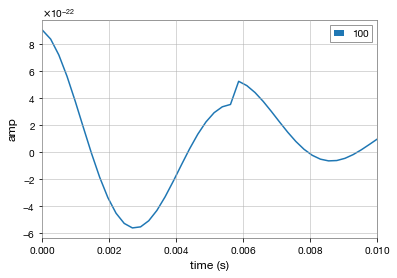

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:14 bilby INFO    : Injected signal in H1:
15:14 bilby INFO    :   optimal SNR = 12.99
15:14 bilby INFO    :   matched filter SNR = 12.26+0.47j
15:14 bilby INFO    :   frac_dw = 0.16384983607663173
15:14 bilby INFO    :   frac_dtau = 13.088445451037618
15:14 bilby INFO    :   dphi = 0
15:14 bilby INFO    :   A = 9e-22
15:14 bilby INFO    :   w = 1083.9381648449898
15:14 bilby INFO    :   t0 = 0
15:14 bilby INFO    :   phi = 0
15:14 bilby INFO    :   tau = -0.006081683290603529
15:14 bilby INFO    :   geocent_time = 0
15:14 bilby INFO    :   frac_amp = 0.2
15:14 bilby INFO    :   ra = 0
15:14 bilby INFO    :   dec = 0
15:14 bilby INFO    :   psi = 0
15:14 bilby INFO    :   ts = 0.0056305326470915415
15:14 bilby INFO    : Injected 


0it [00:00, ?it/s]

15:14 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12c6a8c90>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:14 bilby INFO    : Checkpoint every n_check_point = 400000
15:14 bilby INFO    : Using dynesty version 1.0.1
15:14 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:00,  1.11it/s, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-2147.11+/-0.17 dlogz:inf>0.10]
77it [00:01,  1.59it/s, bound:0 nc:1 ncall:580 eff:13.3% logz-ratio=-1522.46+/-0.17 dlogz:1720.967>0.10]
148it [00:01,  2.26it/s, bound:0 nc:2 ncall:663 eff:22.3% logz-ratio=-1264.74+/-0.17 dlogz:1464.957>0.10]
210it [00:01,  3.23it/s, bound:0 nc:1 ncall:745 eff:28.2% logz-ratio=-1045.04+/-0.15 dlogz:1239.979>0.10]
266it [00:01,  4.60it/s, bound:0 nc:2 ncall:828 eff:32.1% logz-ratio=-904.13+/-0.17 dlogz:1106.649>0.10] 
314it [00:01,  6.55it/s, bound:0 nc:2 ncall:922 eff:34.1% logz-ratio=-781.52+/-0.17 dlogz:983.290>0.10] 
368it [00:01,  9.30it/s, bound:0 nc:2 ncall:1004 eff:36.7% logz-ratio=-670.55+/-0.17 dlogz:871.119>0.10]
417it [00:01, 13.16it/s, bound:0 nc:2 ncall:1104 eff:37.8% logz-ratio=-553.58+/-0.16 dlogz:758.994>0.10]
466it [00:01, 18.58it/s, bound:0 nc:1 ncall:1188 eff:39.2% logz-ratio=-468.23+/-0.16 dlogz:673.548>0.10]
513it [00:01, 25.96it/s, bound:0 nc:2 ncall:1300 eff:39.5%

1443it [00:10, 48.15it/s, bound:0 nc:13 ncall:8793 eff:16.4% logz-ratio=50.97+/-0.15 dlogz:151.419>0.10]
1450it [00:10, 49.16it/s, bound:0 nc:32 ncall:8912 eff:16.3% logz-ratio=51.46+/-0.15 dlogz:150.929>0.10]
1456it [00:10, 50.44it/s, bound:0 nc:11 ncall:9010 eff:16.2% logz-ratio=51.97+/-0.15 dlogz:150.408>0.10]
1462it [00:11, 44.88it/s, bound:0 nc:28 ncall:9159 eff:16.0% logz-ratio=52.52+/-0.15 dlogz:149.846>0.10]
1470it [00:11, 46.03it/s, bound:0 nc:49 ncall:9275 eff:15.8% logz-ratio=53.17+/-0.15 dlogz:149.169>0.10]
1479it [00:11, 53.66it/s, bound:0 nc:12 ncall:9360 eff:15.8% logz-ratio=53.96+/-0.15 dlogz:148.386>0.10]
1485it [00:11, 48.34it/s, bound:0 nc:32 ncall:9492 eff:15.6% logz-ratio=54.51+/-0.15 dlogz:147.809>0.10]
1491it [00:11, 47.75it/s, bound:0 nc:28 ncall:9604 eff:15.5% logz-ratio=55.11+/-0.15 dlogz:147.208>0.10]
1499it [00:11, 53.46it/s, bound:0 nc:33 ncall:9694 eff:15.5% logz-ratio=55.73+/-0.15 dlogz:146.556>0.10]
1505it [00:11, 53.66it/s, bound:0 nc:13 ncall:9789 eff:

1802it [00:21, 21.95it/s, bound:0 nc:57 ncall:17363 eff:10.4% logz-ratio=93.57+/-0.17 dlogz:108.177>0.10]
1805it [00:21, 20.50it/s, bound:0 nc:5 ncall:17512 eff:10.3% logz-ratio=93.95+/-0.17 dlogz:107.767>0.10] 
1809it [00:21, 21.54it/s, bound:0 nc:72 ncall:17659 eff:10.2% logz-ratio=94.40+/-0.16 dlogz:107.307>0.10]
1812it [00:21, 23.16it/s, bound:0 nc:8 ncall:17753 eff:10.2% logz-ratio=94.75+/-0.16 dlogz:106.951>0.10] 
1815it [00:21, 24.23it/s, bound:0 nc:25 ncall:17851 eff:10.2% logz-ratio=95.09+/-0.16 dlogz:106.607>0.10]
1820it [00:22, 28.48it/s, bound:0 nc:6 ncall:17942 eff:10.1% logz-ratio=95.84+/-0.17 dlogz:105.885>0.10] 
1826it [00:22, 31.35it/s, bound:0 nc:50 ncall:18071 eff:10.1% logz-ratio=96.61+/-0.17 dlogz:105.058>0.10]
1830it [00:22, 29.16it/s, bound:0 nc:29 ncall:18214 eff:10.0% logz-ratio=96.98+/-0.16 dlogz:104.651>0.10]
1834it [00:22, 30.61it/s, bound:0 nc:19 ncall:18316 eff:10.0% logz-ratio=97.39+/-0.16 dlogz:104.258>0.10]
1838it [00:22, 28.96it/s, bound:1 nc:34 ncall:

2037it [00:31, 22.42it/s, bound:23 nc:29 ncall:25414 eff:8.0% logz-ratio=123.31+/-0.17 dlogz:77.996>0.10]
2040it [00:31, 22.53it/s, bound:23 nc:37 ncall:25523 eff:8.0% logz-ratio=123.76+/-0.17 dlogz:77.511>0.10]
2043it [00:31, 22.95it/s, bound:23 nc:37 ncall:25626 eff:8.0% logz-ratio=124.14+/-0.17 dlogz:77.101>0.10]
2046it [00:31, 22.65it/s, bound:24 nc:37 ncall:25735 eff:8.0% logz-ratio=124.54+/-0.17 dlogz:76.715>0.10]
2049it [00:31, 22.14it/s, bound:24 nc:34 ncall:25853 eff:7.9% logz-ratio=124.95+/-0.17 dlogz:76.294>0.10]
2052it [00:31, 22.44it/s, bound:24 nc:34 ncall:25960 eff:7.9% logz-ratio=125.34+/-0.17 dlogz:75.891>0.10]
2055it [00:32, 22.02it/s, bound:25 nc:41 ncall:26077 eff:7.9% logz-ratio=125.65+/-0.17 dlogz:75.551>0.10]
2058it [00:32, 22.54it/s, bound:25 nc:30 ncall:26177 eff:7.9% logz-ratio=125.93+/-0.17 dlogz:75.259>0.10]
2061it [00:32, 23.35it/s, bound:25 nc:30 ncall:26273 eff:7.8% logz-ratio=126.20+/-0.17 dlogz:74.982>0.10]
2064it [00:32, 23.08it/s, bound:26 nc:39 ncall

2262it [00:41, 20.76it/s, bound:50 nc:38 ncall:33992 eff:6.7% logz-ratio=149.36+/-0.17 dlogz:51.409>0.10]
2265it [00:41, 21.20it/s, bound:50 nc:37 ncall:34103 eff:6.6% logz-ratio=149.61+/-0.17 dlogz:51.152>0.10]
2268it [00:41, 21.49it/s, bound:51 nc:33 ncall:34214 eff:6.6% logz-ratio=149.87+/-0.17 dlogz:50.893>0.10]
2271it [00:42, 21.39it/s, bound:51 nc:34 ncall:34329 eff:6.6% logz-ratio=150.21+/-0.17 dlogz:50.578>0.10]
2274it [00:42, 21.45it/s, bound:51 nc:38 ncall:34445 eff:6.6% logz-ratio=150.54+/-0.17 dlogz:50.234>0.10]
2277it [00:42, 21.20it/s, bound:52 nc:43 ncall:34565 eff:6.6% logz-ratio=150.89+/-0.17 dlogz:49.883>0.10]
2280it [00:42, 20.96it/s, bound:52 nc:39 ncall:34687 eff:6.6% logz-ratio=151.24+/-0.17 dlogz:49.513>0.10]
2283it [00:42, 20.43it/s, bound:52 nc:51 ncall:34807 eff:6.6% logz-ratio=151.52+/-0.17 dlogz:49.206>0.10]
2286it [00:42, 18.85it/s, bound:53 nc:42 ncall:34936 eff:6.5% logz-ratio=151.79+/-0.17 dlogz:48.938>0.10]
2289it [00:43, 19.45it/s, bound:53 nc:41 ncall

2440it [00:51, 16.90it/s, bound:73 nc:44 ncall:41205 eff:5.9% logz-ratio=164.74+/-0.17 dlogz:35.653>0.10]
2442it [00:51, 17.37it/s, bound:73 nc:46 ncall:41294 eff:5.9% logz-ratio=164.88+/-0.17 dlogz:35.514>0.10]
2444it [00:51, 17.60it/s, bound:73 nc:40 ncall:41380 eff:5.9% logz-ratio=165.00+/-0.17 dlogz:35.379>0.10]
2446it [00:52, 16.56it/s, bound:73 nc:46 ncall:41468 eff:5.9% logz-ratio=165.13+/-0.17 dlogz:35.251>0.10]
2448it [00:52, 15.68it/s, bound:74 nc:46 ncall:41560 eff:5.9% logz-ratio=165.26+/-0.17 dlogz:35.114>0.10]
2450it [00:52, 16.52it/s, bound:74 nc:31 ncall:41624 eff:5.9% logz-ratio=165.39+/-0.17 dlogz:34.981>0.10]
2452it [00:52, 16.06it/s, bound:74 nc:41 ncall:41709 eff:5.9% logz-ratio=165.51+/-0.17 dlogz:34.855>0.10]
2454it [00:52, 15.75it/s, bound:74 nc:41 ncall:41793 eff:5.9% logz-ratio=165.63+/-0.17 dlogz:34.733>0.10]
2456it [00:52, 14.96it/s, bound:75 nc:45 ncall:41882 eff:5.9% logz-ratio=165.73+/-0.17 dlogz:34.619>0.10]
2458it [00:52, 14.49it/s, bound:75 nc:41 ncall

2599it [01:00, 17.95it/s, bound:94 nc:44 ncall:47997 eff:5.4% logz-ratio=174.27+/-0.17 dlogz:25.799>0.10]
2601it [01:00, 16.00it/s, bound:94 nc:46 ncall:48096 eff:5.4% logz-ratio=174.38+/-0.17 dlogz:25.679>0.10]
2603it [01:01, 15.24it/s, bound:94 nc:46 ncall:48189 eff:5.4% logz-ratio=174.49+/-0.17 dlogz:25.566>0.10]
2605it [01:01, 14.88it/s, bound:95 nc:41 ncall:48273 eff:5.4% logz-ratio=174.59+/-0.17 dlogz:25.458>0.10]
2607it [01:01, 15.21it/s, bound:95 nc:41 ncall:48353 eff:5.4% logz-ratio=174.69+/-0.17 dlogz:25.354>0.10]
2609it [01:01, 13.94it/s, bound:95 nc:47 ncall:48446 eff:5.4% logz-ratio=174.79+/-0.17 dlogz:25.251>0.10]
2611it [01:01, 13.68it/s, bound:95 nc:39 ncall:48531 eff:5.4% logz-ratio=174.89+/-0.17 dlogz:25.149>0.10]
2613it [01:01, 13.89it/s, bound:96 nc:44 ncall:48621 eff:5.4% logz-ratio=174.99+/-0.17 dlogz:25.046>0.10]
2615it [01:01, 14.29it/s, bound:96 nc:46 ncall:48712 eff:5.4% logz-ratio=175.08+/-0.17 dlogz:24.947>0.10]
2617it [01:02, 14.40it/s, bound:96 nc:43 ncall

2750it [01:10, 15.01it/s, bound:115 nc:45 ncall:54797 eff:5.0% logz-ratio=180.14+/-0.17 dlogz:19.603>0.10]
2752it [01:10, 15.66it/s, bound:115 nc:44 ncall:54880 eff:5.0% logz-ratio=180.21+/-0.17 dlogz:19.532>0.10]
2754it [01:10, 16.38it/s, bound:116 nc:43 ncall:54968 eff:5.0% logz-ratio=180.27+/-0.17 dlogz:19.461>0.10]
2756it [01:10, 15.80it/s, bound:116 nc:49 ncall:55067 eff:5.0% logz-ratio=180.34+/-0.17 dlogz:19.393>0.10]
2758it [01:10, 15.23it/s, bound:116 nc:45 ncall:55157 eff:5.0% logz-ratio=180.40+/-0.17 dlogz:19.325>0.10]
2760it [01:10, 15.29it/s, bound:116 nc:49 ncall:55256 eff:5.0% logz-ratio=180.47+/-0.17 dlogz:19.257>0.10]
2762it [01:10, 16.06it/s, bound:117 nc:49 ncall:55345 eff:5.0% logz-ratio=180.53+/-0.17 dlogz:19.189>0.10]
2764it [01:10, 16.65it/s, bound:117 nc:45 ncall:55437 eff:5.0% logz-ratio=180.59+/-0.17 dlogz:19.122>0.10]
2766it [01:11, 17.01it/s, bound:117 nc:41 ncall:55522 eff:5.0% logz-ratio=180.65+/-0.17 dlogz:19.057>0.10]
2768it [01:11, 16.35it/s, bound:118 n

2899it [01:19, 14.86it/s, bound:136 nc:44 ncall:61706 eff:4.7% logz-ratio=184.23+/-0.17 dlogz:15.199>0.10]
2901it [01:19, 14.25it/s, bound:137 nc:47 ncall:61805 eff:4.7% logz-ratio=184.27+/-0.17 dlogz:15.156>0.10]
2903it [01:19, 14.54it/s, bound:137 nc:48 ncall:61897 eff:4.7% logz-ratio=184.31+/-0.17 dlogz:15.113>0.10]
2905it [01:19, 15.38it/s, bound:137 nc:45 ncall:61989 eff:4.7% logz-ratio=184.35+/-0.17 dlogz:15.070>0.10]
2907it [01:19, 16.10it/s, bound:137 nc:44 ncall:62081 eff:4.7% logz-ratio=184.39+/-0.17 dlogz:15.027>0.10]
2909it [01:20, 16.71it/s, bound:138 nc:44 ncall:62170 eff:4.7% logz-ratio=184.43+/-0.17 dlogz:14.983>0.10]
2911it [01:20, 17.25it/s, bound:138 nc:43 ncall:62259 eff:4.7% logz-ratio=184.47+/-0.17 dlogz:14.939>0.10]
2913it [01:20, 16.77it/s, bound:138 nc:48 ncall:62366 eff:4.7% logz-ratio=184.51+/-0.17 dlogz:14.894>0.10]
2915it [01:20, 17.37it/s, bound:139 nc:41 ncall:62452 eff:4.7% logz-ratio=184.55+/-0.17 dlogz:14.849>0.10]
2917it [01:20, 17.59it/s, bound:139 n

3047it [01:28, 17.21it/s, bound:157 nc:48 ncall:68816 eff:4.4% logz-ratio=187.04+/-0.17 dlogz:12.089>0.10]
3049it [01:28, 17.32it/s, bound:158 nc:48 ncall:68908 eff:4.4% logz-ratio=187.07+/-0.17 dlogz:12.054>0.10]
3051it [01:28, 16.71it/s, bound:158 nc:47 ncall:69001 eff:4.4% logz-ratio=187.10+/-0.17 dlogz:12.020>0.10]
3053it [01:28, 16.75it/s, bound:158 nc:46 ncall:69097 eff:4.4% logz-ratio=187.13+/-0.17 dlogz:11.985>0.10]
3055it [01:28, 16.73it/s, bound:159 nc:47 ncall:69196 eff:4.4% logz-ratio=187.17+/-0.17 dlogz:11.951>0.10]
3057it [01:28, 17.03it/s, bound:159 nc:48 ncall:69289 eff:4.4% logz-ratio=187.20+/-0.17 dlogz:11.916>0.10]
3059it [01:29, 17.13it/s, bound:159 nc:47 ncall:69385 eff:4.4% logz-ratio=187.23+/-0.17 dlogz:11.881>0.10]
3061it [01:29, 17.28it/s, bound:159 nc:49 ncall:69481 eff:4.4% logz-ratio=187.26+/-0.17 dlogz:11.847>0.10]
3063it [01:29, 17.04it/s, bound:160 nc:52 ncall:69582 eff:4.4% logz-ratio=187.29+/-0.17 dlogz:11.813>0.10]
3065it [01:29, 16.98it/s, bound:160 n

3195it [01:37, 16.86it/s, bound:179 nc:48 ncall:76078 eff:4.2% logz-ratio=189.31+/-0.17 dlogz:9.526>0.10]
3197it [01:37, 16.76it/s, bound:180 nc:52 ncall:76179 eff:4.2% logz-ratio=189.33+/-0.17 dlogz:9.496>0.10]
3199it [01:37, 16.95it/s, bound:180 nc:50 ncall:76276 eff:4.2% logz-ratio=189.36+/-0.17 dlogz:9.466>0.10]
3201it [01:37, 16.76it/s, bound:180 nc:53 ncall:76380 eff:4.2% logz-ratio=189.39+/-0.17 dlogz:9.436>0.10]
3203it [01:37, 16.64it/s, bound:181 nc:49 ncall:76482 eff:4.2% logz-ratio=189.41+/-0.17 dlogz:9.407>0.10]
3205it [01:37, 16.77it/s, bound:181 nc:50 ncall:76580 eff:4.2% logz-ratio=189.44+/-0.17 dlogz:9.378>0.10]
3207it [01:37, 16.50it/s, bound:181 nc:51 ncall:76682 eff:4.2% logz-ratio=189.46+/-0.17 dlogz:9.349>0.10]
3209it [01:37, 16.76it/s, bound:182 nc:47 ncall:76777 eff:4.2% logz-ratio=189.49+/-0.17 dlogz:9.320>0.10]
3211it [01:37, 16.77it/s, bound:182 nc:52 ncall:76876 eff:4.2% logz-ratio=189.51+/-0.17 dlogz:9.292>0.10]
3213it [01:38, 16.78it/s, bound:182 nc:49 ncal

3345it [01:46, 14.13it/s, bound:202 nc:49 ncall:83540 eff:4.0% logz-ratio=191.18+/-0.17 dlogz:7.352>0.10]
3347it [01:46, 14.80it/s, bound:202 nc:51 ncall:83641 eff:4.0% logz-ratio=191.20+/-0.17 dlogz:7.326>0.10]
3349it [01:47, 15.27it/s, bound:203 nc:50 ncall:83741 eff:4.0% logz-ratio=191.23+/-0.17 dlogz:7.299>0.10]
3351it [01:47, 15.72it/s, bound:203 nc:49 ncall:83840 eff:4.0% logz-ratio=191.25+/-0.17 dlogz:7.273>0.10]
3353it [01:47, 15.99it/s, bound:203 nc:51 ncall:83940 eff:4.0% logz-ratio=191.27+/-0.17 dlogz:7.246>0.10]
3355it [01:47, 16.28it/s, bound:203 nc:50 ncall:84039 eff:4.0% logz-ratio=191.29+/-0.17 dlogz:7.220>0.10]
3357it [01:47, 16.39it/s, bound:204 nc:50 ncall:84138 eff:4.0% logz-ratio=191.32+/-0.17 dlogz:7.194>0.10]
3359it [01:47, 16.63it/s, bound:204 nc:49 ncall:84236 eff:4.0% logz-ratio=191.34+/-0.17 dlogz:7.168>0.10]
3361it [01:47, 16.72it/s, bound:204 nc:51 ncall:84336 eff:4.0% logz-ratio=191.36+/-0.17 dlogz:7.142>0.10]
3363it [01:47, 16.85it/s, bound:205 nc:48 ncal

3495it [01:56, 14.60it/s, bound:226 nc:51 ncall:91077 eff:3.8% logz-ratio=192.64+/-0.17 dlogz:5.597>0.10]
3497it [01:56, 15.20it/s, bound:226 nc:52 ncall:91177 eff:3.8% logz-ratio=192.65+/-0.17 dlogz:5.576>0.10]
3499it [01:56, 15.41it/s, bound:226 nc:49 ncall:91280 eff:3.8% logz-ratio=192.67+/-0.17 dlogz:5.556>0.10]
3501it [01:57, 15.28it/s, bound:227 nc:49 ncall:91385 eff:3.8% logz-ratio=192.69+/-0.17 dlogz:5.536>0.10]
3503it [01:57, 14.98it/s, bound:227 nc:49 ncall:91485 eff:3.8% logz-ratio=192.70+/-0.17 dlogz:5.516>0.10]
3505it [01:57, 14.58it/s, bound:227 nc:55 ncall:91589 eff:3.8% logz-ratio=192.72+/-0.17 dlogz:5.496>0.10]
3507it [01:57, 14.03it/s, bound:228 nc:60 ncall:91703 eff:3.8% logz-ratio=192.73+/-0.17 dlogz:5.476>0.10]
3509it [01:57, 14.77it/s, bound:228 nc:51 ncall:91803 eff:3.8% logz-ratio=192.75+/-0.17 dlogz:5.456>0.10]
3511it [01:57, 15.37it/s, bound:228 nc:50 ncall:91902 eff:3.8% logz-ratio=192.77+/-0.17 dlogz:5.436>0.10]
3513it [01:57, 15.51it/s, bound:229 nc:51 ncal

3645it [02:06, 16.23it/s, bound:249 nc:53 ncall:98616 eff:3.7% logz-ratio=193.67+/-0.17 dlogz:4.274>0.10]
3647it [02:06, 16.33it/s, bound:250 nc:51 ncall:98717 eff:3.7% logz-ratio=193.68+/-0.17 dlogz:4.258>0.10]
3649it [02:06, 16.57it/s, bound:250 nc:49 ncall:98815 eff:3.7% logz-ratio=193.70+/-0.17 dlogz:4.243>0.10]
3651it [02:06, 16.77it/s, bound:250 nc:49 ncall:98913 eff:3.7% logz-ratio=193.71+/-0.17 dlogz:4.227>0.10]
3653it [02:06, 16.82it/s, bound:251 nc:49 ncall:99011 eff:3.7% logz-ratio=193.72+/-0.17 dlogz:4.211>0.10]
3655it [02:06, 16.06it/s, bound:251 nc:49 ncall:99109 eff:3.7% logz-ratio=193.73+/-0.17 dlogz:4.196>0.10]
3657it [02:06, 16.32it/s, bound:251 nc:49 ncall:99209 eff:3.7% logz-ratio=193.74+/-0.17 dlogz:4.181>0.10]
3659it [02:06, 16.42it/s, bound:251 nc:51 ncall:99310 eff:3.7% logz-ratio=193.75+/-0.17 dlogz:4.165>0.10]
3661it [02:07, 16.50it/s, bound:252 nc:49 ncall:99410 eff:3.7% logz-ratio=193.77+/-0.17 dlogz:4.150>0.10]
3663it [02:07, 16.37it/s, bound:252 nc:54 ncal

3793it [02:15, 16.17it/s, bound:273 nc:51 ncall:106063 eff:3.6% logz-ratio=194.44+/-0.17 dlogz:3.238>0.10]
3795it [02:15, 16.36it/s, bound:273 nc:49 ncall:106162 eff:3.6% logz-ratio=194.45+/-0.17 dlogz:3.225>0.10]
3797it [02:15, 16.41it/s, bound:273 nc:51 ncall:106262 eff:3.6% logz-ratio=194.46+/-0.17 dlogz:3.212>0.10]
3799it [02:15, 16.41it/s, bound:274 nc:50 ncall:106362 eff:3.6% logz-ratio=194.46+/-0.17 dlogz:3.199>0.10]
3801it [02:15, 16.23it/s, bound:274 nc:50 ncall:106466 eff:3.6% logz-ratio=194.47+/-0.17 dlogz:3.187>0.10]
3803it [02:15, 16.34it/s, bound:274 nc:49 ncall:106564 eff:3.6% logz-ratio=194.48+/-0.17 dlogz:3.174>0.10]
3805it [02:16, 16.49it/s, bound:275 nc:49 ncall:106662 eff:3.6% logz-ratio=194.49+/-0.17 dlogz:3.161>0.10]
3807it [02:16, 16.53it/s, bound:275 nc:49 ncall:106760 eff:3.6% logz-ratio=194.50+/-0.17 dlogz:3.149>0.10]
3809it [02:16, 16.46it/s, bound:275 nc:51 ncall:106863 eff:3.6% logz-ratio=194.51+/-0.17 dlogz:3.136>0.10]
3811it [02:16, 16.49it/s, bound:276 n

3941it [02:24, 16.83it/s, bound:296 nc:50 ncall:113522 eff:3.5% logz-ratio=195.03+/-0.17 dlogz:2.399>0.10]
3943it [02:24, 16.79it/s, bound:297 nc:49 ncall:113620 eff:3.5% logz-ratio=195.04+/-0.17 dlogz:2.389>0.10]
3945it [02:24, 16.52it/s, bound:297 nc:54 ncall:113726 eff:3.5% logz-ratio=195.05+/-0.17 dlogz:2.379>0.10]
3947it [02:24, 16.57it/s, bound:297 nc:51 ncall:113828 eff:3.5% logz-ratio=195.05+/-0.17 dlogz:2.369>0.10]
3949it [02:24, 16.60it/s, bound:298 nc:51 ncall:113928 eff:3.5% logz-ratio=195.06+/-0.17 dlogz:2.359>0.10]
3951it [02:24, 16.62it/s, bound:298 nc:51 ncall:114029 eff:3.5% logz-ratio=195.07+/-0.17 dlogz:2.349>0.10]
3953it [02:25, 16.69it/s, bound:298 nc:49 ncall:114128 eff:3.5% logz-ratio=195.08+/-0.17 dlogz:2.339>0.10]
3955it [02:25, 16.61it/s, bound:299 nc:52 ncall:114229 eff:3.5% logz-ratio=195.08+/-0.17 dlogz:2.330>0.10]
3957it [02:25, 16.71it/s, bound:299 nc:49 ncall:114328 eff:3.5% logz-ratio=195.09+/-0.17 dlogz:2.320>0.10]
3959it [02:25, 16.50it/s, bound:299 n

4089it [02:33, 16.25it/s, bound:320 nc:49 ncall:120981 eff:3.4% logz-ratio=195.49+/-0.17 dlogz:1.744>0.10]
4091it [02:33, 16.43it/s, bound:320 nc:49 ncall:121081 eff:3.4% logz-ratio=195.49+/-0.17 dlogz:1.736>0.10]
4093it [02:33, 16.43it/s, bound:320 nc:49 ncall:121182 eff:3.4% logz-ratio=195.50+/-0.17 dlogz:1.729>0.10]
4095it [02:33, 16.40it/s, bound:320 nc:52 ncall:121283 eff:3.4% logz-ratio=195.51+/-0.17 dlogz:1.721>0.10]
4097it [02:33, 16.08it/s, bound:321 nc:51 ncall:121388 eff:3.4% logz-ratio=195.51+/-0.17 dlogz:1.714>0.10]
4099it [02:33, 15.90it/s, bound:321 nc:51 ncall:121488 eff:3.4% logz-ratio=195.52+/-0.17 dlogz:1.708>0.10]
4101it [02:33, 15.95it/s, bound:321 nc:51 ncall:121588 eff:3.4% logz-ratio=195.52+/-0.17 dlogz:1.700>0.10]
4103it [02:34, 15.72it/s, bound:322 nc:58 ncall:121695 eff:3.4% logz-ratio=195.53+/-0.17 dlogz:1.693>0.10]
4105it [02:34, 15.78it/s, bound:322 nc:51 ncall:121797 eff:3.4% logz-ratio=195.53+/-0.17 dlogz:1.685>0.10]
4107it [02:34, 15.91it/s, bound:322 n

4237it [02:42, 16.47it/s, bound:343 nc:50 ncall:128461 eff:3.3% logz-ratio=195.82+/-0.17 dlogz:1.258>0.10]
4239it [02:42, 16.54it/s, bound:343 nc:50 ncall:128561 eff:3.3% logz-ratio=195.83+/-0.17 dlogz:1.252>0.10]
4241it [02:42, 16.46it/s, bound:344 nc:49 ncall:128660 eff:3.3% logz-ratio=195.83+/-0.17 dlogz:1.247>0.10]
4243it [02:42, 16.54it/s, bound:344 nc:49 ncall:128760 eff:3.3% logz-ratio=195.84+/-0.17 dlogz:1.241>0.10]
4245it [02:42, 16.51it/s, bound:344 nc:49 ncall:128860 eff:3.3% logz-ratio=195.84+/-0.17 dlogz:1.235>0.10]
4247it [02:42, 16.62it/s, bound:344 nc:50 ncall:128959 eff:3.3% logz-ratio=195.84+/-0.17 dlogz:1.230>0.10]
4249it [02:42, 16.36it/s, bound:345 nc:50 ncall:129065 eff:3.3% logz-ratio=195.85+/-0.17 dlogz:1.224>0.10]
4251it [02:43, 16.50it/s, bound:345 nc:49 ncall:129165 eff:3.3% logz-ratio=195.85+/-0.17 dlogz:1.219>0.10]
4253it [02:43, 16.55it/s, bound:345 nc:51 ncall:129266 eff:3.3% logz-ratio=195.85+/-0.17 dlogz:1.214>0.10]
4255it [02:43, 16.66it/s, bound:346 n

4385it [02:51, 16.54it/s, bound:367 nc:50 ncall:135947 eff:3.2% logz-ratio=196.07+/-0.17 dlogz:0.902>0.10]
4387it [02:51, 16.74it/s, bound:367 nc:49 ncall:136045 eff:3.2% logz-ratio=196.07+/-0.17 dlogz:0.898>0.10]
4389it [02:51, 16.76it/s, bound:367 nc:52 ncall:136146 eff:3.2% logz-ratio=196.08+/-0.17 dlogz:0.893>0.10]
4391it [02:51, 16.68it/s, bound:368 nc:51 ncall:136247 eff:3.2% logz-ratio=196.08+/-0.17 dlogz:0.889>0.10]
4393it [02:51, 16.80it/s, bound:368 nc:50 ncall:136346 eff:3.2% logz-ratio=196.08+/-0.17 dlogz:0.885>0.10]
4395it [02:51, 16.79it/s, bound:368 nc:50 ncall:136447 eff:3.2% logz-ratio=196.09+/-0.17 dlogz:0.881>0.10]
4397it [02:51, 16.84it/s, bound:369 nc:49 ncall:136545 eff:3.2% logz-ratio=196.09+/-0.17 dlogz:0.877>0.10]
4399it [02:52, 16.91it/s, bound:369 nc:49 ncall:136644 eff:3.2% logz-ratio=196.09+/-0.17 dlogz:0.873>0.10]
4401it [02:52, 16.96it/s, bound:369 nc:49 ncall:136742 eff:3.2% logz-ratio=196.09+/-0.17 dlogz:0.869>0.10]
4403it [02:52, 16.86it/s, bound:370 n

4533it [03:00, 16.50it/s, bound:390 nc:49 ncall:143415 eff:3.2% logz-ratio=196.26+/-0.17 dlogz:0.643>0.10]
4535it [03:00, 16.65it/s, bound:390 nc:50 ncall:143514 eff:3.2% logz-ratio=196.26+/-0.17 dlogz:0.640>0.10]
4537it [03:00, 16.68it/s, bound:391 nc:50 ncall:143613 eff:3.2% logz-ratio=196.26+/-0.17 dlogz:0.637>0.10]
4539it [03:00, 16.81it/s, bound:391 nc:49 ncall:143711 eff:3.2% logz-ratio=196.27+/-0.17 dlogz:0.634>0.10]
4541it [03:00, 16.87it/s, bound:391 nc:49 ncall:143810 eff:3.2% logz-ratio=196.27+/-0.17 dlogz:0.632>0.10]
4543it [03:00, 16.82it/s, bound:392 nc:49 ncall:143908 eff:3.2% logz-ratio=196.27+/-0.17 dlogz:0.629>0.10]
4545it [03:00, 16.53it/s, bound:392 nc:51 ncall:144011 eff:3.2% logz-ratio=196.27+/-0.17 dlogz:0.626>0.10]
4547it [03:01, 15.16it/s, bound:392 nc:49 ncall:144119 eff:3.2% logz-ratio=196.27+/-0.17 dlogz:0.623>0.10]
4549it [03:01, 14.69it/s, bound:393 nc:49 ncall:144217 eff:3.2% logz-ratio=196.28+/-0.17 dlogz:0.620>0.10]
4551it [03:01, 14.22it/s, bound:393 n

4681it [03:09, 16.63it/s, bound:414 nc:49 ncall:150890 eff:3.1% logz-ratio=196.40+/-0.17 dlogz:0.461>0.10]
4683it [03:09, 16.43it/s, bound:414 nc:55 ncall:150996 eff:3.1% logz-ratio=196.40+/-0.17 dlogz:0.459>0.10]
4685it [03:09, 16.39it/s, bound:415 nc:53 ncall:151098 eff:3.1% logz-ratio=196.40+/-0.17 dlogz:0.457>0.10]
4687it [03:09, 16.58it/s, bound:415 nc:49 ncall:151196 eff:3.1% logz-ratio=196.40+/-0.17 dlogz:0.455>0.10]
4689it [03:09, 16.59it/s, bound:415 nc:51 ncall:151296 eff:3.1% logz-ratio=196.40+/-0.17 dlogz:0.453>0.10]
4691it [03:10, 16.57it/s, bound:416 nc:52 ncall:151397 eff:3.1% logz-ratio=196.40+/-0.17 dlogz:0.451>0.10]
4693it [03:10, 16.48it/s, bound:416 nc:55 ncall:151501 eff:3.1% logz-ratio=196.41+/-0.17 dlogz:0.449>0.10]
4695it [03:10, 16.60it/s, bound:416 nc:49 ncall:151601 eff:3.1% logz-ratio=196.41+/-0.17 dlogz:0.447>0.10]
4697it [03:10, 16.42it/s, bound:417 nc:54 ncall:151705 eff:3.1% logz-ratio=196.41+/-0.17 dlogz:0.445>0.10]
4699it [03:10, 16.37it/s, bound:417 n

4829it [03:18, 16.61it/s, bound:437 nc:49 ncall:158320 eff:3.1% logz-ratio=196.50+/-0.17 dlogz:0.332>0.10]
4831it [03:18, 16.65it/s, bound:437 nc:49 ncall:158418 eff:3.0% logz-ratio=196.50+/-0.17 dlogz:0.330>0.10]
4833it [03:18, 16.71it/s, bound:438 nc:49 ncall:158516 eff:3.0% logz-ratio=196.50+/-0.17 dlogz:0.329>0.10]
4835it [03:18, 16.81it/s, bound:438 nc:49 ncall:158614 eff:3.0% logz-ratio=196.50+/-0.17 dlogz:0.328>0.10]
4837it [03:18, 16.93it/s, bound:438 nc:49 ncall:158712 eff:3.0% logz-ratio=196.50+/-0.17 dlogz:0.326>0.10]
4839it [03:19, 16.66it/s, bound:439 nc:50 ncall:158815 eff:3.0% logz-ratio=196.50+/-0.17 dlogz:0.325>0.10]
4841it [03:19, 16.51it/s, bound:439 nc:50 ncall:158919 eff:3.0% logz-ratio=196.50+/-0.17 dlogz:0.323>0.10]
4843it [03:19, 16.57it/s, bound:439 nc:51 ncall:159019 eff:3.0% logz-ratio=196.50+/-0.17 dlogz:0.322>0.10]
4845it [03:19, 16.55it/s, bound:440 nc:49 ncall:159119 eff:3.0% logz-ratio=196.51+/-0.17 dlogz:0.320>0.10]
4847it [03:19, 16.48it/s, bound:440 n

4977it [03:27, 16.86it/s, bound:460 nc:49 ncall:165747 eff:3.0% logz-ratio=196.57+/-0.17 dlogz:0.240>0.10]
4979it [03:27, 16.89it/s, bound:460 nc:49 ncall:165847 eff:3.0% logz-ratio=196.57+/-0.17 dlogz:0.239>0.10]
4981it [03:27, 16.77it/s, bound:461 nc:50 ncall:165948 eff:3.0% logz-ratio=196.57+/-0.17 dlogz:0.238>0.10]
4983it [03:27, 16.76it/s, bound:461 nc:52 ncall:166049 eff:3.0% logz-ratio=196.57+/-0.17 dlogz:0.237>0.10]
4985it [03:27, 16.79it/s, bound:461 nc:49 ncall:166149 eff:3.0% logz-ratio=196.58+/-0.17 dlogz:0.236>0.10]
4987it [03:27, 16.58it/s, bound:462 nc:49 ncall:166253 eff:3.0% logz-ratio=196.58+/-0.17 dlogz:0.235>0.10]
4989it [03:28, 16.47it/s, bound:462 nc:49 ncall:166357 eff:3.0% logz-ratio=196.58+/-0.17 dlogz:0.234>0.10]
4991it [03:28, 16.60it/s, bound:462 nc:51 ncall:166457 eff:3.0% logz-ratio=196.58+/-0.17 dlogz:0.233>0.10]
4993it [03:28, 16.62it/s, bound:463 nc:49 ncall:166556 eff:3.0% logz-ratio=196.58+/-0.17 dlogz:0.232>0.10]
4995it [03:28, 16.70it/s, bound:463 n

5125it [03:36, 14.58it/s, bound:483 nc:51 ncall:173189 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.175>0.10]
5127it [03:36, 13.70it/s, bound:484 nc:50 ncall:173288 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.174>0.10]
5129it [03:36, 14.35it/s, bound:484 nc:50 ncall:173388 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.173>0.10]
5131it [03:36, 15.01it/s, bound:484 nc:49 ncall:173487 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.173>0.10]
5133it [03:37, 15.22it/s, bound:485 nc:52 ncall:173588 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.172>0.10]
5135it [03:37, 15.64it/s, bound:485 nc:51 ncall:173688 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.171>0.10]
5137it [03:37, 15.35it/s, bound:485 nc:63 ncall:173802 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.171>0.10]
5139it [03:37, 15.56it/s, bound:486 nc:50 ncall:173902 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.170>0.10]
5141it [03:37, 15.75it/s, bound:486 nc:55 ncall:174006 eff:3.0% logz-ratio=196.63+/-0.17 dlogz:0.169>0.10]
5143it [03:37, 15.86it/s, bound:486 n

5273it [03:45, 16.70it/s, bound:507 nc:49 ncall:180674 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.128>0.10]
5275it [03:45, 16.78it/s, bound:507 nc:49 ncall:180774 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.127>0.10]
5277it [03:45, 16.62it/s, bound:508 nc:52 ncall:180875 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.127>0.10]
5279it [03:45, 16.58it/s, bound:508 nc:54 ncall:180978 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.126>0.10]
5281it [03:46, 16.75it/s, bound:508 nc:49 ncall:181077 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.126>0.10]
5283it [03:46, 16.63it/s, bound:509 nc:51 ncall:181179 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.125>0.10]
5285it [03:46, 16.49it/s, bound:509 nc:51 ncall:181283 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.125>0.10]
5287it [03:46, 16.44it/s, bound:509 nc:50 ncall:181388 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.124>0.10]
5289it [03:46, 16.41it/s, bound:510 nc:50 ncall:181488 eff:2.9% logz-ratio=196.67+/-0.17 dlogz:0.124>0.10]
5291it [03:46, 16.45it/s, bound:510 n

15:18 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass100_220_9_9e-22_2mode_frac0.2_resume.pickle



5391it [03:53, 23.06it/s, bound:526 nc:1 ncall:186627 eff:3.2% logz-ratio=196.79+/-0.17 dlogz:0.000>0.10] 



15:18 bilby INFO    : Sampling time: 0:03:52.205599
15:18 bilby INFO    : Summary of results:
nsamples: 5891
log_noise_evidence: -4275.190
log_evidence: -4078.401 +/-  0.172
log_bayes_factor: 196.789 +/-  0.172



GR freq is 143.7617641175315
Q freq is 23.555341484704364
frac_dw is 0.1638498360763495
{'frac_dw': 0.1638498360763495, 'frac_dtau': 13.088445451060162, 'dphi': 0, 'A': 9e-22, 'w': 903.2818040374914, 't0': 0, 'phi': 0, 'tau': -0.007298019948724235, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.0067566391765214884}


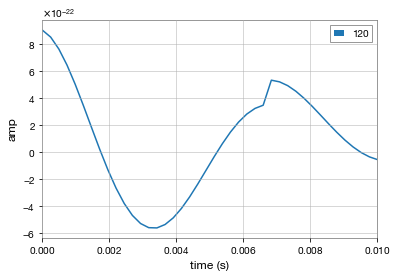

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:18 bilby INFO    : Injected signal in H1:
15:18 bilby INFO    :   optimal SNR = 10.88
15:18 bilby INFO    :   matched filter SNR = 11.24+0.51j
15:18 bilby INFO    :   frac_dw = 0.1638498360763495
15:18 bilby INFO    :   frac_dtau = 13.088445451060162
15:18 bilby INFO    :   dphi = 0
15:18 bilby INFO    :   A = 9e-22
15:18 bilby INFO    :   w = 903.2818040374914
15:18 bilby INFO    :   t0 = 0
15:18 bilby INFO    :   phi = 0
15:18 bilby INFO    :   tau = -0.007298019948724235
15:18 bilby INFO    :   geocent_time = 0
15:18 bilby INFO    :   frac_amp = 0.2
15:18 bilby INFO    :   ra = 0
15:18 bilby INFO    :   dec = 0
15:18 bilby INFO    :   psi = 0
15:18 bilby INFO    :   ts = 0.0067566391765214884
15:18 bilby INFO    : Injected si


0it [00:00, ?it/s]

15:18 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x13cb5bb90>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:18 bilby INFO    : Checkpoint every n_check_point = 400000
15:18 bilby INFO    : Using dynesty version 1.0.1
15:18 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:01,  1.01s/it, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-2408.80+/-0.17 dlogz:inf>0.10]
62it [00:01,  1.42it/s, bound:0 nc:1 ncall:566 eff:11.0% logz-ratio=-1782.52+/-0.17 dlogz:1916.540>0.10]
115it [00:01,  2.03it/s, bound:0 nc:1 ncall:629 eff:18.3% logz-ratio=-1474.60+/-0.17 dlogz:1603.095>0.10]
168it [00:01,  2.89it/s, bound:0 nc:2 ncall:700 eff:24.0% logz-ratio=-1206.53+/-0.15 dlogz:1331.785>0.10]
207it [00:01,  4.11it/s, bound:0 nc:3 ncall:765 eff:27.1% logz-ratio=-1054.02+/-0.17 dlogz:1181.591>0.10]
244it [00:01,  5.85it/s, bound:0 nc:1 ncall:831 eff:29.4% logz-ratio=-881.16+/-0.17 dlogz:1016.818>0.10] 
287it [00:01,  8.31it/s, bound:0 nc:1 ncall:902 eff:31.8% logz-ratio=-767.39+/-0.15 dlogz:893.021>0.10] 
327it [00:01, 11.76it/s, bound:0 nc:5 ncall:986 eff:33.2% logz-ratio=-675.25+/-0.16 dlogz:801.222>0.10]
366it [00:01, 16.57it/s, bound:0 nc:1 ncall:1054 eff:34.7% logz-ratio=-579.55+/-0.17 dlogz:706.510>0.10]
404it [00:01, 23.17it/s, bound:0 nc:1 ncall:1136 eff:35.6%

1380it [00:10, 46.37it/s, bound:0 nc:2 ncall:7726 eff:17.9% logz-ratio=37.64+/-0.13 dlogz:87.795>0.10]
1389it [00:10, 52.92it/s, bound:0 nc:14 ncall:7827 eff:17.7% logz-ratio=37.89+/-0.13 dlogz:87.525>0.10]
1395it [00:10, 53.82it/s, bound:0 nc:4 ncall:7922 eff:17.6% logz-ratio=38.08+/-0.13 dlogz:87.330>0.10] 
1401it [00:10, 40.42it/s, bound:0 nc:15 ncall:8135 eff:17.2% logz-ratio=38.28+/-0.13 dlogz:87.117>0.10]
1409it [00:11, 47.23it/s, bound:0 nc:6 ncall:8224 eff:17.1% logz-ratio=38.59+/-0.13 dlogz:86.797>0.10] 
1419it [00:11, 52.56it/s, bound:0 nc:37 ncall:8332 eff:17.0% logz-ratio=39.00+/-0.14 dlogz:86.361>0.10]
1426it [00:11, 51.67it/s, bound:0 nc:2 ncall:8455 eff:16.9% logz-ratio=39.28+/-0.14 dlogz:86.174>0.10] 
1432it [00:11, 51.34it/s, bound:0 nc:15 ncall:8559 eff:16.7% logz-ratio=39.50+/-0.14 dlogz:85.947>0.10]
1438it [00:11, 43.39it/s, bound:0 nc:7 ncall:8727 eff:16.5% logz-ratio=39.71+/-0.14 dlogz:85.718>0.10] 
1443it [00:11, 40.63it/s, bound:0 nc:12 ncall:8853 eff:16.3% logz

1778it [00:21, 17.24it/s, bound:0 nc:49 ncall:17699 eff:10.0% logz-ratio=62.56+/-0.16 dlogz:62.239>0.10]
1781it [00:21, 19.74it/s, bound:0 nc:47 ncall:17789 eff:10.0% logz-ratio=62.79+/-0.16 dlogz:62.003>0.10]
1787it [00:21, 23.68it/s, bound:1 nc:41 ncall:17905 eff:10.0% logz-ratio=63.30+/-0.16 dlogz:61.484>0.10]
1791it [00:22, 23.49it/s, bound:1 nc:35 ncall:18048 eff:9.9% logz-ratio=63.65+/-0.16 dlogz:61.129>0.10] 
1794it [00:22, 23.60it/s, bound:1 nc:32 ncall:18149 eff:9.9% logz-ratio=63.91+/-0.16 dlogz:60.867>0.10]
1797it [00:22, 24.40it/s, bound:2 nc:24 ncall:18239 eff:9.9% logz-ratio=64.19+/-0.16 dlogz:60.578>0.10]
1800it [00:22, 23.89it/s, bound:2 nc:37 ncall:18348 eff:9.8% logz-ratio=64.46+/-0.16 dlogz:60.298>0.10]
1803it [00:22, 23.94it/s, bound:2 nc:32 ncall:18451 eff:9.8% logz-ratio=64.81+/-0.16 dlogz:59.976>0.10]
1806it [00:22, 22.99it/s, bound:3 nc:38 ncall:18568 eff:9.7% logz-ratio=65.16+/-0.16 dlogz:59.617>0.10]
1809it [00:22, 22.65it/s, bound:3 nc:38 ncall:18682 eff:9.7%

2010it [00:31, 22.36it/s, bound:26 nc:38 ncall:25958 eff:7.7% logz-ratio=81.53+/-0.16 dlogz:42.828>0.10]
2013it [00:31, 22.45it/s, bound:26 nc:39 ncall:26067 eff:7.7% logz-ratio=81.74+/-0.16 dlogz:42.602>0.10]
2016it [00:32, 22.63it/s, bound:26 nc:38 ncall:26173 eff:7.7% logz-ratio=81.96+/-0.16 dlogz:42.372>0.10]
2019it [00:32, 20.85it/s, bound:27 nc:37 ncall:26283 eff:7.7% logz-ratio=82.19+/-0.16 dlogz:42.153>0.10]
2022it [00:32, 19.37it/s, bound:27 nc:35 ncall:26399 eff:7.7% logz-ratio=82.42+/-0.16 dlogz:41.913>0.10]
2024it [00:32, 19.10it/s, bound:27 nc:33 ncall:26471 eff:7.6% logz-ratio=82.58+/-0.16 dlogz:41.754>0.10]
2026it [00:32, 19.17it/s, bound:28 nc:41 ncall:26553 eff:7.6% logz-ratio=82.73+/-0.16 dlogz:41.590>0.10]
2029it [00:32, 19.75it/s, bound:28 nc:34 ncall:26667 eff:7.6% logz-ratio=82.95+/-0.16 dlogz:41.359>0.10]
2032it [00:32, 20.13it/s, bound:28 nc:40 ncall:26785 eff:7.6% logz-ratio=83.16+/-0.16 dlogz:41.144>0.10]
2035it [00:33, 20.08it/s, bound:29 nc:42 ncall:26907 ef

2233it [00:42, 20.19it/s, bound:53 nc:42 ncall:34598 eff:6.5% logz-ratio=95.46+/-0.16 dlogz:28.425>0.10]
2236it [00:42, 20.01it/s, bound:53 nc:42 ncall:34723 eff:6.4% logz-ratio=95.64+/-0.16 dlogz:28.251>0.10]
2239it [00:42, 20.05it/s, bound:54 nc:44 ncall:34844 eff:6.4% logz-ratio=95.82+/-0.17 dlogz:28.061>0.10]
2242it [00:42, 19.84it/s, bound:54 nc:40 ncall:34971 eff:6.4% logz-ratio=95.99+/-0.17 dlogz:27.881>0.10]
2244it [00:43, 19.53it/s, bound:54 nc:38 ncall:35058 eff:6.4% logz-ratio=96.10+/-0.17 dlogz:27.767>0.10]
2246it [00:43, 19.63it/s, bound:55 nc:38 ncall:35136 eff:6.4% logz-ratio=96.20+/-0.16 dlogz:27.656>0.10]
2249it [00:43, 19.80it/s, bound:55 nc:42 ncall:35260 eff:6.4% logz-ratio=96.36+/-0.16 dlogz:27.494>0.10]
2252it [00:43, 19.65it/s, bound:55 nc:48 ncall:35389 eff:6.4% logz-ratio=96.52+/-0.16 dlogz:27.332>0.10]
2255it [00:43, 20.31it/s, bound:56 nc:36 ncall:35500 eff:6.4% logz-ratio=96.68+/-0.16 dlogz:27.159>0.10]
2258it [00:43, 19.91it/s, bound:56 nc:43 ncall:35632 ef

2414it [00:51, 18.89it/s, bound:77 nc:43 ncall:42185 eff:5.7% logz-ratio=102.78+/-0.16 dlogz:20.727>0.10]
2416it [00:51, 18.55it/s, bound:77 nc:47 ncall:42276 eff:5.7% logz-ratio=102.84+/-0.16 dlogz:20.658>0.10]
2419it [00:52, 18.81it/s, bound:77 nc:47 ncall:42406 eff:5.7% logz-ratio=102.95+/-0.16 dlogz:20.549>0.10]
2421it [00:52, 18.63it/s, bound:78 nc:45 ncall:42496 eff:5.7% logz-ratio=103.02+/-0.16 dlogz:20.474>0.10]
2423it [00:52, 18.62it/s, bound:78 nc:47 ncall:42585 eff:5.7% logz-ratio=103.09+/-0.16 dlogz:20.400>0.10]
2425it [00:52, 18.85it/s, bound:78 nc:43 ncall:42671 eff:5.7% logz-ratio=103.16+/-0.16 dlogz:20.326>0.10]
2428it [00:52, 19.40it/s, bound:78 nc:44 ncall:42793 eff:5.7% logz-ratio=103.26+/-0.16 dlogz:20.218>0.10]
2430it [00:52, 19.06it/s, bound:79 nc:43 ncall:42882 eff:5.7% logz-ratio=103.32+/-0.16 dlogz:20.150>0.10]
2432it [00:52, 19.14it/s, bound:79 nc:40 ncall:42968 eff:5.7% logz-ratio=103.38+/-0.16 dlogz:20.083>0.10]
2435it [00:52, 19.77it/s, bound:79 nc:40 ncall

2570it [01:00, 17.59it/s, bound:99 nc:48 ncall:49268 eff:5.2% logz-ratio=107.25+/-0.16 dlogz:15.934>0.10]
2572it [01:00, 17.53it/s, bound:99 nc:49 ncall:49365 eff:5.2% logz-ratio=107.31+/-0.16 dlogz:15.877>0.10]
2574it [01:00, 17.79it/s, bound:99 nc:45 ncall:49455 eff:5.2% logz-ratio=107.37+/-0.16 dlogz:15.816>0.10]
2576it [01:00, 17.69it/s, bound:99 nc:47 ncall:49551 eff:5.2% logz-ratio=107.42+/-0.16 dlogz:15.754>0.10]
2578it [01:00, 18.07it/s, bound:100 nc:46 ncall:49638 eff:5.2% logz-ratio=107.48+/-0.16 dlogz:15.696>0.10]
2580it [01:00, 17.43it/s, bound:100 nc:52 ncall:49738 eff:5.2% logz-ratio=107.53+/-0.16 dlogz:15.638>0.10]
2582it [01:01, 17.51it/s, bound:100 nc:49 ncall:49833 eff:5.2% logz-ratio=107.58+/-0.16 dlogz:15.582>0.10]
2584it [01:01, 17.46it/s, bound:101 nc:50 ncall:49927 eff:5.2% logz-ratio=107.63+/-0.16 dlogz:15.526>0.10]
2586it [01:01, 17.60it/s, bound:101 nc:49 ncall:50021 eff:5.2% logz-ratio=107.68+/-0.16 dlogz:15.471>0.10]
2588it [01:01, 17.41it/s, bound:101 nc:46

2718it [01:08, 16.76it/s, bound:120 nc:50 ncall:56387 eff:4.8% logz-ratio=110.50+/-0.16 dlogz:12.386>0.10]
2720it [01:09, 17.01it/s, bound:120 nc:48 ncall:56483 eff:4.8% logz-ratio=110.54+/-0.16 dlogz:12.341>0.10]
2722it [01:09, 17.09it/s, bound:121 nc:47 ncall:56579 eff:4.8% logz-ratio=110.58+/-0.16 dlogz:12.298>0.10]
2724it [01:09, 17.26it/s, bound:121 nc:47 ncall:56675 eff:4.8% logz-ratio=110.62+/-0.16 dlogz:12.255>0.10]
2726it [01:09, 17.34it/s, bound:121 nc:50 ncall:56771 eff:4.8% logz-ratio=110.66+/-0.16 dlogz:12.212>0.10]
2728it [01:09, 17.24it/s, bound:121 nc:47 ncall:56865 eff:4.8% logz-ratio=110.69+/-0.16 dlogz:12.170>0.10]
2730it [01:09, 17.12it/s, bound:122 nc:53 ncall:56962 eff:4.8% logz-ratio=110.73+/-0.16 dlogz:12.129>0.10]
2732it [01:09, 17.15it/s, bound:122 nc:49 ncall:57060 eff:4.8% logz-ratio=110.77+/-0.16 dlogz:12.089>0.10]
2734it [01:09, 17.18it/s, bound:122 nc:49 ncall:57158 eff:4.8% logz-ratio=110.80+/-0.16 dlogz:12.049>0.10]
2736it [01:09, 17.13it/s, bound:123 n

2866it [01:18, 16.92it/s, bound:141 nc:48 ncall:63608 eff:4.5% logz-ratio=112.87+/-0.16 dlogz:9.719>0.10]
2868it [01:18, 16.79it/s, bound:142 nc:50 ncall:63709 eff:4.5% logz-ratio=112.90+/-0.16 dlogz:9.686>0.10]
2870it [01:18, 16.87it/s, bound:142 nc:51 ncall:63808 eff:4.5% logz-ratio=112.92+/-0.16 dlogz:9.652>0.10]
2872it [01:18, 16.96it/s, bound:142 nc:48 ncall:63906 eff:4.5% logz-ratio=112.95+/-0.16 dlogz:9.619>0.10]
2874it [01:18, 16.79it/s, bound:143 nc:50 ncall:64006 eff:4.5% logz-ratio=112.98+/-0.16 dlogz:9.585>0.10]
2876it [01:18, 16.83it/s, bound:143 nc:49 ncall:64105 eff:4.5% logz-ratio=113.01+/-0.16 dlogz:9.551>0.10]
2878it [01:18, 16.62it/s, bound:143 nc:49 ncall:64208 eff:4.5% logz-ratio=113.04+/-0.16 dlogz:9.518>0.10]
2880it [01:19, 16.74it/s, bound:144 nc:48 ncall:64304 eff:4.5% logz-ratio=113.07+/-0.16 dlogz:9.486>0.10]
2882it [01:19, 16.90it/s, bound:144 nc:47 ncall:64401 eff:4.5% logz-ratio=113.10+/-0.16 dlogz:9.453>0.10]
2884it [01:19, 16.82it/s, bound:144 nc:52 ncal

3016it [01:27, 16.79it/s, bound:164 nc:49 ncall:71047 eff:4.2% logz-ratio=114.76+/-0.16 dlogz:7.550>0.10]
3018it [01:27, 17.08it/s, bound:164 nc:46 ncall:71142 eff:4.2% logz-ratio=114.78+/-0.16 dlogz:7.524>0.10]
3020it [01:27, 16.96it/s, bound:164 nc:52 ncall:71243 eff:4.2% logz-ratio=114.80+/-0.16 dlogz:7.498>0.10]
3022it [01:27, 16.95it/s, bound:165 nc:50 ncall:71342 eff:4.2% logz-ratio=114.83+/-0.16 dlogz:7.472>0.10]
3024it [01:27, 17.00it/s, bound:165 nc:49 ncall:71440 eff:4.2% logz-ratio=114.85+/-0.16 dlogz:7.446>0.10]
3026it [01:27, 16.97it/s, bound:165 nc:49 ncall:71540 eff:4.2% logz-ratio=114.87+/-0.16 dlogz:7.420>0.10]
3028it [01:28, 16.92it/s, bound:165 nc:49 ncall:71638 eff:4.2% logz-ratio=114.89+/-0.16 dlogz:7.394>0.10]
3030it [01:28, 16.82it/s, bound:166 nc:49 ncall:71737 eff:4.2% logz-ratio=114.91+/-0.16 dlogz:7.369>0.10]
3032it [01:28, 16.50it/s, bound:166 nc:58 ncall:71844 eff:4.2% logz-ratio=114.94+/-0.16 dlogz:7.343>0.10]
3034it [01:28, 16.69it/s, bound:166 nc:49 ncal

3166it [01:36, 16.72it/s, bound:187 nc:49 ncall:78561 eff:4.0% logz-ratio=116.20+/-0.16 dlogz:5.806>0.10]
3168it [01:36, 16.60it/s, bound:188 nc:49 ncall:78663 eff:4.0% logz-ratio=116.22+/-0.16 dlogz:5.786>0.10]
3170it [01:36, 16.70it/s, bound:188 nc:50 ncall:78762 eff:4.0% logz-ratio=116.24+/-0.16 dlogz:5.765>0.10]
3172it [01:36, 16.81it/s, bound:188 nc:50 ncall:78861 eff:4.0% logz-ratio=116.25+/-0.16 dlogz:5.745>0.10]
3174it [01:36, 16.45it/s, bound:188 nc:56 ncall:78968 eff:4.0% logz-ratio=116.27+/-0.16 dlogz:5.724>0.10]
3176it [01:36, 16.59it/s, bound:189 nc:49 ncall:79066 eff:4.0% logz-ratio=116.29+/-0.16 dlogz:5.704>0.10]
3178it [01:37, 16.56it/s, bound:189 nc:50 ncall:79169 eff:4.0% logz-ratio=116.30+/-0.16 dlogz:5.683>0.10]
3180it [01:37, 16.75it/s, bound:189 nc:49 ncall:79267 eff:4.0% logz-ratio=116.32+/-0.16 dlogz:5.663>0.10]
3182it [01:37, 16.67it/s, bound:190 nc:50 ncall:79369 eff:4.0% logz-ratio=116.34+/-0.16 dlogz:5.643>0.10]
3184it [01:37, 16.85it/s, bound:190 nc:49 ncal

3316it [01:45, 14.60it/s, bound:211 nc:51 ncall:86134 eff:3.8% logz-ratio=117.25+/-0.16 dlogz:4.471>0.10]
3318it [01:46, 13.75it/s, bound:211 nc:49 ncall:86245 eff:3.8% logz-ratio=117.26+/-0.16 dlogz:4.455>0.10]
3320it [01:46, 13.54it/s, bound:211 nc:49 ncall:86344 eff:3.8% logz-ratio=117.27+/-0.16 dlogz:4.440>0.10]
3322it [01:46, 13.43it/s, bound:212 nc:50 ncall:86443 eff:3.8% logz-ratio=117.28+/-0.16 dlogz:4.424>0.10]
3324it [01:46, 13.44it/s, bound:212 nc:50 ncall:86544 eff:3.8% logz-ratio=117.29+/-0.16 dlogz:4.409>0.10]
3326it [01:46, 13.41it/s, bound:212 nc:49 ncall:86643 eff:3.8% logz-ratio=117.30+/-0.16 dlogz:4.393>0.10]
3328it [01:46, 13.07it/s, bound:213 nc:59 ncall:86752 eff:3.8% logz-ratio=117.32+/-0.16 dlogz:4.378>0.10]
3330it [01:46, 13.85it/s, bound:213 nc:56 ncall:86857 eff:3.8% logz-ratio=117.33+/-0.16 dlogz:4.363>0.10]
3332it [01:47, 14.52it/s, bound:213 nc:50 ncall:86959 eff:3.8% logz-ratio=117.34+/-0.16 dlogz:4.347>0.10]
3334it [01:47, 15.07it/s, bound:214 nc:49 ncal

3466it [01:56, 15.00it/s, bound:235 nc:49 ncall:93720 eff:3.7% logz-ratio=118.02+/-0.16 dlogz:3.417>0.10]
3468it [01:56, 15.37it/s, bound:235 nc:51 ncall:93823 eff:3.7% logz-ratio=118.03+/-0.16 dlogz:3.404>0.10]
3470it [01:56, 15.60it/s, bound:235 nc:50 ncall:93927 eff:3.7% logz-ratio=118.04+/-0.16 dlogz:3.392>0.10]
3472it [01:56, 15.75it/s, bound:236 nc:54 ncall:94030 eff:3.7% logz-ratio=118.05+/-0.16 dlogz:3.380>0.10]
3474it [01:56, 16.04it/s, bound:236 nc:51 ncall:94130 eff:3.7% logz-ratio=118.06+/-0.16 dlogz:3.367>0.10]
3476it [01:56, 15.15it/s, bound:236 nc:56 ncall:94235 eff:3.7% logz-ratio=118.06+/-0.16 dlogz:3.355>0.10]
3478it [01:56, 13.94it/s, bound:237 nc:50 ncall:94334 eff:3.7% logz-ratio=118.07+/-0.16 dlogz:3.342>0.10]
3480it [01:57, 13.94it/s, bound:237 nc:50 ncall:94433 eff:3.7% logz-ratio=118.08+/-0.16 dlogz:3.330>0.10]
3482it [01:57, 13.45it/s, bound:237 nc:51 ncall:94533 eff:3.7% logz-ratio=118.09+/-0.16 dlogz:3.318>0.10]
3484it [01:57, 13.62it/s, bound:238 nc:49 ncal

3616it [02:05, 16.66it/s, bound:258 nc:50 ncall:101259 eff:3.6% logz-ratio=118.63+/-0.16 dlogz:2.557>0.10]
3618it [02:05, 16.70it/s, bound:259 nc:50 ncall:101358 eff:3.6% logz-ratio=118.63+/-0.16 dlogz:2.547>0.10]
3620it [02:05, 16.72it/s, bound:259 nc:49 ncall:101459 eff:3.6% logz-ratio=118.64+/-0.16 dlogz:2.537>0.10]
3622it [02:05, 16.73it/s, bound:259 nc:49 ncall:101557 eff:3.6% logz-ratio=118.65+/-0.16 dlogz:2.527>0.10]
3624it [02:05, 16.43it/s, bound:260 nc:51 ncall:101663 eff:3.6% logz-ratio=118.66+/-0.16 dlogz:2.517>0.10]
3626it [02:05, 16.38it/s, bound:260 nc:52 ncall:101768 eff:3.6% logz-ratio=118.66+/-0.16 dlogz:2.506>0.10]
3628it [02:06, 16.42it/s, bound:260 nc:49 ncall:101871 eff:3.6% logz-ratio=118.67+/-0.16 dlogz:2.496>0.10]
3630it [02:06, 16.25it/s, bound:261 nc:52 ncall:101975 eff:3.6% logz-ratio=118.68+/-0.16 dlogz:2.486>0.10]
3632it [02:06, 16.50it/s, bound:261 nc:49 ncall:102073 eff:3.6% logz-ratio=118.68+/-0.16 dlogz:2.476>0.10]
3634it [02:06, 16.73it/s, bound:261 n

3764it [02:14, 16.71it/s, bound:282 nc:49 ncall:108714 eff:3.5% logz-ratio=119.09+/-0.16 dlogz:1.885>0.10]
3766it [02:14, 16.81it/s, bound:282 nc:49 ncall:108813 eff:3.5% logz-ratio=119.09+/-0.16 dlogz:1.877>0.10]
3768it [02:14, 16.81it/s, bound:282 nc:50 ncall:108913 eff:3.5% logz-ratio=119.10+/-0.16 dlogz:1.869>0.10]
3770it [02:14, 16.78it/s, bound:283 nc:49 ncall:109013 eff:3.5% logz-ratio=119.10+/-0.16 dlogz:1.861>0.10]
3772it [02:14, 16.82it/s, bound:283 nc:49 ncall:109114 eff:3.5% logz-ratio=119.11+/-0.16 dlogz:1.853>0.10]
3774it [02:14, 16.76it/s, bound:283 nc:49 ncall:109216 eff:3.5% logz-ratio=119.11+/-0.16 dlogz:1.845>0.10]
3776it [02:14, 16.70it/s, bound:284 nc:50 ncall:109315 eff:3.5% logz-ratio=119.12+/-0.16 dlogz:1.837>0.10]
3778it [02:15, 16.64it/s, bound:284 nc:50 ncall:109416 eff:3.5% logz-ratio=119.12+/-0.16 dlogz:1.830>0.10]
3780it [02:15, 16.66it/s, bound:284 nc:50 ncall:109516 eff:3.5% logz-ratio=119.13+/-0.16 dlogz:1.822>0.10]
3782it [02:15, 16.60it/s, bound:285 n

3912it [02:23, 15.44it/s, bound:305 nc:49 ncall:116147 eff:3.4% logz-ratio=119.43+/-0.16 dlogz:1.372>0.10]
3914it [02:23, 15.78it/s, bound:306 nc:50 ncall:116247 eff:3.4% logz-ratio=119.44+/-0.16 dlogz:1.366>0.10]
3916it [02:23, 16.03it/s, bound:306 nc:49 ncall:116346 eff:3.4% logz-ratio=119.44+/-0.16 dlogz:1.360>0.10]
3918it [02:23, 16.33it/s, bound:306 nc:49 ncall:116444 eff:3.4% logz-ratio=119.45+/-0.16 dlogz:1.354>0.10]
3920it [02:23, 16.52it/s, bound:307 nc:49 ncall:116542 eff:3.4% logz-ratio=119.45+/-0.16 dlogz:1.348>0.10]
3922it [02:23, 16.57it/s, bound:307 nc:51 ncall:116642 eff:3.4% logz-ratio=119.45+/-0.16 dlogz:1.342>0.10]
3924it [02:23, 16.75it/s, bound:307 nc:49 ncall:116740 eff:3.4% logz-ratio=119.46+/-0.16 dlogz:1.336>0.10]
3926it [02:24, 16.74it/s, bound:307 nc:49 ncall:116841 eff:3.4% logz-ratio=119.46+/-0.16 dlogz:1.331>0.10]
3928it [02:24, 16.62it/s, bound:308 nc:49 ncall:116942 eff:3.4% logz-ratio=119.47+/-0.16 dlogz:1.325>0.10]
3930it [02:24, 16.80it/s, bound:308 n

4060it [02:32, 16.86it/s, bound:328 nc:49 ncall:123555 eff:3.3% logz-ratio=119.70+/-0.16 dlogz:0.983>0.10]
4062it [02:33, 16.59it/s, bound:329 nc:55 ncall:123659 eff:3.3% logz-ratio=119.71+/-0.16 dlogz:0.979>0.10]
4064it [02:33, 16.54it/s, bound:329 nc:52 ncall:123760 eff:3.3% logz-ratio=119.71+/-0.16 dlogz:0.974>0.10]
4066it [02:33, 15.18it/s, bound:329 nc:49 ncall:123861 eff:3.3% logz-ratio=119.71+/-0.16 dlogz:0.970>0.10]
4068it [02:33, 14.12it/s, bound:330 nc:49 ncall:123959 eff:3.3% logz-ratio=119.71+/-0.16 dlogz:0.965>0.10]
4070it [02:33, 13.63it/s, bound:330 nc:50 ncall:124060 eff:3.3% logz-ratio=119.72+/-0.16 dlogz:0.961>0.10]
4072it [02:33, 12.78it/s, bound:330 nc:51 ncall:124163 eff:3.3% logz-ratio=119.72+/-0.16 dlogz:0.957>0.10]
4074it [02:33, 12.68it/s, bound:331 nc:50 ncall:124263 eff:3.3% logz-ratio=119.72+/-0.16 dlogz:0.952>0.10]
4076it [02:34, 12.61it/s, bound:331 nc:51 ncall:124365 eff:3.3% logz-ratio=119.73+/-0.16 dlogz:0.948>0.10]
4078it [02:34, 13.49it/s, bound:331 n

4208it [02:42, 16.71it/s, bound:352 nc:49 ncall:130976 eff:3.2% logz-ratio=119.90+/-0.17 dlogz:0.701>0.10]
4210it [02:42, 16.84it/s, bound:352 nc:49 ncall:131075 eff:3.2% logz-ratio=119.91+/-0.17 dlogz:0.698>0.10]
4212it [02:42, 16.92it/s, bound:352 nc:49 ncall:131174 eff:3.2% logz-ratio=119.91+/-0.17 dlogz:0.695>0.10]
4214it [02:42, 16.87it/s, bound:353 nc:50 ncall:131273 eff:3.2% logz-ratio=119.91+/-0.17 dlogz:0.692>0.10]
4216it [02:42, 16.91it/s, bound:353 nc:50 ncall:131372 eff:3.2% logz-ratio=119.91+/-0.17 dlogz:0.689>0.10]
4218it [02:43, 16.97it/s, bound:353 nc:49 ncall:131471 eff:3.2% logz-ratio=119.92+/-0.17 dlogz:0.685>0.10]
4220it [02:43, 17.02it/s, bound:353 nc:50 ncall:131570 eff:3.2% logz-ratio=119.92+/-0.17 dlogz:0.682>0.10]
4222it [02:43, 17.00it/s, bound:354 nc:49 ncall:131668 eff:3.2% logz-ratio=119.92+/-0.17 dlogz:0.679>0.10]
4224it [02:43, 16.98it/s, bound:354 nc:50 ncall:131767 eff:3.2% logz-ratio=119.92+/-0.17 dlogz:0.676>0.10]
4226it [02:43, 17.02it/s, bound:354 n

4356it [02:52, 16.36it/s, bound:375 nc:49 ncall:138432 eff:3.1% logz-ratio=120.05+/-0.17 dlogz:0.502>0.10]
4358it [02:52, 16.36it/s, bound:376 nc:49 ncall:138533 eff:3.1% logz-ratio=120.06+/-0.17 dlogz:0.499>0.10]
4360it [02:52, 16.39it/s, bound:376 nc:54 ncall:138636 eff:3.1% logz-ratio=120.06+/-0.17 dlogz:0.497>0.10]
4362it [02:52, 16.63it/s, bound:376 nc:49 ncall:138734 eff:3.1% logz-ratio=120.06+/-0.17 dlogz:0.495>0.10]
4364it [02:52, 16.70it/s, bound:377 nc:49 ncall:138833 eff:3.1% logz-ratio=120.06+/-0.17 dlogz:0.493>0.10]
4366it [02:52, 16.80it/s, bound:377 nc:49 ncall:138932 eff:3.1% logz-ratio=120.06+/-0.17 dlogz:0.491>0.10]
4368it [02:52, 16.93it/s, bound:377 nc:49 ncall:139030 eff:3.1% logz-ratio=120.06+/-0.17 dlogz:0.488>0.10]
4370it [02:53, 16.80it/s, bound:378 nc:51 ncall:139131 eff:3.1% logz-ratio=120.07+/-0.17 dlogz:0.486>0.10]
4372it [02:53, 16.67it/s, bound:378 nc:51 ncall:139232 eff:3.1% logz-ratio=120.07+/-0.17 dlogz:0.484>0.10]
4374it [02:53, 16.78it/s, bound:378 n

4504it [03:01, 16.66it/s, bound:399 nc:50 ncall:145912 eff:3.1% logz-ratio=120.16+/-0.17 dlogz:0.361>0.10]
4506it [03:01, 16.78it/s, bound:400 nc:49 ncall:146010 eff:3.1% logz-ratio=120.17+/-0.17 dlogz:0.359>0.10]
4508it [03:01, 16.84it/s, bound:400 nc:49 ncall:146110 eff:3.1% logz-ratio=120.17+/-0.17 dlogz:0.357>0.10]
4510it [03:01, 16.73it/s, bound:400 nc:49 ncall:146208 eff:3.1% logz-ratio=120.17+/-0.17 dlogz:0.356>0.10]
4512it [03:01, 16.61it/s, bound:400 nc:53 ncall:146311 eff:3.1% logz-ratio=120.17+/-0.17 dlogz:0.354>0.10]
4514it [03:01, 16.62it/s, bound:401 nc:49 ncall:146409 eff:3.1% logz-ratio=120.17+/-0.17 dlogz:0.353>0.10]
4516it [03:02, 16.34it/s, bound:401 nc:53 ncall:146511 eff:3.1% logz-ratio=120.17+/-0.17 dlogz:0.351>0.10]
4518it [03:02, 16.53it/s, bound:401 nc:50 ncall:146611 eff:3.1% logz-ratio=120.17+/-0.17 dlogz:0.350>0.10]
4520it [03:02, 16.49it/s, bound:402 nc:49 ncall:146710 eff:3.1% logz-ratio=120.17+/-0.17 dlogz:0.348>0.10]
4522it [03:02, 16.26it/s, bound:402 n

4652it [03:10, 16.14it/s, bound:423 nc:51 ncall:153380 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.261>0.10]
4654it [03:10, 16.22it/s, bound:423 nc:54 ncall:153484 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.260>0.10]
4656it [03:10, 16.48it/s, bound:423 nc:50 ncall:153583 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.258>0.10]
4658it [03:10, 16.36it/s, bound:424 nc:55 ncall:153687 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.257>0.10]
4660it [03:10, 16.53it/s, bound:424 nc:49 ncall:153787 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.256>0.10]
4662it [03:10, 16.63it/s, bound:424 nc:51 ncall:153888 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.255>0.10]
4664it [03:10, 16.69it/s, bound:425 nc:50 ncall:153987 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.254>0.10]
4666it [03:11, 16.30it/s, bound:425 nc:49 ncall:154086 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.253>0.10]
4668it [03:11, 16.25it/s, bound:425 nc:49 ncall:154184 eff:3.0% logz-ratio=120.25+/-0.17 dlogz:0.252>0.10]
4670it [03:11, 16.33it/s, bound:426 n

4800it [03:19, 16.96it/s, bound:446 nc:50 ncall:160817 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.189>0.10]
4802it [03:19, 16.86it/s, bound:447 nc:51 ncall:160918 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.189>0.10]
4804it [03:19, 16.70it/s, bound:447 nc:54 ncall:161022 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.188>0.10]
4806it [03:19, 16.85it/s, bound:447 nc:50 ncall:161121 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.187>0.10]
4808it [03:19, 16.69it/s, bound:448 nc:52 ncall:161223 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.186>0.10]
4810it [03:19, 16.28it/s, bound:448 nc:55 ncall:161331 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.185>0.10]
4812it [03:19, 16.30it/s, bound:448 nc:50 ncall:161435 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.185>0.10]
4814it [03:19, 16.33it/s, bound:449 nc:52 ncall:161537 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.184>0.10]
4816it [03:20, 16.41it/s, bound:449 nc:52 ncall:161638 eff:3.0% logz-ratio=120.31+/-0.17 dlogz:0.183>0.10]
4818it [03:20, 16.49it/s, bound:449 n

4948it [03:27, 16.71it/s, bound:469 nc:53 ncall:168250 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.138>0.10]
4950it [03:28, 16.70it/s, bound:470 nc:50 ncall:168350 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.138>0.10]
4952it [03:28, 16.28it/s, bound:470 nc:50 ncall:168461 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.137>0.10]
4954it [03:28, 16.42it/s, bound:470 nc:49 ncall:168563 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.137>0.10]
4956it [03:28, 16.28it/s, bound:471 nc:56 ncall:168668 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.136>0.10]
4958it [03:28, 16.39it/s, bound:471 nc:51 ncall:168770 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.135>0.10]
4960it [03:28, 16.53it/s, bound:471 nc:49 ncall:168870 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.135>0.10]
4962it [03:28, 16.65it/s, bound:472 nc:50 ncall:168969 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.134>0.10]
4964it [03:28, 16.68it/s, bound:472 nc:50 ncall:169070 eff:2.9% logz-ratio=120.35+/-0.17 dlogz:0.134>0.10]
4966it [03:29, 16.74it/s, bound:472 n

5096it [03:36, 16.91it/s, bound:493 nc:49 ncall:175721 eff:2.9% logz-ratio=120.38+/-0.17 dlogz:0.102>0.10]
5098it [03:37, 17.04it/s, bound:493 nc:49 ncall:175819 eff:2.9% logz-ratio=120.38+/-0.17 dlogz:0.101>0.10]
5100it [03:37, 17.09it/s, bound:493 nc:49 ncall:175917 eff:2.9% logz-ratio=120.38+/-0.17 dlogz:0.101>0.10]
5102it [03:37, 16.98it/s, bound:494 nc:50 ncall:176017 eff:2.9% logz-ratio=120.39+/-0.17 dlogz:0.100>0.10]

15:22 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass120_220_9_9e-22_2mode_frac0.2_resume.pickle



5103it [03:37, 23.41it/s, bound:494 nc:1 ncall:176066 eff:3.2% logz-ratio=120.48+/-0.17 dlogz:0.000>0.10] 



15:22 bilby INFO    : Sampling time: 0:03:36.316711
15:22 bilby INFO    : Summary of results:
nsamples: 5603
log_noise_evidence: -4212.355
log_evidence: -4091.874 +/-  0.165
log_bayes_factor: 120.481 +/-  0.165



GR freq is 123.22436924359845
Q freq is 20.1902927011542
frac_dw is 0.16384983607617934
{'frac_dw': 0.16384983607617934, 'frac_dtau': 13.088445451073758, 'dphi': 0, 'A': 9e-22, 'w': 774.2415463178498, 't0': 0, 'phi': 0, 'tau': -0.00851435660684494, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.007882745705949924}


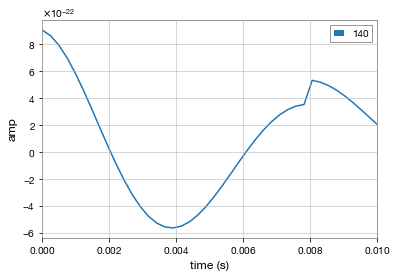

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:22 bilby INFO    : Injected signal in H1:
15:22 bilby INFO    :   optimal SNR = 8.72
15:22 bilby INFO    :   matched filter SNR = 8.21-0.53j
15:22 bilby INFO    :   frac_dw = 0.16384983607617934
15:22 bilby INFO    :   frac_dtau = 13.088445451073758
15:22 bilby INFO    :   dphi = 0
15:22 bilby INFO    :   A = 9e-22
15:22 bilby INFO    :   w = 774.2415463178498
15:22 bilby INFO    :   t0 = 0
15:22 bilby INFO    :   phi = 0
15:22 bilby INFO    :   tau = -0.00851435660684494
15:22 bilby INFO    :   geocent_time = 0
15:22 bilby INFO    :   frac_amp = 0.2
15:22 bilby INFO    :   ra = 0
15:22 bilby INFO    :   dec = 0
15:22 bilby INFO    :   psi = 0
15:22 bilby INFO    :   ts = 0.007882745705949924
15:22 bilby INFO    : Injected signa


0it [00:00, ?it/s]

15:22 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x13a796bd0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:22 bilby INFO    : Checkpoint every n_check_point = 400000
15:22 bilby INFO    : Using dynesty version 1.0.1
15:22 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:01,  1.17s/it, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-2643.55+/-0.17 dlogz:inf>0.10]
54it [00:01,  1.22it/s, bound:0 nc:1 ncall:555 eff:9.7% logz-ratio=-2007.57+/-0.17 dlogz:2120.734>0.10]
107it [00:01,  1.74it/s, bound:0 nc:1 ncall:613 eff:17.5% logz-ratio=-1602.41+/-0.16 dlogz:1705.627>0.10]
154it [00:01,  2.49it/s, bound:0 nc:1 ncall:675 eff:22.8% logz-ratio=-1255.91+/-0.16 dlogz:1359.415>0.10]
187it [00:01,  3.54it/s, bound:0 nc:1 ncall:727 eff:25.7% logz-ratio=-1077.89+/-0.17 dlogz:1191.257>0.10]
224it [00:01,  5.04it/s, bound:0 nc:1 ncall:783 eff:28.6% logz-ratio=-931.65+/-0.17 dlogz:1037.290>0.10] 
259it [00:01,  7.15it/s, bound:0 nc:1 ncall:843 eff:30.7% logz-ratio=-806.22+/-0.17 dlogz:915.850>0.10] 
294it [00:01, 10.13it/s, bound:0 nc:1 ncall:907 eff:32.4% logz-ratio=-727.55+/-0.16 dlogz:829.550>0.10]
328it [00:01, 14.26it/s, bound:0 nc:1 ncall:980 eff:33.5% logz-ratio=-619.01+/-0.16 dlogz:721.064>0.10]
361it [00:02, 19.93it/s, bound:0 nc:1 ncall:1045 eff:34.5% l

1399it [00:10, 68.38it/s, bound:0 nc:19 ncall:8044 eff:17.4% logz-ratio=51.00+/-0.13 dlogz:47.859>0.10]
1407it [00:10, 69.01it/s, bound:0 nc:16 ncall:8146 eff:17.3% logz-ratio=51.18+/-0.13 dlogz:47.653>0.10]
1415it [00:10, 45.54it/s, bound:0 nc:35 ncall:8433 eff:16.8% logz-ratio=51.36+/-0.13 dlogz:47.459>0.10]
1421it [00:11, 35.20it/s, bound:0 nc:71 ncall:8672 eff:16.4% logz-ratio=51.50+/-0.13 dlogz:47.307>0.10]
1429it [00:11, 40.89it/s, bound:0 nc:48 ncall:8781 eff:16.3% logz-ratio=51.69+/-0.13 dlogz:47.104>0.10]
1435it [00:11, 37.19it/s, bound:0 nc:7 ncall:8958 eff:16.0% logz-ratio=51.83+/-0.13 dlogz:46.950>0.10] 
1441it [00:11, 37.93it/s, bound:0 nc:77 ncall:9094 eff:15.8% logz-ratio=51.97+/-0.13 dlogz:46.800>0.10]
1446it [00:11, 39.92it/s, bound:0 nc:9 ncall:9192 eff:15.7% logz-ratio=52.09+/-0.13 dlogz:46.677>0.10] 
1451it [00:11, 42.49it/s, bound:0 nc:27 ncall:9280 eff:15.6% logz-ratio=52.21+/-0.13 dlogz:46.544>0.10]
1457it [00:12, 39.25it/s, bound:0 nc:83 ncall:9442 eff:15.4% log

1819it [00:21, 25.29it/s, bound:0 nc:82 ncall:18183 eff:10.0% logz-ratio=61.78+/-0.14 dlogz:36.239>0.10]
1822it [00:21, 24.28it/s, bound:1 nc:44 ncall:18295 eff:10.0% logz-ratio=61.87+/-0.14 dlogz:36.146>0.10]
1825it [00:22, 23.53it/s, bound:1 nc:34 ncall:18407 eff:9.9% logz-ratio=61.95+/-0.14 dlogz:36.056>0.10] 
1828it [00:22, 23.52it/s, bound:1 nc:40 ncall:18510 eff:9.9% logz-ratio=62.04+/-0.14 dlogz:35.967>0.10]
1831it [00:22, 22.92it/s, bound:2 nc:37 ncall:18624 eff:9.8% logz-ratio=62.12+/-0.14 dlogz:35.878>0.10]
1834it [00:22, 22.53it/s, bound:2 nc:42 ncall:18740 eff:9.8% logz-ratio=62.21+/-0.14 dlogz:35.783>0.10]
1837it [00:22, 22.63it/s, bound:2 nc:37 ncall:18850 eff:9.7% logz-ratio=62.29+/-0.14 dlogz:35.689>0.10]
1840it [00:22, 23.22it/s, bound:3 nc:33 ncall:18949 eff:9.7% logz-ratio=62.38+/-0.14 dlogz:35.600>0.10]
1843it [00:22, 22.04it/s, bound:3 nc:39 ncall:19072 eff:9.7% logz-ratio=62.46+/-0.14 dlogz:35.511>0.10]
1846it [00:23, 22.36it/s, bound:3 nc:31 ncall:19180 eff:9.6% 

2047it [00:32, 21.12it/s, bound:27 nc:43 ncall:26860 eff:7.6% logz-ratio=68.79+/-0.15 dlogz:28.771>0.10]
2050it [00:32, 21.38it/s, bound:28 nc:29 ncall:26972 eff:7.6% logz-ratio=68.88+/-0.15 dlogz:28.719>0.10]
2053it [00:32, 21.49it/s, bound:28 nc:41 ncall:27086 eff:7.6% logz-ratio=68.97+/-0.15 dlogz:28.625>0.10]
2056it [00:32, 21.02it/s, bound:29 nc:40 ncall:27204 eff:7.6% logz-ratio=69.05+/-0.15 dlogz:28.532>0.10]
2059it [00:32, 20.82it/s, bound:29 nc:40 ncall:27326 eff:7.5% logz-ratio=69.14+/-0.15 dlogz:28.442>0.10]
2062it [00:33, 20.95it/s, bound:29 nc:38 ncall:27444 eff:7.5% logz-ratio=69.22+/-0.15 dlogz:28.354>0.10]
2065it [00:33, 21.08it/s, bound:30 nc:33 ncall:27558 eff:7.5% logz-ratio=69.31+/-0.15 dlogz:28.265>0.10]
2068it [00:33, 21.31it/s, bound:30 nc:40 ncall:27671 eff:7.5% logz-ratio=69.41+/-0.15 dlogz:28.161>0.10]
2071it [00:33, 21.96it/s, bound:30 nc:36 ncall:27776 eff:7.5% logz-ratio=69.52+/-0.15 dlogz:28.047>0.10]
2074it [00:33, 21.85it/s, bound:31 nc:41 ncall:27892 ef

2272it [00:43, 20.10it/s, bound:55 nc:43 ncall:35763 eff:6.4% logz-ratio=75.73+/-0.16 dlogz:21.537>0.10]
2275it [00:43, 20.02it/s, bound:56 nc:40 ncall:35888 eff:6.3% logz-ratio=75.82+/-0.16 dlogz:21.438>0.10]
2278it [00:43, 20.39it/s, bound:56 nc:36 ncall:36006 eff:6.3% logz-ratio=75.91+/-0.16 dlogz:21.342>0.10]
2281it [00:43, 20.01it/s, bound:56 nc:48 ncall:36139 eff:6.3% logz-ratio=75.99+/-0.16 dlogz:21.251>0.10]
2284it [00:43, 19.86it/s, bound:57 nc:44 ncall:36266 eff:6.3% logz-ratio=76.08+/-0.16 dlogz:21.160>0.10]
2286it [00:43, 19.70it/s, bound:57 nc:44 ncall:36349 eff:6.3% logz-ratio=76.13+/-0.16 dlogz:21.099>0.10]
2289it [00:43, 19.86it/s, bound:57 nc:43 ncall:36474 eff:6.3% logz-ratio=76.21+/-0.16 dlogz:21.010>0.10]
2291it [00:43, 19.83it/s, bound:58 nc:42 ncall:36557 eff:6.3% logz-ratio=76.27+/-0.16 dlogz:20.952>0.10]
2294it [00:44, 19.90it/s, bound:58 nc:44 ncall:36683 eff:6.3% logz-ratio=76.35+/-0.16 dlogz:20.867>0.10]
2296it [00:44, 19.92it/s, bound:58 nc:45 ncall:36767 ef

2471it [00:53, 17.19it/s, bound:81 nc:45 ncall:44066 eff:5.6% logz-ratio=81.00+/-0.16 dlogz:15.865>0.10]
2474it [00:53, 18.09it/s, bound:81 nc:41 ncall:44188 eff:5.6% logz-ratio=81.08+/-0.16 dlogz:15.776>0.10]
2477it [00:53, 18.83it/s, bound:81 nc:39 ncall:44307 eff:5.6% logz-ratio=81.16+/-0.16 dlogz:15.689>0.10]
2480it [00:53, 19.41it/s, bound:82 nc:37 ncall:44423 eff:5.6% logz-ratio=81.24+/-0.16 dlogz:15.603>0.10]
2482it [00:53, 19.42it/s, bound:82 nc:40 ncall:44504 eff:5.6% logz-ratio=81.29+/-0.16 dlogz:15.546>0.10]
2485it [00:54, 19.77it/s, bound:82 nc:40 ncall:44626 eff:5.6% logz-ratio=81.38+/-0.16 dlogz:15.457>0.10]
2487it [00:54, 19.52it/s, bound:83 nc:44 ncall:44713 eff:5.6% logz-ratio=81.43+/-0.16 dlogz:15.399>0.10]
2489it [00:54, 19.50it/s, bound:83 nc:42 ncall:44799 eff:5.6% logz-ratio=81.48+/-0.16 dlogz:15.343>0.10]
2491it [00:54, 19.62it/s, bound:83 nc:40 ncall:44883 eff:5.5% logz-ratio=81.53+/-0.16 dlogz:15.286>0.10]
2493it [00:54, 19.66it/s, bound:83 nc:40 ncall:44967 ef

2641it [01:02, 18.92it/s, bound:103 nc:42 ncall:51322 eff:5.1% logz-ratio=84.75+/-0.16 dlogz:11.759>0.10]
2643it [01:02, 18.52it/s, bound:104 nc:45 ncall:51415 eff:5.1% logz-ratio=84.79+/-0.16 dlogz:11.717>0.10]
2645it [01:02, 18.48it/s, bound:104 nc:45 ncall:51506 eff:5.1% logz-ratio=84.83+/-0.16 dlogz:11.676>0.10]
2648it [01:02, 19.08it/s, bound:104 nc:41 ncall:51628 eff:5.1% logz-ratio=84.89+/-0.16 dlogz:11.613>0.10]
2650it [01:02, 18.60it/s, bound:105 nc:43 ncall:51717 eff:5.1% logz-ratio=84.92+/-0.16 dlogz:11.573>0.10]
2652it [01:02, 18.99it/s, bound:105 nc:46 ncall:51801 eff:5.1% logz-ratio=84.96+/-0.16 dlogz:11.533>0.10]
2654it [01:02, 18.84it/s, bound:105 nc:43 ncall:51892 eff:5.1% logz-ratio=84.99+/-0.16 dlogz:11.493>0.10]
2656it [01:03, 18.97it/s, bound:106 nc:43 ncall:51978 eff:5.1% logz-ratio=85.03+/-0.16 dlogz:11.452>0.10]
2658it [01:03, 19.03it/s, bound:106 nc:44 ncall:52065 eff:5.1% logz-ratio=85.07+/-0.16 dlogz:11.410>0.10]
2660it [01:03, 18.70it/s, bound:106 nc:44 ncal

2802it [01:11, 19.33it/s, bound:125 nc:43 ncall:58312 eff:4.8% logz-ratio=87.59+/-0.16 dlogz:8.594>0.10]
2804it [01:11, 19.33it/s, bound:126 nc:39 ncall:58397 eff:4.8% logz-ratio=87.62+/-0.16 dlogz:8.562>0.10]
2807it [01:11, 19.58it/s, bound:126 nc:43 ncall:58523 eff:4.8% logz-ratio=87.66+/-0.16 dlogz:8.514>0.10]
2809it [01:11, 18.98it/s, bound:126 nc:44 ncall:58614 eff:4.8% logz-ratio=87.69+/-0.16 dlogz:8.483>0.10]
2811it [01:11, 19.25it/s, bound:127 nc:38 ncall:58697 eff:4.8% logz-ratio=87.72+/-0.16 dlogz:8.451>0.10]
2813it [01:11, 18.78it/s, bound:127 nc:46 ncall:58792 eff:4.8% logz-ratio=87.75+/-0.16 dlogz:8.420>0.10]
2816it [01:11, 19.09it/s, bound:127 nc:45 ncall:58920 eff:4.8% logz-ratio=87.79+/-0.16 dlogz:8.371>0.10]
2819it [01:12, 19.14it/s, bound:128 nc:55 ncall:59051 eff:4.8% logz-ratio=87.83+/-0.16 dlogz:8.322>0.10]
2821it [01:12, 19.03it/s, bound:128 nc:42 ncall:59140 eff:4.8% logz-ratio=87.86+/-0.16 dlogz:8.290>0.10]
2823it [01:12, 18.92it/s, bound:128 nc:48 ncall:59231 e

2965it [01:19, 18.66it/s, bound:148 nc:44 ncall:65469 eff:4.5% logz-ratio=89.55+/-0.16 dlogz:6.307>0.10]
2967it [01:19, 18.67it/s, bound:148 nc:45 ncall:65559 eff:4.5% logz-ratio=89.57+/-0.16 dlogz:6.283>0.10]
2969it [01:19, 18.55it/s, bound:149 nc:45 ncall:65650 eff:4.5% logz-ratio=89.59+/-0.16 dlogz:6.259>0.10]
2972it [01:20, 19.17it/s, bound:149 nc:40 ncall:65772 eff:4.5% logz-ratio=89.62+/-0.16 dlogz:6.223>0.10]
2975it [01:20, 19.36it/s, bound:149 nc:45 ncall:65900 eff:4.5% logz-ratio=89.65+/-0.16 dlogz:6.187>0.10]
2977it [01:20, 18.71it/s, bound:150 nc:50 ncall:65996 eff:4.5% logz-ratio=89.67+/-0.16 dlogz:6.163>0.10]
2979it [01:20, 18.33it/s, bound:150 nc:50 ncall:66092 eff:4.5% logz-ratio=89.69+/-0.16 dlogz:6.140>0.10]
2981it [01:20, 18.62it/s, bound:150 nc:49 ncall:66178 eff:4.5% logz-ratio=89.71+/-0.16 dlogz:6.117>0.10]
2983it [01:20, 18.69it/s, bound:150 nc:43 ncall:66267 eff:4.5% logz-ratio=89.73+/-0.16 dlogz:6.094>0.10]
2985it [01:20, 18.20it/s, bound:151 nc:50 ncall:66361 e

3119it [01:28, 17.35it/s, bound:170 nc:47 ncall:72531 eff:4.3% logz-ratio=90.76+/-0.16 dlogz:4.802>0.10]
3121it [01:28, 17.40it/s, bound:170 nc:50 ncall:72627 eff:4.3% logz-ratio=90.77+/-0.16 dlogz:4.786>0.10]
3123it [01:28, 17.94it/s, bound:170 nc:45 ncall:72714 eff:4.3% logz-ratio=90.78+/-0.16 dlogz:4.769>0.10]
3125it [01:28, 17.90it/s, bound:171 nc:46 ncall:72807 eff:4.3% logz-ratio=90.80+/-0.16 dlogz:4.752>0.10]
3127it [01:28, 17.86it/s, bound:171 nc:47 ncall:72902 eff:4.3% logz-ratio=90.81+/-0.16 dlogz:4.736>0.10]
3129it [01:28, 17.74it/s, bound:171 nc:50 ncall:72999 eff:4.3% logz-ratio=90.82+/-0.16 dlogz:4.720>0.10]
3131it [01:28, 18.02it/s, bound:172 nc:44 ncall:73086 eff:4.3% logz-ratio=90.83+/-0.16 dlogz:4.703>0.10]
3133it [01:29, 17.80it/s, bound:172 nc:48 ncall:73184 eff:4.3% logz-ratio=90.85+/-0.16 dlogz:4.687>0.10]
3135it [01:29, 18.13it/s, bound:172 nc:44 ncall:73272 eff:4.3% logz-ratio=90.86+/-0.16 dlogz:4.671>0.10]
3137it [01:29, 18.22it/s, bound:172 nc:46 ncall:73363 e

3269it [01:36, 17.87it/s, bound:191 nc:47 ncall:79599 eff:4.1% logz-ratio=91.60+/-0.16 dlogz:3.677>0.10]
3271it [01:36, 17.69it/s, bound:192 nc:45 ncall:79696 eff:4.1% logz-ratio=91.61+/-0.16 dlogz:3.663>0.10]
3273it [01:36, 17.26it/s, bound:192 nc:48 ncall:79800 eff:4.1% logz-ratio=91.62+/-0.16 dlogz:3.650>0.10]
3275it [01:37, 17.28it/s, bound:192 nc:49 ncall:79896 eff:4.1% logz-ratio=91.63+/-0.16 dlogz:3.636>0.10]
3277it [01:37, 17.17it/s, bound:192 nc:55 ncall:79995 eff:4.1% logz-ratio=91.64+/-0.16 dlogz:3.623>0.10]
3279it [01:37, 17.30it/s, bound:193 nc:48 ncall:80090 eff:4.1% logz-ratio=91.65+/-0.16 dlogz:3.609>0.10]
3281it [01:37, 17.42it/s, bound:193 nc:47 ncall:80186 eff:4.1% logz-ratio=91.66+/-0.16 dlogz:3.596>0.10]
3283it [01:37, 17.34it/s, bound:193 nc:50 ncall:80285 eff:4.1% logz-ratio=91.67+/-0.16 dlogz:3.583>0.10]
3285it [01:37, 17.01it/s, bound:194 nc:48 ncall:80388 eff:4.1% logz-ratio=91.68+/-0.16 dlogz:3.569>0.10]
3287it [01:37, 17.13it/s, bound:194 nc:51 ncall:80485 e

3419it [01:45, 17.30it/s, bound:213 nc:51 ncall:86857 eff:3.9% logz-ratio=92.26+/-0.16 dlogz:2.755>0.10]
3421it [01:45, 17.44it/s, bound:213 nc:45 ncall:86952 eff:3.9% logz-ratio=92.27+/-0.16 dlogz:2.744>0.10]
3423it [01:45, 17.47it/s, bound:213 nc:48 ncall:87049 eff:3.9% logz-ratio=92.28+/-0.16 dlogz:2.733>0.10]
3425it [01:45, 17.16it/s, bound:214 nc:53 ncall:87151 eff:3.9% logz-ratio=92.28+/-0.16 dlogz:2.722>0.10]
3427it [01:45, 16.97it/s, bound:214 nc:49 ncall:87253 eff:3.9% logz-ratio=92.29+/-0.16 dlogz:2.711>0.10]
3429it [01:45, 16.94it/s, bound:214 nc:49 ncall:87352 eff:3.9% logz-ratio=92.30+/-0.16 dlogz:2.701>0.10]
3431it [01:46, 17.10it/s, bound:215 nc:46 ncall:87447 eff:3.9% logz-ratio=92.31+/-0.16 dlogz:2.690>0.10]
3433it [01:46, 16.92it/s, bound:215 nc:49 ncall:87550 eff:3.9% logz-ratio=92.31+/-0.16 dlogz:2.679>0.10]
3435it [01:46, 16.97it/s, bound:215 nc:49 ncall:87650 eff:3.9% logz-ratio=92.32+/-0.16 dlogz:2.668>0.10]
3437it [01:46, 17.03it/s, bound:216 nc:50 ncall:87747 e

3569it [01:54, 16.86it/s, bound:235 nc:48 ncall:94265 eff:3.8% logz-ratio=92.78+/-0.16 dlogz:2.014>0.10]
3571it [01:54, 16.78it/s, bound:236 nc:51 ncall:94366 eff:3.8% logz-ratio=92.78+/-0.16 dlogz:2.005>0.10]
3573it [01:54, 16.93it/s, bound:236 nc:49 ncall:94464 eff:3.8% logz-ratio=92.79+/-0.16 dlogz:1.996>0.10]
3575it [01:54, 16.91it/s, bound:236 nc:49 ncall:94562 eff:3.8% logz-ratio=92.80+/-0.16 dlogz:1.988>0.10]
3577it [01:54, 16.69it/s, bound:236 nc:49 ncall:94662 eff:3.8% logz-ratio=92.80+/-0.16 dlogz:1.979>0.10]
3579it [01:54, 16.69it/s, bound:237 nc:51 ncall:94762 eff:3.8% logz-ratio=92.81+/-0.16 dlogz:1.970>0.10]
3581it [01:54, 16.65it/s, bound:237 nc:52 ncall:94864 eff:3.8% logz-ratio=92.81+/-0.16 dlogz:1.962>0.10]
3583it [01:55, 16.74it/s, bound:237 nc:51 ncall:94964 eff:3.8% logz-ratio=92.82+/-0.16 dlogz:1.953>0.10]
3585it [01:55, 16.77it/s, bound:238 nc:49 ncall:95063 eff:3.8% logz-ratio=92.83+/-0.16 dlogz:1.945>0.10]
3587it [01:55, 17.08it/s, bound:238 nc:48 ncall:95158 e

3719it [02:03, 16.53it/s, bound:259 nc:54 ncall:101772 eff:3.7% logz-ratio=93.18+/-0.16 dlogz:1.439>0.10]
3721it [02:03, 16.62it/s, bound:259 nc:50 ncall:101871 eff:3.7% logz-ratio=93.19+/-0.16 dlogz:1.433>0.10]
3723it [02:03, 16.79it/s, bound:259 nc:49 ncall:101970 eff:3.7% logz-ratio=93.19+/-0.16 dlogz:1.426>0.10]
3725it [02:03, 16.81it/s, bound:260 nc:50 ncall:102070 eff:3.6% logz-ratio=93.19+/-0.16 dlogz:1.420>0.10]
3727it [02:03, 16.90it/s, bound:260 nc:49 ncall:102167 eff:3.6% logz-ratio=93.20+/-0.16 dlogz:1.413>0.10]
3729it [02:03, 16.60it/s, bound:260 nc:55 ncall:102274 eff:3.6% logz-ratio=93.20+/-0.16 dlogz:1.407>0.10]
3731it [02:03, 16.63it/s, bound:261 nc:52 ncall:102374 eff:3.6% logz-ratio=93.21+/-0.16 dlogz:1.400>0.10]
3733it [02:04, 16.72it/s, bound:261 nc:49 ncall:102474 eff:3.6% logz-ratio=93.21+/-0.16 dlogz:1.394>0.10]
3735it [02:04, 16.86it/s, bound:261 nc:49 ncall:102573 eff:3.6% logz-ratio=93.22+/-0.16 dlogz:1.388>0.10]
3737it [02:04, 16.59it/s, bound:262 nc:49 ncal

3869it [02:12, 16.29it/s, bound:283 nc:49 ncall:109337 eff:3.5% logz-ratio=93.47+/-0.16 dlogz:1.023>0.10]
3871it [02:12, 16.09it/s, bound:283 nc:55 ncall:109442 eff:3.5% logz-ratio=93.48+/-0.16 dlogz:1.018>0.10]
3873it [02:12, 16.17it/s, bound:283 nc:54 ncall:109546 eff:3.5% logz-ratio=93.48+/-0.16 dlogz:1.014>0.10]
3875it [02:12, 16.36it/s, bound:284 nc:50 ncall:109645 eff:3.5% logz-ratio=93.48+/-0.16 dlogz:1.009>0.10]
3877it [02:12, 16.53it/s, bound:284 nc:49 ncall:109745 eff:3.5% logz-ratio=93.48+/-0.16 dlogz:1.004>0.10]
3879it [02:12, 16.70it/s, bound:284 nc:50 ncall:109844 eff:3.5% logz-ratio=93.49+/-0.16 dlogz:1.000>0.10]
3881it [02:12, 16.67it/s, bound:285 nc:49 ncall:109944 eff:3.5% logz-ratio=93.49+/-0.16 dlogz:0.995>0.10]
3883it [02:13, 16.83it/s, bound:285 nc:49 ncall:110042 eff:3.5% logz-ratio=93.49+/-0.16 dlogz:0.991>0.10]
3885it [02:13, 16.89it/s, bound:285 nc:50 ncall:110142 eff:3.5% logz-ratio=93.50+/-0.16 dlogz:0.986>0.10]
3887it [02:13, 16.39it/s, bound:286 nc:54 ncal

4019it [02:21, 16.66it/s, bound:306 nc:50 ncall:116912 eff:3.4% logz-ratio=93.68+/-0.16 dlogz:0.728>0.10]
4021it [02:21, 16.53it/s, bound:307 nc:53 ncall:117015 eff:3.4% logz-ratio=93.68+/-0.16 dlogz:0.725>0.10]
4023it [02:21, 16.79it/s, bound:307 nc:49 ncall:117113 eff:3.4% logz-ratio=93.69+/-0.16 dlogz:0.721>0.10]
4025it [02:21, 16.91it/s, bound:307 nc:50 ncall:117212 eff:3.4% logz-ratio=93.69+/-0.16 dlogz:0.718>0.10]
4027it [02:21, 16.89it/s, bound:308 nc:49 ncall:117311 eff:3.4% logz-ratio=93.69+/-0.16 dlogz:0.715>0.10]
4029it [02:21, 16.71it/s, bound:308 nc:50 ncall:117411 eff:3.4% logz-ratio=93.69+/-0.16 dlogz:0.712>0.10]
4031it [02:21, 16.42it/s, bound:308 nc:54 ncall:117515 eff:3.4% logz-ratio=93.70+/-0.16 dlogz:0.708>0.10]
4033it [02:22, 16.25it/s, bound:309 nc:54 ncall:117618 eff:3.4% logz-ratio=93.70+/-0.16 dlogz:0.705>0.10]
4035it [02:22, 16.41it/s, bound:309 nc:52 ncall:117719 eff:3.4% logz-ratio=93.70+/-0.16 dlogz:0.702>0.10]
4037it [02:22, 16.58it/s, bound:309 nc:51 ncal

4169it [02:30, 16.66it/s, bound:331 nc:50 ncall:124489 eff:3.3% logz-ratio=93.84+/-0.16 dlogz:0.518>0.10]
4171it [02:30, 16.64it/s, bound:331 nc:51 ncall:124590 eff:3.3% logz-ratio=93.84+/-0.16 dlogz:0.516>0.10]
4173it [02:30, 16.77it/s, bound:331 nc:50 ncall:124689 eff:3.3% logz-ratio=93.84+/-0.16 dlogz:0.514>0.10]
4175it [02:30, 16.71it/s, bound:332 nc:49 ncall:124787 eff:3.3% logz-ratio=93.84+/-0.16 dlogz:0.511>0.10]
4177it [02:30, 16.76it/s, bound:332 nc:52 ncall:124888 eff:3.3% logz-ratio=93.84+/-0.16 dlogz:0.509>0.10]
4179it [02:30, 16.76it/s, bound:332 nc:52 ncall:124989 eff:3.3% logz-ratio=93.85+/-0.16 dlogz:0.507>0.10]
4181it [02:30, 16.81it/s, bound:333 nc:49 ncall:125088 eff:3.3% logz-ratio=93.85+/-0.16 dlogz:0.504>0.10]
4183it [02:31, 16.84it/s, bound:333 nc:51 ncall:125188 eff:3.3% logz-ratio=93.85+/-0.16 dlogz:0.502>0.10]
4185it [02:31, 16.91it/s, bound:333 nc:49 ncall:125287 eff:3.3% logz-ratio=93.85+/-0.16 dlogz:0.500>0.10]
4187it [02:31, 16.49it/s, bound:334 nc:58 ncal

4319it [02:39, 16.94it/s, bound:354 nc:49 ncall:132027 eff:3.3% logz-ratio=93.95+/-0.16 dlogz:0.370>0.10]
4321it [02:39, 16.73it/s, bound:354 nc:53 ncall:132131 eff:3.3% logz-ratio=93.96+/-0.16 dlogz:0.368>0.10]
4323it [02:39, 16.67it/s, bound:355 nc:52 ncall:132232 eff:3.3% logz-ratio=93.96+/-0.16 dlogz:0.367>0.10]
4325it [02:39, 16.75it/s, bound:355 nc:50 ncall:132332 eff:3.3% logz-ratio=93.96+/-0.16 dlogz:0.365>0.10]
4327it [02:39, 16.90it/s, bound:355 nc:49 ncall:132430 eff:3.3% logz-ratio=93.96+/-0.16 dlogz:0.363>0.10]
4329it [02:39, 16.94it/s, bound:356 nc:50 ncall:132529 eff:3.3% logz-ratio=93.96+/-0.16 dlogz:0.362>0.10]
4331it [02:39, 17.04it/s, bound:356 nc:49 ncall:132627 eff:3.3% logz-ratio=93.96+/-0.16 dlogz:0.360>0.10]
4333it [02:40, 16.87it/s, bound:356 nc:52 ncall:132731 eff:3.3% logz-ratio=93.96+/-0.16 dlogz:0.359>0.10]
4335it [02:40, 16.79it/s, bound:357 nc:49 ncall:132832 eff:3.3% logz-ratio=93.96+/-0.16 dlogz:0.357>0.10]
4337it [02:40, 16.64it/s, bound:357 nc:50 ncal

4469it [02:48, 16.71it/s, bound:377 nc:50 ncall:139566 eff:3.2% logz-ratio=94.04+/-0.16 dlogz:0.266>0.10]
4471it [02:48, 16.82it/s, bound:378 nc:49 ncall:139664 eff:3.2% logz-ratio=94.04+/-0.16 dlogz:0.265>0.10]
4473it [02:48, 16.91it/s, bound:378 nc:49 ncall:139763 eff:3.2% logz-ratio=94.04+/-0.16 dlogz:0.263>0.10]
4475it [02:48, 16.83it/s, bound:378 nc:49 ncall:139864 eff:3.2% logz-ratio=94.04+/-0.16 dlogz:0.262>0.10]
4477it [02:48, 16.60it/s, bound:379 nc:49 ncall:139964 eff:3.2% logz-ratio=94.04+/-0.16 dlogz:0.261>0.10]
4479it [02:48, 16.74it/s, bound:379 nc:50 ncall:140063 eff:3.2% logz-ratio=94.04+/-0.16 dlogz:0.260>0.10]
4481it [02:48, 16.74it/s, bound:379 nc:53 ncall:140165 eff:3.2% logz-ratio=94.05+/-0.16 dlogz:0.259>0.10]
4483it [02:49, 16.74it/s, bound:379 nc:49 ncall:140263 eff:3.2% logz-ratio=94.05+/-0.16 dlogz:0.258>0.10]
4485it [02:49, 16.67it/s, bound:380 nc:52 ncall:140364 eff:3.2% logz-ratio=94.05+/-0.16 dlogz:0.257>0.10]
4487it [02:49, 16.79it/s, bound:380 nc:51 ncal

4619it [02:57, 16.69it/s, bound:401 nc:50 ncall:147106 eff:3.1% logz-ratio=94.10+/-0.16 dlogz:0.192>0.10]
4621it [02:57, 16.59it/s, bound:401 nc:55 ncall:147210 eff:3.1% logz-ratio=94.10+/-0.16 dlogz:0.191>0.10]
4623it [02:57, 16.71it/s, bound:402 nc:49 ncall:147308 eff:3.1% logz-ratio=94.10+/-0.16 dlogz:0.190>0.10]
4625it [02:57, 16.74it/s, bound:402 nc:49 ncall:147410 eff:3.1% logz-ratio=94.11+/-0.16 dlogz:0.190>0.10]
4627it [02:57, 16.91it/s, bound:402 nc:49 ncall:147508 eff:3.1% logz-ratio=94.11+/-0.16 dlogz:0.189>0.10]
4629it [02:57, 16.63it/s, bound:403 nc:55 ncall:147613 eff:3.1% logz-ratio=94.11+/-0.16 dlogz:0.188>0.10]
4631it [02:57, 16.56it/s, bound:403 nc:50 ncall:147713 eff:3.1% logz-ratio=94.11+/-0.16 dlogz:0.187>0.10]
4633it [02:58, 16.62it/s, bound:403 nc:51 ncall:147814 eff:3.1% logz-ratio=94.11+/-0.16 dlogz:0.186>0.10]
4635it [02:58, 16.30it/s, bound:404 nc:50 ncall:147922 eff:3.1% logz-ratio=94.11+/-0.16 dlogz:0.186>0.10]
4637it [02:58, 16.51it/s, bound:404 nc:49 ncal

4769it [03:06, 17.08it/s, bound:425 nc:49 ncall:154684 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.140>0.10]
4771it [03:06, 17.15it/s, bound:425 nc:49 ncall:154782 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.139>0.10]
4773it [03:06, 17.16it/s, bound:425 nc:49 ncall:154881 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.138>0.10]
4775it [03:06, 16.98it/s, bound:426 nc:49 ncall:154979 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.138>0.10]
4777it [03:06, 16.88it/s, bound:426 nc:51 ncall:155081 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.137>0.10]
4779it [03:06, 16.77it/s, bound:426 nc:53 ncall:155184 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.137>0.10]
4781it [03:06, 16.23it/s, bound:427 nc:51 ncall:155291 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.136>0.10]
4783it [03:07, 16.44it/s, bound:427 nc:50 ncall:155390 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.136>0.10]
4785it [03:07, 16.68it/s, bound:427 nc:50 ncall:155489 eff:3.1% logz-ratio=94.15+/-0.16 dlogz:0.135>0.10]
4787it [03:07, 16.64it/s, bound:428 nc:50 ncal

4919it [03:15, 16.96it/s, bound:449 nc:49 ncall:162231 eff:3.0% logz-ratio=94.18+/-0.16 dlogz:0.102>0.10]
4921it [03:15, 16.81it/s, bound:449 nc:50 ncall:162330 eff:3.0% logz-ratio=94.18+/-0.16 dlogz:0.102>0.10]
4923it [03:15, 16.80it/s, bound:449 nc:50 ncall:162431 eff:3.0% logz-ratio=94.19+/-0.16 dlogz:0.101>0.10]
4925it [03:15, 16.87it/s, bound:449 nc:51 ncall:162531 eff:3.0% logz-ratio=94.19+/-0.16 dlogz:0.101>0.10]
4927it [03:15, 16.82it/s, bound:450 nc:51 ncall:162631 eff:3.0% logz-ratio=94.19+/-0.16 dlogz:0.100>0.10]

15:25 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass140_220_9_9e-22_2mode_frac0.2_resume.pickle



4928it [03:16, 25.11it/s, bound:450 nc:1 ncall:162681 eff:3.3% logz-ratio=94.28+/-0.16 dlogz:0.000>0.10] 



15:25 bilby INFO    : Sampling time: 0:03:14.551823
15:25 bilby INFO    : Summary of results:
nsamples: 5428
log_noise_evidence: -4059.413
log_evidence: -3965.131 +/-  0.161
log_bayes_factor: 94.282 +/-  0.161



GR freq is 107.82132308814865
Q freq is 17.666506113498013
frac_dw is 0.16384983607606884
{'frac_dw': 0.16384983607606884, 'frac_dtau': 13.088445451082583, 'dphi': 0, 'A': 9e-22, 'w': 677.4613530281187, 't0': 0, 'phi': 0, 'tau': -0.009730693264965645, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.009008852235377415}


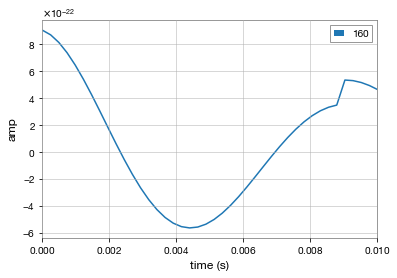

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:25 bilby INFO    : Injected signal in H1:
15:25 bilby INFO    :   optimal SNR = 6.39
15:25 bilby INFO    :   matched filter SNR = 6.25-1.51j
15:25 bilby INFO    :   frac_dw = 0.16384983607606884
15:25 bilby INFO    :   frac_dtau = 13.088445451082583
15:25 bilby INFO    :   dphi = 0
15:25 bilby INFO    :   A = 9e-22
15:25 bilby INFO    :   w = 677.4613530281187
15:25 bilby INFO    :   t0 = 0
15:25 bilby INFO    :   phi = 0
15:25 bilby INFO    :   tau = -0.009730693264965645
15:25 bilby INFO    :   geocent_time = 0
15:25 bilby INFO    :   frac_amp = 0.2
15:25 bilby INFO    :   ra = 0
15:25 bilby INFO    :   dec = 0
15:25 bilby INFO    :   psi = 0
15:25 bilby INFO    :   ts = 0.009008852235377415
15:25 bilby INFO    : Injected sign


0it [00:00, ?it/s]

15:25 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x10c3a0290>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:25 bilby INFO    : Checkpoint every n_check_point = 500000
15:25 bilby INFO    : Using dynesty version 1.0.1
15:25 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:00,  1.14it/s, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-2957.92+/-0.17 dlogz:inf>0.10]
73it [00:00,  1.63it/s, bound:0 nc:2 ncall:585 eff:12.5% logz-ratio=-1833.84+/-0.17 dlogz:1909.031>0.10]
143it [00:01,  2.33it/s, bound:0 nc:3 ncall:668 eff:21.4% logz-ratio=-1414.30+/-0.17 dlogz:1475.875>0.10]
204it [00:01,  3.33it/s, bound:0 nc:4 ncall:754 eff:27.1% logz-ratio=-1095.03+/-0.17 dlogz:1165.244>0.10]
256it [00:01,  4.74it/s, bound:0 nc:1 ncall:839 eff:30.5% logz-ratio=-904.45+/-0.17 dlogz:965.618>0.10]  
306it [00:01,  6.74it/s, bound:0 nc:1 ncall:922 eff:33.2% logz-ratio=-745.03+/-0.16 dlogz:803.783>0.10]
354it [00:01,  9.57it/s, bound:0 nc:3 ncall:1007 eff:35.2% logz-ratio=-585.40+/-0.16 dlogz:643.502>0.10]
402it [00:01, 13.53it/s, bound:0 nc:1 ncall:1120 eff:35.9% logz-ratio=-436.46+/-0.17 dlogz:496.622>0.10]
446it [00:01, 19.05it/s, bound:0 nc:2 ncall:1213 eff:36.8% logz-ratio=-330.72+/-0.17 dlogz:390.716>0.10]
489it [00:01, 26.62it/s, bound:0 nc:3 ncall:1312 eff:37.3% 

1468it [00:10, 72.27it/s, bound:0 nc:14 ncall:9090 eff:16.1% logz-ratio=47.98+/-0.11 dlogz:7.531>0.10]
1477it [00:10, 58.05it/s, bound:0 nc:2 ncall:9294 eff:15.9% logz-ratio=48.06+/-0.11 dlogz:7.439>0.10] 
1488it [00:10, 67.22it/s, bound:0 nc:26 ncall:9386 eff:15.9% logz-ratio=48.14+/-0.11 dlogz:7.330>0.10]
1497it [00:11, 68.79it/s, bound:0 nc:2 ncall:9497 eff:15.8% logz-ratio=48.21+/-0.11 dlogz:7.241>0.10] 
1505it [00:11, 62.21it/s, bound:0 nc:2 ncall:9638 eff:15.6% logz-ratio=48.28+/-0.11 dlogz:7.162>0.10]
1512it [00:11, 56.68it/s, bound:0 nc:44 ncall:9772 eff:15.5% logz-ratio=48.33+/-0.11 dlogz:7.093>0.10]
1519it [00:11, 47.24it/s, bound:0 nc:18 ncall:9960 eff:15.3% logz-ratio=48.39+/-0.11 dlogz:7.025>0.10]
1525it [00:11, 43.41it/s, bound:0 nc:25 ncall:10109 eff:15.1% logz-ratio=48.43+/-0.11 dlogz:6.967>0.10]
1533it [00:11, 45.40it/s, bound:0 nc:60 ncall:10251 eff:15.0% logz-ratio=48.49+/-0.11 dlogz:6.994>0.10]
1538it [00:12, 31.16it/s, bound:0 nc:55 ncall:10504 eff:14.6% logz-ratio

1843it [00:22, 21.42it/s, bound:4 nc:35 ncall:19309 eff:9.5% logz-ratio=50.49+/-0.12 dlogz:4.383>0.10]
1846it [00:22, 21.42it/s, bound:5 nc:41 ncall:19424 eff:9.5% logz-ratio=50.51+/-0.12 dlogz:4.361>0.10]
1849it [00:22, 21.40it/s, bound:5 nc:37 ncall:19541 eff:9.5% logz-ratio=50.52+/-0.12 dlogz:4.340>0.10]
1852it [00:22, 21.62it/s, bound:5 nc:35 ncall:19654 eff:9.4% logz-ratio=50.54+/-0.12 dlogz:4.319>0.10]
1855it [00:22, 21.83it/s, bound:6 nc:36 ncall:19764 eff:9.4% logz-ratio=50.56+/-0.12 dlogz:4.297>0.10]
1858it [00:22, 22.05it/s, bound:6 nc:35 ncall:19873 eff:9.3% logz-ratio=50.57+/-0.12 dlogz:4.276>0.10]
1861it [00:22, 22.17it/s, bound:6 nc:35 ncall:19984 eff:9.3% logz-ratio=50.59+/-0.12 dlogz:4.255>0.10]
1864it [00:23, 22.28it/s, bound:7 nc:40 ncall:20093 eff:9.3% logz-ratio=50.60+/-0.12 dlogz:4.234>0.10]
1867it [00:23, 21.97it/s, bound:7 nc:43 ncall:20211 eff:9.2% logz-ratio=50.62+/-0.12 dlogz:4.213>0.10]
1870it [00:23, 22.07it/s, bound:7 nc:39 ncall:20319 eff:9.2% logz-ratio=5

2071it [00:32, 20.49it/s, bound:33 nc:39 ncall:28271 eff:7.3% logz-ratio=51.49+/-0.12 dlogz:2.969>0.10]
2074it [00:33, 20.28it/s, bound:33 nc:44 ncall:28399 eff:7.3% logz-ratio=51.50+/-0.12 dlogz:2.953>0.10]
2077it [00:33, 20.48it/s, bound:33 nc:36 ncall:28519 eff:7.3% logz-ratio=51.51+/-0.12 dlogz:2.937>0.10]
2080it [00:33, 20.20it/s, bound:34 nc:41 ncall:28647 eff:7.3% logz-ratio=51.52+/-0.12 dlogz:2.922>0.10]
2083it [00:33, 20.94it/s, bound:34 nc:34 ncall:28756 eff:7.2% logz-ratio=51.53+/-0.12 dlogz:2.907>0.10]
2086it [00:33, 20.57it/s, bound:34 nc:42 ncall:28884 eff:7.2% logz-ratio=51.54+/-0.12 dlogz:2.891>0.10]
2089it [00:33, 20.43it/s, bound:35 nc:41 ncall:29006 eff:7.2% logz-ratio=51.55+/-0.12 dlogz:2.876>0.10]
2092it [00:33, 20.63it/s, bound:35 nc:39 ncall:29126 eff:7.2% logz-ratio=51.56+/-0.12 dlogz:2.861>0.10]
2095it [00:34, 20.49it/s, bound:36 nc:42 ncall:29245 eff:7.2% logz-ratio=51.57+/-0.12 dlogz:2.846>0.10]
2098it [00:34, 20.37it/s, bound:36 nc:41 ncall:29370 eff:7.1% lo

2297it [00:43, 20.03it/s, bound:61 nc:43 ncall:37399 eff:6.1% logz-ratio=52.18+/-0.12 dlogz:1.940>0.10]
2300it [00:44, 20.39it/s, bound:61 nc:36 ncall:37513 eff:6.1% logz-ratio=52.18+/-0.12 dlogz:1.929>0.10]
2303it [00:44, 20.34it/s, bound:62 nc:39 ncall:37636 eff:6.1% logz-ratio=52.19+/-0.12 dlogz:1.918>0.10]
2306it [00:44, 19.74it/s, bound:62 nc:47 ncall:37773 eff:6.1% logz-ratio=52.20+/-0.12 dlogz:1.907>0.10]
2309it [00:44, 20.69it/s, bound:62 nc:33 ncall:37881 eff:6.1% logz-ratio=52.20+/-0.12 dlogz:1.896>0.10]
2312it [00:44, 20.43it/s, bound:63 nc:47 ncall:38005 eff:6.1% logz-ratio=52.21+/-0.12 dlogz:1.885>0.10]
2315it [00:44, 20.70it/s, bound:63 nc:37 ncall:38121 eff:6.1% logz-ratio=52.22+/-0.12 dlogz:1.874>0.10]
2318it [00:44, 20.36it/s, bound:64 nc:41 ncall:38248 eff:6.1% logz-ratio=52.22+/-0.12 dlogz:1.863>0.10]
2321it [00:45, 20.57it/s, bound:64 nc:44 ncall:38367 eff:6.0% logz-ratio=52.23+/-0.12 dlogz:1.852>0.10]
2324it [00:45, 20.78it/s, bound:64 nc:37 ncall:38482 eff:6.0% lo

2525it [00:55, 21.14it/s, bound:89 nc:38 ncall:46560 eff:5.4% logz-ratio=52.62+/-0.12 dlogz:1.227>0.10]
2528it [00:55, 20.95it/s, bound:90 nc:42 ncall:46678 eff:5.4% logz-ratio=52.63+/-0.12 dlogz:1.220>0.10]
2531it [00:55, 20.43it/s, bound:90 nc:45 ncall:46809 eff:5.4% logz-ratio=52.63+/-0.12 dlogz:1.212>0.10]
2534it [00:55, 20.16it/s, bound:91 nc:37 ncall:46937 eff:5.4% logz-ratio=52.64+/-0.12 dlogz:1.205>0.10]
2537it [00:55, 20.94it/s, bound:91 nc:38 ncall:47046 eff:5.4% logz-ratio=52.64+/-0.12 dlogz:1.197>0.10]
2540it [00:55, 21.17it/s, bound:91 nc:45 ncall:47162 eff:5.4% logz-ratio=52.65+/-0.12 dlogz:1.190>0.10]
2543it [00:55, 21.32it/s, bound:92 nc:38 ncall:47276 eff:5.4% logz-ratio=52.65+/-0.12 dlogz:1.182>0.10]
2546it [00:56, 21.13it/s, bound:92 nc:38 ncall:47398 eff:5.4% logz-ratio=52.66+/-0.12 dlogz:1.175>0.10]
2549it [00:56, 21.73it/s, bound:92 nc:27 ncall:47505 eff:5.4% logz-ratio=52.66+/-0.12 dlogz:1.168>0.10]
2552it [00:56, 21.24it/s, bound:93 nc:43 ncall:47629 eff:5.4% lo

2753it [01:05, 20.75it/s, bound:118 nc:39 ncall:55643 eff:4.9% logz-ratio=52.92+/-0.12 dlogz:0.765>0.10]
2756it [01:06, 21.15it/s, bound:118 nc:31 ncall:55756 eff:4.9% logz-ratio=52.93+/-0.12 dlogz:0.760>0.10]
2759it [01:06, 20.85it/s, bound:118 nc:45 ncall:55882 eff:4.9% logz-ratio=52.93+/-0.12 dlogz:0.756>0.10]
2762it [01:06, 20.79it/s, bound:119 nc:45 ncall:56002 eff:4.9% logz-ratio=52.93+/-0.12 dlogz:0.751>0.10]
2765it [01:06, 20.68it/s, bound:119 nc:49 ncall:56123 eff:4.9% logz-ratio=52.93+/-0.12 dlogz:0.746>0.10]
2768it [01:06, 20.80it/s, bound:120 nc:32 ncall:56235 eff:4.9% logz-ratio=52.94+/-0.12 dlogz:0.741>0.10]
2771it [01:06, 19.79it/s, bound:120 nc:52 ncall:56378 eff:4.9% logz-ratio=52.94+/-0.12 dlogz:0.737>0.10]
2774it [01:06, 20.50it/s, bound:120 nc:42 ncall:56487 eff:4.9% logz-ratio=52.94+/-0.12 dlogz:0.732>0.10]
2777it [01:07, 20.59it/s, bound:121 nc:38 ncall:56606 eff:4.9% logz-ratio=52.95+/-0.12 dlogz:0.727>0.10]
2780it [01:07, 20.62it/s, bound:121 nc:42 ncall:56728 e

2978it [01:16, 20.19it/s, bound:145 nc:39 ncall:64443 eff:4.6% logz-ratio=53.11+/-0.12 dlogz:0.476>0.10]
2981it [01:16, 20.44it/s, bound:146 nc:39 ncall:64560 eff:4.6% logz-ratio=53.11+/-0.12 dlogz:0.473>0.10]
2984it [01:16, 20.45it/s, bound:146 nc:31 ncall:64679 eff:4.6% logz-ratio=53.11+/-0.12 dlogz:0.470>0.10]
2987it [01:17, 20.63it/s, bound:147 nc:43 ncall:64795 eff:4.6% logz-ratio=53.11+/-0.12 dlogz:0.467>0.10]
2990it [01:17, 21.51it/s, bound:147 nc:30 ncall:64899 eff:4.6% logz-ratio=53.11+/-0.12 dlogz:0.464>0.10]
2993it [01:17, 19.45it/s, bound:147 nc:44 ncall:65024 eff:4.6% logz-ratio=53.12+/-0.12 dlogz:0.461>0.10]
2995it [01:17, 18.59it/s, bound:148 nc:37 ncall:65114 eff:4.6% logz-ratio=53.12+/-0.12 dlogz:0.464>0.10]
2998it [01:17, 19.73it/s, bound:148 nc:37 ncall:65220 eff:4.6% logz-ratio=53.12+/-0.12 dlogz:0.462>0.10]
3001it [01:17, 20.73it/s, bound:148 nc:35 ncall:65323 eff:4.6% logz-ratio=53.12+/-0.12 dlogz:0.459>0.10]
3004it [01:17, 21.31it/s, bound:149 nc:43 ncall:65428 e

3154it [01:27, 14.10it/s, bound:167 nc:45 ncall:71239 eff:4.4% logz-ratio=53.20+/-0.12 dlogz:0.334>0.10]
3156it [01:27, 13.64it/s, bound:167 nc:36 ncall:71323 eff:4.4% logz-ratio=53.20+/-0.12 dlogz:0.332>0.10]
3158it [01:27, 13.42it/s, bound:167 nc:52 ncall:71417 eff:4.4% logz-ratio=53.20+/-0.12 dlogz:0.331>0.10]
3160it [01:27, 13.62it/s, bound:168 nc:38 ncall:71496 eff:4.4% logz-ratio=53.20+/-0.12 dlogz:0.329>0.10]
3162it [01:27, 14.38it/s, bound:168 nc:31 ncall:71568 eff:4.4% logz-ratio=53.20+/-0.12 dlogz:0.328>0.10]
3164it [01:27, 14.76it/s, bound:168 nc:38 ncall:71646 eff:4.4% logz-ratio=53.21+/-0.12 dlogz:0.327>0.10]
3166it [01:27, 14.40it/s, bound:168 nc:42 ncall:71729 eff:4.4% logz-ratio=53.21+/-0.12 dlogz:0.325>0.10]
3168it [01:28, 14.64it/s, bound:169 nc:33 ncall:71800 eff:4.4% logz-ratio=53.21+/-0.12 dlogz:0.324>0.10]
3170it [01:28, 14.83it/s, bound:169 nc:37 ncall:71879 eff:4.4% logz-ratio=53.21+/-0.12 dlogz:0.323>0.10]
3172it [01:28, 16.08it/s, bound:169 nc:47 ncall:71959 e

3314it [01:36, 17.96it/s, bound:187 nc:37 ncall:77675 eff:4.3% logz-ratio=53.26+/-0.12 dlogz:0.239>0.10]
3316it [01:36, 17.26it/s, bound:187 nc:51 ncall:77766 eff:4.3% logz-ratio=53.26+/-0.12 dlogz:0.238>0.10]
3318it [01:37, 16.49it/s, bound:187 nc:40 ncall:77849 eff:4.3% logz-ratio=53.26+/-0.12 dlogz:0.237>0.10]
3320it [01:37, 15.39it/s, bound:188 nc:38 ncall:77928 eff:4.3% logz-ratio=53.26+/-0.12 dlogz:0.236>0.10]
3322it [01:37, 15.77it/s, bound:188 nc:32 ncall:78004 eff:4.3% logz-ratio=53.27+/-0.12 dlogz:0.235>0.10]
3324it [01:37, 16.44it/s, bound:188 nc:42 ncall:78082 eff:4.3% logz-ratio=53.27+/-0.12 dlogz:0.234>0.10]
3326it [01:37, 17.12it/s, bound:188 nc:42 ncall:78169 eff:4.3% logz-ratio=53.27+/-0.12 dlogz:0.233>0.10]
3328it [01:37, 16.07it/s, bound:189 nc:39 ncall:78258 eff:4.3% logz-ratio=53.27+/-0.12 dlogz:0.232>0.10]
3330it [01:37, 15.57it/s, bound:189 nc:41 ncall:78343 eff:4.3% logz-ratio=53.27+/-0.12 dlogz:0.231>0.10]
3332it [01:37, 15.11it/s, bound:189 nc:45 ncall:78433 e

3484it [01:46, 19.99it/s, bound:209 nc:44 ncall:84583 eff:4.1% logz-ratio=53.31+/-0.12 dlogz:0.168>0.10]
3487it [01:46, 20.63it/s, bound:209 nc:42 ncall:84695 eff:4.1% logz-ratio=53.31+/-0.12 dlogz:0.167>0.10]
3490it [01:46, 20.65it/s, bound:209 nc:42 ncall:84816 eff:4.1% logz-ratio=53.31+/-0.12 dlogz:0.166>0.10]
3493it [01:46, 20.71it/s, bound:210 nc:37 ncall:84935 eff:4.1% logz-ratio=53.31+/-0.12 dlogz:0.165>0.10]
3496it [01:47, 21.20it/s, bound:210 nc:33 ncall:85046 eff:4.1% logz-ratio=53.31+/-0.12 dlogz:0.164>0.10]
3499it [01:47, 21.31it/s, bound:210 nc:41 ncall:85161 eff:4.1% logz-ratio=53.32+/-0.12 dlogz:0.163>0.10]
3502it [01:47, 20.32it/s, bound:211 nc:51 ncall:85298 eff:4.1% logz-ratio=53.32+/-0.12 dlogz:0.162>0.10]
3505it [01:47, 20.20it/s, bound:211 nc:46 ncall:85425 eff:4.1% logz-ratio=53.32+/-0.12 dlogz:0.161>0.10]
3508it [01:47, 20.44it/s, bound:212 nc:41 ncall:85543 eff:4.1% logz-ratio=53.32+/-0.12 dlogz:0.160>0.10]
3511it [01:47, 20.62it/s, bound:212 nc:40 ncall:85661 e

3699it [01:57, 20.46it/s, bound:236 nc:37 ncall:93365 eff:4.0% logz-ratio=53.36+/-0.12 dlogz:0.108>0.10]
3702it [01:57, 20.32it/s, bound:236 nc:42 ncall:93491 eff:4.0% logz-ratio=53.36+/-0.12 dlogz:0.107>0.10]
3705it [01:57, 20.58it/s, bound:237 nc:41 ncall:93609 eff:4.0% logz-ratio=53.36+/-0.12 dlogz:0.107>0.10]
3708it [01:57, 20.86it/s, bound:237 nc:38 ncall:93725 eff:4.0% logz-ratio=53.36+/-0.12 dlogz:0.106>0.10]
3711it [01:57, 20.82it/s, bound:237 nc:40 ncall:93840 eff:4.0% logz-ratio=53.36+/-0.12 dlogz:0.106>0.10]
3714it [01:57, 20.73it/s, bound:238 nc:40 ncall:93961 eff:4.0% logz-ratio=53.36+/-0.12 dlogz:0.105>0.10]
3717it [01:58, 20.66it/s, bound:238 nc:38 ncall:94084 eff:4.0% logz-ratio=53.36+/-0.12 dlogz:0.104>0.10]
3720it [01:58, 21.03it/s, bound:238 nc:33 ncall:94197 eff:3.9% logz-ratio=53.36+/-0.12 dlogz:0.104>0.10]
3723it [01:58, 21.02it/s, bound:239 nc:41 ncall:94316 eff:3.9% logz-ratio=53.36+/-0.12 dlogz:0.103>0.10]
3726it [01:58, 20.44it/s, bound:239 nc:44 ncall:94448 e

15:27 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass160_220_9_9e-22_2mode_frac0.2_resume.pickle



3737it [01:59, 31.26it/s, bound:241 nc:1 ncall:94879 eff:4.5% logz-ratio=53.45+/-0.13 dlogz:0.000>0.10] 



15:27 bilby INFO    : Sampling time: 0:01:58.108502
15:27 bilby INFO    : Summary of results:
nsamples: 4237
log_noise_evidence: -4145.653
log_evidence: -4092.207 +/-  0.125
log_bayes_factor: 53.446 +/-  0.125



GR freq is 95.84117607835434
Q freq is 15.703560989768748
frac_dw is 0.16384983607599307
{'frac_dw': 0.16384983607599307, 'frac_dtau': 13.088445451088637, 'dphi': 0, 'A': 9e-22, 'w': 602.1878693583276, 't0': 0, 'phi': 0, 'tau': -0.010947029923086353, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.01013495876480428}


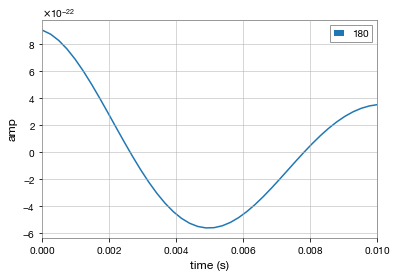

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:27 bilby INFO    : Injected signal in H1:
15:27 bilby INFO    :   optimal SNR = 5.54
15:27 bilby INFO    :   matched filter SNR = 5.27-0.80j
15:27 bilby INFO    :   frac_dw = 0.16384983607599307
15:27 bilby INFO    :   frac_dtau = 13.088445451088637
15:27 bilby INFO    :   dphi = 0
15:27 bilby INFO    :   A = 9e-22
15:27 bilby INFO    :   w = 602.1878693583276
15:27 bilby INFO    :   t0 = 0
15:27 bilby INFO    :   phi = 0
15:27 bilby INFO    :   tau = -0.010947029923086353
15:27 bilby INFO    :   geocent_time = 0
15:27 bilby INFO    :   frac_amp = 0.2
15:27 bilby INFO    :   ra = 0
15:27 bilby INFO    :   dec = 0
15:27 bilby INFO    :   psi = 0
15:27 bilby INFO    :   ts = 0.01013495876480428
15:27 bilby INFO    : Injected signa


0it [00:00, ?it/s]

15:27 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12c776c10>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:27 bilby INFO    : Checkpoint every n_check_point = 400000
15:27 bilby INFO    : Using dynesty version 1.0.1
15:27 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:00,  1.14it/s, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-3167.59+/-0.17 dlogz:inf>0.10]
76it [00:00,  1.63it/s, bound:0 nc:2 ncall:583 eff:13.0% logz-ratio=-1919.53+/-0.15 dlogz:1973.306>0.10]
142it [00:01,  2.32it/s, bound:0 nc:1 ncall:666 eff:21.3% logz-ratio=-1428.09+/-0.17 dlogz:1485.836>0.10]
203it [00:01,  3.32it/s, bound:0 nc:3 ncall:750 eff:27.1% logz-ratio=-1038.18+/-0.16 dlogz:1092.885>0.10]
249it [00:01,  4.72it/s, bound:0 nc:2 ncall:835 eff:29.8% logz-ratio=-825.32+/-0.17 dlogz:880.815>0.10]  
301it [00:01,  6.72it/s, bound:0 nc:2 ncall:920 eff:32.7% logz-ratio=-629.32+/-0.17 dlogz:703.358>0.10]
348it [00:01,  9.53it/s, bound:0 nc:2 ncall:1015 eff:34.3% logz-ratio=-509.97+/-0.16 dlogz:563.425>0.10]
393it [00:01, 13.47it/s, bound:0 nc:2 ncall:1118 eff:35.2% logz-ratio=-382.45+/-0.16 dlogz:436.042>0.10]
436it [00:01, 18.96it/s, bound:0 nc:1 ncall:1206 eff:36.2% logz-ratio=-305.67+/-0.15 dlogz:357.935>0.10]
478it [00:01, 26.39it/s, bound:0 nc:1 ncall:1325 eff:36.1% 

1450it [00:10, 52.86it/s, bound:0 nc:12 ncall:9001 eff:16.1% logz-ratio=42.93+/-0.11 dlogz:7.153>0.10]
1457it [00:10, 42.93it/s, bound:0 nc:29 ncall:9213 eff:15.8% logz-ratio=42.99+/-0.11 dlogz:7.076>0.10]
1463it [00:10, 43.57it/s, bound:0 nc:32 ncall:9331 eff:15.7% logz-ratio=43.05+/-0.11 dlogz:7.011>0.10]
1471it [00:11, 48.65it/s, bound:0 nc:36 ncall:9438 eff:15.6% logz-ratio=43.12+/-0.11 dlogz:6.926>0.10]
1477it [00:11, 45.48it/s, bound:0 nc:3 ncall:9574 eff:15.4% logz-ratio=43.16+/-0.11 dlogz:6.864>0.10] 
1483it [00:11, 45.11it/s, bound:0 nc:19 ncall:9695 eff:15.3% logz-ratio=43.21+/-0.11 dlogz:6.803>0.10]
1488it [00:11, 42.24it/s, bound:0 nc:15 ncall:9816 eff:15.2% logz-ratio=43.25+/-0.11 dlogz:6.753>0.10]
1495it [00:11, 45.74it/s, bound:0 nc:24 ncall:9927 eff:15.1% logz-ratio=43.31+/-0.11 dlogz:6.682>0.10]
1501it [00:11, 34.58it/s, bound:0 nc:162 ncall:10174 eff:14.8% logz-ratio=43.36+/-0.11 dlogz:6.622>0.10]
1509it [00:12, 39.43it/s, bound:0 nc:68 ncall:10296 eff:14.7% logz-rati

1831it [00:22, 21.28it/s, bound:5 nc:34 ncall:19419 eff:9.4% logz-ratio=45.46+/-0.12 dlogz:3.881>0.10]
1834it [00:22, 21.75it/s, bound:5 nc:35 ncall:19528 eff:9.4% logz-ratio=45.47+/-0.12 dlogz:3.860>0.10]
1837it [00:22, 21.46it/s, bound:6 nc:40 ncall:19647 eff:9.4% logz-ratio=45.49+/-0.12 dlogz:3.839>0.10]
1840it [00:22, 21.83it/s, bound:6 nc:44 ncall:19756 eff:9.3% logz-ratio=45.50+/-0.12 dlogz:3.818>0.10]
1843it [00:22, 21.72it/s, bound:6 nc:41 ncall:19872 eff:9.3% logz-ratio=45.52+/-0.12 dlogz:3.797>0.10]
1846it [00:23, 21.18it/s, bound:7 nc:44 ncall:19996 eff:9.2% logz-ratio=45.53+/-0.12 dlogz:3.776>0.10]
1849it [00:23, 20.69it/s, bound:7 nc:43 ncall:20121 eff:9.2% logz-ratio=45.55+/-0.12 dlogz:3.756>0.10]
1852it [00:23, 21.29it/s, bound:7 nc:34 ncall:20227 eff:9.2% logz-ratio=45.56+/-0.12 dlogz:3.735>0.10]
1855it [00:23, 21.21it/s, bound:8 nc:41 ncall:20339 eff:9.1% logz-ratio=45.58+/-0.12 dlogz:3.714>0.10]
1858it [00:23, 21.11it/s, bound:8 nc:40 ncall:20459 eff:9.1% logz-ratio=4

2059it [00:33, 21.73it/s, bound:33 nc:40 ncall:28255 eff:7.3% logz-ratio=46.41+/-0.12 dlogz:2.534>0.10]
2062it [00:33, 22.20it/s, bound:33 nc:36 ncall:28362 eff:7.3% logz-ratio=46.42+/-0.12 dlogz:2.520>0.10]
2065it [00:33, 21.17it/s, bound:34 nc:45 ncall:28493 eff:7.2% logz-ratio=46.43+/-0.12 dlogz:2.507>0.10]
2068it [00:33, 21.13it/s, bound:34 nc:39 ncall:28612 eff:7.2% logz-ratio=46.44+/-0.12 dlogz:2.493>0.10]
2071it [00:33, 21.02it/s, bound:34 nc:43 ncall:28733 eff:7.2% logz-ratio=46.44+/-0.12 dlogz:2.479>0.10]
2074it [00:33, 20.92it/s, bound:35 nc:43 ncall:28852 eff:7.2% logz-ratio=46.45+/-0.12 dlogz:2.465>0.10]
2077it [00:33, 20.94it/s, bound:35 nc:39 ncall:28972 eff:7.2% logz-ratio=46.46+/-0.12 dlogz:2.452>0.10]
2080it [00:34, 20.87it/s, bound:35 nc:37 ncall:29094 eff:7.1% logz-ratio=46.47+/-0.12 dlogz:2.438>0.10]
2083it [00:34, 20.78it/s, bound:36 nc:40 ncall:29215 eff:7.1% logz-ratio=46.48+/-0.12 dlogz:2.424>0.10]
2086it [00:34, 20.92it/s, bound:36 nc:43 ncall:29334 eff:7.1% lo

2287it [00:43, 21.40it/s, bound:61 nc:33 ncall:37268 eff:6.1% logz-ratio=47.03+/-0.12 dlogz:1.602>0.10]
2290it [00:44, 21.42it/s, bound:61 nc:39 ncall:37385 eff:6.1% logz-ratio=47.03+/-0.12 dlogz:1.591>0.10]
2293it [00:44, 21.04it/s, bound:62 nc:40 ncall:37508 eff:6.1% logz-ratio=47.04+/-0.12 dlogz:1.581>0.10]
2296it [00:44, 20.27it/s, bound:62 nc:44 ncall:37643 eff:6.1% logz-ratio=47.05+/-0.12 dlogz:1.571>0.10]
2299it [00:44, 19.61it/s, bound:63 nc:44 ncall:37782 eff:6.1% logz-ratio=47.05+/-0.12 dlogz:1.561>0.10]
2301it [00:44, 19.18it/s, bound:63 nc:45 ncall:37869 eff:6.1% logz-ratio=47.06+/-0.12 dlogz:1.555>0.10]
2304it [00:44, 19.40it/s, bound:63 nc:46 ncall:37995 eff:6.1% logz-ratio=47.06+/-0.12 dlogz:1.545>0.10]
2306it [00:44, 19.30it/s, bound:64 nc:42 ncall:38081 eff:6.1% logz-ratio=47.07+/-0.12 dlogz:1.538>0.10]
2309it [00:45, 20.16it/s, bound:64 nc:30 ncall:38191 eff:6.0% logz-ratio=47.08+/-0.12 dlogz:1.529>0.10]
2312it [00:45, 20.68it/s, bound:64 nc:45 ncall:38305 eff:6.0% lo

2508it [00:54, 21.22it/s, bound:89 nc:38 ncall:46264 eff:5.4% logz-ratio=47.43+/-0.12 dlogz:0.996>0.10]
2511it [00:54, 21.13it/s, bound:89 nc:34 ncall:46384 eff:5.4% logz-ratio=47.43+/-0.12 dlogz:0.990>0.10]
2514it [00:55, 21.12it/s, bound:90 nc:42 ncall:46501 eff:5.4% logz-ratio=47.43+/-0.12 dlogz:0.984>0.10]
2517it [00:55, 21.64it/s, bound:90 nc:33 ncall:46610 eff:5.4% logz-ratio=47.44+/-0.12 dlogz:0.977>0.10]
2520it [00:55, 20.98it/s, bound:91 nc:37 ncall:46737 eff:5.4% logz-ratio=47.44+/-0.12 dlogz:0.971>0.10]
2523it [00:55, 20.61it/s, bound:91 nc:44 ncall:46864 eff:5.4% logz-ratio=47.45+/-0.12 dlogz:0.965>0.10]
2526it [00:55, 20.37it/s, bound:91 nc:39 ncall:46991 eff:5.4% logz-ratio=47.45+/-0.12 dlogz:0.958>0.10]
2529it [00:55, 20.31it/s, bound:92 nc:42 ncall:47115 eff:5.4% logz-ratio=47.45+/-0.12 dlogz:0.952>0.10]
2532it [00:55, 19.80it/s, bound:92 nc:43 ncall:47246 eff:5.4% logz-ratio=47.46+/-0.12 dlogz:0.946>0.10]
2535it [00:56, 20.14it/s, bound:92 nc:44 ncall:47366 eff:5.4% lo

2723it [01:05, 16.38it/s, bound:116 nc:49 ncall:54838 eff:5.0% logz-ratio=47.68+/-0.12 dlogz:0.622>0.10]
2725it [01:05, 16.23it/s, bound:116 nc:35 ncall:54915 eff:5.0% logz-ratio=47.68+/-0.12 dlogz:0.619>0.10]
2727it [01:05, 16.88it/s, bound:116 nc:35 ncall:54990 eff:5.0% logz-ratio=47.68+/-0.12 dlogz:0.616>0.10]
2729it [01:05, 17.03it/s, bound:116 nc:37 ncall:55067 eff:5.0% logz-ratio=47.68+/-0.12 dlogz:0.614>0.10]
2731it [01:06, 17.09it/s, bound:117 nc:39 ncall:55143 eff:5.0% logz-ratio=47.69+/-0.12 dlogz:0.611>0.10]
2733it [01:06, 15.82it/s, bound:117 nc:39 ncall:55227 eff:4.9% logz-ratio=47.69+/-0.12 dlogz:0.608>0.10]
2735it [01:06, 15.53it/s, bound:117 nc:41 ncall:55316 eff:4.9% logz-ratio=47.69+/-0.12 dlogz:0.606>0.10]
2738it [01:06, 17.21it/s, bound:118 nc:37 ncall:55419 eff:4.9% logz-ratio=47.69+/-0.12 dlogz:0.602>0.10]
2741it [01:06, 18.06it/s, bound:118 nc:40 ncall:55541 eff:4.9% logz-ratio=47.70+/-0.12 dlogz:0.598>0.10]
2743it [01:06, 18.31it/s, bound:118 nc:44 ncall:55628 e

2889it [01:15, 16.59it/s, bound:136 nc:39 ncall:61538 eff:4.7% logz-ratio=47.82+/-0.12 dlogz:0.433>0.10]
2891it [01:15, 17.34it/s, bound:137 nc:41 ncall:61619 eff:4.7% logz-ratio=47.82+/-0.12 dlogz:0.432>0.10]
2893it [01:15, 18.05it/s, bound:137 nc:39 ncall:61702 eff:4.7% logz-ratio=47.82+/-0.12 dlogz:0.430>0.10]
2896it [01:15, 18.67it/s, bound:137 nc:37 ncall:61818 eff:4.7% logz-ratio=47.82+/-0.12 dlogz:0.427>0.10]
2898it [01:15, 17.51it/s, bound:138 nc:41 ncall:61902 eff:4.7% logz-ratio=47.82+/-0.12 dlogz:0.425>0.10]
2900it [01:15, 17.90it/s, bound:138 nc:41 ncall:61983 eff:4.7% logz-ratio=47.82+/-0.12 dlogz:0.423>0.10]
2902it [01:15, 18.24it/s, bound:138 nc:45 ncall:62070 eff:4.7% logz-ratio=47.83+/-0.12 dlogz:0.421>0.10]
2904it [01:16, 18.68it/s, bound:138 nc:43 ncall:62154 eff:4.7% logz-ratio=47.83+/-0.12 dlogz:0.419>0.10]
2907it [01:16, 19.53it/s, bound:139 nc:33 ncall:62265 eff:4.7% logz-ratio=47.83+/-0.12 dlogz:0.417>0.10]
2910it [01:16, 19.85it/s, bound:139 nc:43 ncall:62383 e

3066it [01:25, 16.58it/s, bound:158 nc:39 ncall:68567 eff:4.5% logz-ratio=47.92+/-0.12 dlogz:0.295>0.10]
3068it [01:25, 16.10it/s, bound:158 nc:37 ncall:68646 eff:4.5% logz-ratio=47.92+/-0.12 dlogz:0.293>0.10]
3070it [01:25, 16.59it/s, bound:159 nc:29 ncall:68714 eff:4.5% logz-ratio=47.92+/-0.12 dlogz:0.292>0.10]
3072it [01:25, 15.35it/s, bound:159 nc:42 ncall:68801 eff:4.5% logz-ratio=47.93+/-0.12 dlogz:0.291>0.10]
3074it [01:25, 15.60it/s, bound:159 nc:41 ncall:68878 eff:4.5% logz-ratio=47.93+/-0.12 dlogz:0.290>0.10]
3076it [01:25, 15.38it/s, bound:159 nc:43 ncall:68962 eff:4.5% logz-ratio=47.93+/-0.12 dlogz:0.288>0.10]
3078it [01:25, 15.20it/s, bound:160 nc:38 ncall:69041 eff:4.5% logz-ratio=47.93+/-0.12 dlogz:0.287>0.10]
3080it [01:25, 15.36it/s, bound:160 nc:40 ncall:69120 eff:4.5% logz-ratio=47.93+/-0.12 dlogz:0.286>0.10]
3082it [01:26, 14.84it/s, bound:160 nc:40 ncall:69203 eff:4.5% logz-ratio=47.93+/-0.12 dlogz:0.285>0.10]
3084it [01:26, 14.55it/s, bound:160 nc:47 ncall:69291 e

3261it [01:35, 21.69it/s, bound:182 nc:37 ncall:76116 eff:4.3% logz-ratio=48.00+/-0.12 dlogz:0.195>0.10]
3264it [01:35, 21.19it/s, bound:182 nc:45 ncall:76237 eff:4.3% logz-ratio=48.00+/-0.12 dlogz:0.194>0.10]
3267it [01:35, 21.75it/s, bound:183 nc:36 ncall:76343 eff:4.3% logz-ratio=48.01+/-0.12 dlogz:0.193>0.10]
3270it [01:35, 22.44it/s, bound:183 nc:30 ncall:76446 eff:4.3% logz-ratio=48.01+/-0.12 dlogz:0.192>0.10]
3273it [01:35, 22.12it/s, bound:183 nc:44 ncall:76563 eff:4.3% logz-ratio=48.01+/-0.12 dlogz:0.190>0.10]
3276it [01:35, 21.45it/s, bound:184 nc:38 ncall:76686 eff:4.3% logz-ratio=48.01+/-0.12 dlogz:0.189>0.10]
3279it [01:35, 21.87it/s, bound:184 nc:51 ncall:76795 eff:4.3% logz-ratio=48.01+/-0.12 dlogz:0.188>0.10]
3282it [01:36, 21.17it/s, bound:184 nc:40 ncall:76923 eff:4.3% logz-ratio=48.01+/-0.12 dlogz:0.187>0.10]
3285it [01:36, 20.96it/s, bound:185 nc:43 ncall:77044 eff:4.3% logz-ratio=48.01+/-0.12 dlogz:0.186>0.10]
3288it [01:36, 21.40it/s, bound:185 nc:39 ncall:77155 e

3486it [01:45, 21.73it/s, bound:209 nc:43 ncall:84714 eff:4.1% logz-ratio=48.06+/-0.12 dlogz:0.122>0.10]
3489it [01:45, 22.29it/s, bound:209 nc:42 ncall:84818 eff:4.1% logz-ratio=48.07+/-0.12 dlogz:0.121>0.10]
3492it [01:45, 22.27it/s, bound:210 nc:32 ncall:84928 eff:4.1% logz-ratio=48.07+/-0.12 dlogz:0.120>0.10]
3495it [01:45, 21.80it/s, bound:210 nc:43 ncall:85049 eff:4.1% logz-ratio=48.07+/-0.12 dlogz:0.119>0.10]
3498it [01:46, 21.41it/s, bound:210 nc:47 ncall:85171 eff:4.1% logz-ratio=48.07+/-0.12 dlogz:0.119>0.10]
3501it [01:46, 21.04it/s, bound:211 nc:43 ncall:85292 eff:4.1% logz-ratio=48.07+/-0.12 dlogz:0.118>0.10]
3504it [01:46, 20.96it/s, bound:211 nc:40 ncall:85409 eff:4.1% logz-ratio=48.07+/-0.12 dlogz:0.117>0.10]
3507it [01:46, 21.10it/s, bound:211 nc:31 ncall:85525 eff:4.1% logz-ratio=48.07+/-0.12 dlogz:0.116>0.10]
3510it [01:46, 21.48it/s, bound:212 nc:40 ncall:85629 eff:4.1% logz-ratio=48.07+/-0.12 dlogz:0.116>0.10]
3513it [01:46, 22.11it/s, bound:212 nc:37 ncall:85733 e

15:29 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass180_220_9_9e-22_2mode_frac0.2_resume.pickle



3580it [01:50, 32.44it/s, bound:220 nc:1 ncall:88261 eff:4.6% logz-ratio=48.17+/-0.12 dlogz:0.000>0.10] 



15:29 bilby INFO    : Sampling time: 0:01:49.008616
15:29 bilby INFO    : Summary of results:
nsamples: 4080
log_noise_evidence: -4107.231
log_evidence: -4059.059 +/-  0.122
log_bayes_factor: 48.172 +/-  0.122



GR freq is 86.25705847051891
Q freq is 14.133204890787203
frac_dw is 0.16384983607593892
{'frac_dw': 0.16384983607593892, 'frac_dtau': 13.088445451092959, 'dphi': 0, 'A': 9e-22, 'w': 541.9690824224949, 't0': 0, 'phi': 0, 'tau': -0.012163366581207058, 'geocent_time': 0, 'frac_amp': 0.2, 'ra': 0, 'dec': 0, 'psi': 0, 'ts': 0.011261065294230698}


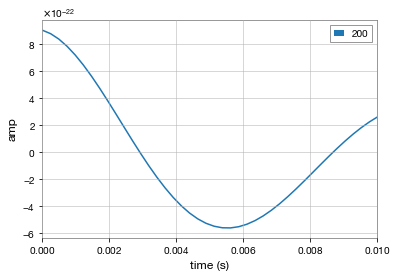

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
15:29 bilby INFO    : Injected signal in H1:
15:29 bilby INFO    :   optimal SNR = 5.14
15:29 bilby INFO    :   matched filter SNR = 3.51+0.81j
15:29 bilby INFO    :   frac_dw = 0.16384983607593892
15:29 bilby INFO    :   frac_dtau = 13.088445451092959
15:29 bilby INFO    :   dphi = 0
15:29 bilby INFO    :   A = 9e-22
15:29 bilby INFO    :   w = 541.9690824224949
15:29 bilby INFO    :   t0 = 0
15:29 bilby INFO    :   phi = 0
15:29 bilby INFO    :   tau = -0.012163366581207058
15:29 bilby INFO    :   geocent_time = 0
15:29 bilby INFO    :   frac_amp = 0.2
15:29 bilby INFO    :   ra = 0
15:29 bilby INFO    :   dec = 0
15:29 bilby INFO    :   psi = 0
15:29 bilby INFO    :   ts = 0.011261065294230698
15:29 bilby INFO    : Injected sign


0it [00:00, ?it/s]

15:29 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x13b2c7f50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:29 bilby INFO    : Checkpoint every n_check_point = 400000
15:29 bilby INFO    : Using dynesty version 1.0.1
15:29 bilby INFO    : Using the bilby-implemented rwalk sample me


1it [00:00,  1.13it/s, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-3230.57+/-0.17 dlogz:inf>0.10]
77it [00:00,  1.61it/s, bound:0 nc:1 ncall:582 eff:13.2% logz-ratio=-2025.84+/-0.17 dlogz:2073.297>0.10]
138it [00:01,  2.30it/s, bound:0 nc:2 ncall:667 eff:20.7% logz-ratio=-1441.25+/-0.17 dlogz:1492.827>0.10]
201it [00:01,  3.27it/s, bound:0 nc:1 ncall:750 eff:26.8% logz-ratio=-1050.74+/-0.17 dlogz:1093.819>0.10]
254it [00:01,  4.67it/s, bound:0 nc:2 ncall:835 eff:30.4% logz-ratio=-853.19+/-0.16 dlogz:893.824>0.10]  
300it [00:01,  6.64it/s, bound:0 nc:2 ncall:920 eff:32.6% logz-ratio=-656.96+/-0.17 dlogz:703.873>0.10]
346it [00:01,  9.42it/s, bound:0 nc:1 ncall:1007 eff:34.4% logz-ratio=-499.93+/-0.16 dlogz:540.529>0.10]
392it [00:01, 13.31it/s, bound:0 nc:2 ncall:1111 eff:35.3% logz-ratio=-371.21+/-0.17 dlogz:412.820>0.10]
435it [00:01, 18.69it/s, bound:0 nc:2 ncall:1226 eff:35.5% logz-ratio=-288.70+/-0.17 dlogz:330.188>0.10]
475it [00:01, 26.09it/s, bound:0 nc:1 ncall:1325 eff:35.8% 

1483it [00:10, 57.25it/s, bound:0 nc:6 ncall:9018 eff:16.4% logz-ratio=35.86+/-0.10 dlogz:1.378>0.10]
1489it [00:10, 54.67it/s, bound:0 nc:17 ncall:9126 eff:16.3% logz-ratio=35.87+/-0.10 dlogz:1.359>0.10]
1497it [00:10, 59.62it/s, bound:0 nc:42 ncall:9220 eff:16.2% logz-ratio=35.89+/-0.10 dlogz:1.334>0.10]
1504it [00:11, 50.34it/s, bound:0 nc:14 ncall:9392 eff:16.0% logz-ratio=35.90+/-0.10 dlogz:1.313>0.10]
1510it [00:11, 50.24it/s, bound:0 nc:14 ncall:9500 eff:15.9% logz-ratio=35.92+/-0.10 dlogz:1.295>0.10]
1516it [00:11, 51.91it/s, bound:0 nc:63 ncall:9596 eff:15.8% logz-ratio=35.93+/-0.10 dlogz:1.277>0.10]
1522it [00:11, 52.26it/s, bound:0 nc:21 ncall:9697 eff:15.7% logz-ratio=35.94+/-0.10 dlogz:1.259>0.10]
1528it [00:11, 47.72it/s, bound:0 nc:7 ncall:9833 eff:15.5% logz-ratio=35.95+/-0.10 dlogz:1.242>0.10] 
1533it [00:11, 37.41it/s, bound:0 nc:34 ncall:10015 eff:15.3% logz-ratio=35.96+/-0.10 dlogz:1.228>0.10]
1540it [00:11, 41.31it/s, bound:0 nc:55 ncall:10130 eff:15.2% logz-ratio=

1860it [00:22, 19.37it/s, bound:3 nc:48 ncall:19185 eff:9.7% logz-ratio=36.40+/-0.09 dlogz:0.596>0.10]
1863it [00:22, 19.59it/s, bound:3 nc:35 ncall:19309 eff:9.6% logz-ratio=36.40+/-0.09 dlogz:0.592>0.10]
1866it [00:22, 19.00it/s, bound:3 nc:43 ncall:19452 eff:9.6% logz-ratio=36.40+/-0.09 dlogz:0.588>0.10]
1868it [00:22, 18.96it/s, bound:4 nc:35 ncall:19537 eff:9.6% logz-ratio=36.40+/-0.09 dlogz:0.586>0.10]
1871it [00:22, 19.41it/s, bound:4 nc:45 ncall:19660 eff:9.5% logz-ratio=36.41+/-0.09 dlogz:0.582>0.10]
1873it [00:22, 19.57it/s, bound:4 nc:40 ncall:19741 eff:9.5% logz-ratio=36.41+/-0.09 dlogz:0.579>0.10]
1875it [00:22, 19.01it/s, bound:5 nc:46 ncall:19831 eff:9.5% logz-ratio=36.41+/-0.09 dlogz:0.577>0.10]
1877it [00:22, 18.98it/s, bound:5 nc:47 ncall:19918 eff:9.4% logz-ratio=36.41+/-0.09 dlogz:0.575>0.10]
1880it [00:23, 19.29it/s, bound:5 nc:44 ncall:20043 eff:9.4% logz-ratio=36.41+/-0.09 dlogz:0.571>0.10]
1882it [00:23, 19.17it/s, bound:6 nc:41 ncall:20130 eff:9.3% logz-ratio=3

2047it [00:31, 18.78it/s, bound:27 nc:37 ncall:27114 eff:7.5% logz-ratio=36.53+/-0.09 dlogz:0.400>0.10]
2049it [00:31, 19.13it/s, bound:28 nc:40 ncall:27197 eff:7.5% logz-ratio=36.53+/-0.09 dlogz:0.398>0.10]
2051it [00:31, 18.73it/s, bound:28 nc:54 ncall:27290 eff:7.5% logz-ratio=36.53+/-0.09 dlogz:0.396>0.10]
2053it [00:31, 19.07it/s, bound:28 nc:44 ncall:27374 eff:7.5% logz-ratio=36.53+/-0.09 dlogz:0.395>0.10]
2055it [00:32, 19.26it/s, bound:28 nc:41 ncall:27459 eff:7.5% logz-ratio=36.53+/-0.09 dlogz:0.393>0.10]
2057it [00:32, 18.56it/s, bound:29 nc:49 ncall:27556 eff:7.5% logz-ratio=36.53+/-0.09 dlogz:0.391>0.10]
2059it [00:32, 18.37it/s, bound:29 nc:44 ncall:27649 eff:7.4% logz-ratio=36.53+/-0.09 dlogz:0.390>0.10]
2062it [00:32, 18.87it/s, bound:29 nc:42 ncall:27775 eff:7.4% logz-ratio=36.54+/-0.09 dlogz:0.387>0.10]
2064it [00:32, 18.39it/s, bound:30 nc:48 ncall:27871 eff:7.4% logz-ratio=36.54+/-0.09 dlogz:0.385>0.10]
2066it [00:32, 18.75it/s, bound:30 nc:46 ncall:27956 eff:7.4% lo

2205it [00:40, 18.02it/s, bound:50 nc:41 ncall:34231 eff:6.4% logz-ratio=36.61+/-0.09 dlogz:0.286>0.10]
2207it [00:40, 18.43it/s, bound:50 nc:44 ncall:34317 eff:6.4% logz-ratio=36.61+/-0.09 dlogz:0.285>0.10]
2210it [00:40, 18.91it/s, bound:50 nc:44 ncall:34443 eff:6.4% logz-ratio=36.61+/-0.09 dlogz:0.283>0.10]
2212it [00:40, 18.16it/s, bound:51 nc:48 ncall:34544 eff:6.4% logz-ratio=36.61+/-0.09 dlogz:0.282>0.10]
2214it [00:41, 18.40it/s, bound:51 nc:42 ncall:34633 eff:6.4% logz-ratio=36.61+/-0.09 dlogz:0.281>0.10]
2216it [00:41, 17.90it/s, bound:51 nc:53 ncall:34733 eff:6.4% logz-ratio=36.61+/-0.09 dlogz:0.279>0.10]
2218it [00:41, 18.14it/s, bound:51 nc:44 ncall:34823 eff:6.4% logz-ratio=36.61+/-0.09 dlogz:0.278>0.10]
2220it [00:41, 17.65it/s, bound:52 nc:48 ncall:34921 eff:6.4% logz-ratio=36.61+/-0.09 dlogz:0.277>0.10]
2222it [00:41, 17.19it/s, bound:52 nc:55 ncall:35019 eff:6.3% logz-ratio=36.61+/-0.09 dlogz:0.276>0.10]
2224it [00:41, 17.62it/s, bound:52 nc:45 ncall:35109 eff:6.3% lo

2358it [00:49, 17.55it/s, bound:71 nc:47 ncall:41345 eff:5.7% logz-ratio=36.67+/-0.09 dlogz:0.207>0.10]
2360it [00:49, 17.68it/s, bound:72 nc:48 ncall:41437 eff:5.7% logz-ratio=36.67+/-0.09 dlogz:0.206>0.10]
2362it [00:49, 17.43it/s, bound:72 nc:51 ncall:41537 eff:5.7% logz-ratio=36.67+/-0.09 dlogz:0.205>0.10]
2364it [00:50, 17.52it/s, bound:72 nc:48 ncall:41632 eff:5.7% logz-ratio=36.67+/-0.09 dlogz:0.205>0.10]
2366it [00:50, 17.26it/s, bound:73 nc:49 ncall:41727 eff:5.7% logz-ratio=36.67+/-0.09 dlogz:0.204>0.10]
2368it [00:50, 17.60it/s, bound:73 nc:45 ncall:41818 eff:5.7% logz-ratio=36.67+/-0.09 dlogz:0.203>0.10]
2370it [00:50, 17.86it/s, bound:73 nc:41 ncall:41909 eff:5.7% logz-ratio=36.67+/-0.09 dlogz:0.202>0.10]
2372it [00:50, 17.20it/s, bound:73 nc:47 ncall:42012 eff:5.6% logz-ratio=36.67+/-0.09 dlogz:0.201>0.10]
2374it [00:50, 16.99it/s, bound:74 nc:53 ncall:42112 eff:5.6% logz-ratio=36.67+/-0.09 dlogz:0.200>0.10]
2376it [00:50, 17.10it/s, bound:74 nc:50 ncall:42209 eff:5.6% lo

2510it [00:58, 17.17it/s, bound:93 nc:49 ncall:48650 eff:5.2% logz-ratio=36.71+/-0.09 dlogz:0.151>0.10]
2512it [00:58, 17.35it/s, bound:93 nc:47 ncall:48745 eff:5.2% logz-ratio=36.71+/-0.09 dlogz:0.150>0.10]
2514it [00:58, 17.06it/s, bound:94 nc:48 ncall:48847 eff:5.1% logz-ratio=36.71+/-0.09 dlogz:0.149>0.10]
2516it [00:58, 17.19it/s, bound:94 nc:49 ncall:48944 eff:5.1% logz-ratio=36.71+/-0.09 dlogz:0.149>0.10]
2518it [00:58, 17.24it/s, bound:94 nc:49 ncall:49042 eff:5.1% logz-ratio=36.71+/-0.09 dlogz:0.148>0.10]
2520it [00:58, 17.34it/s, bound:95 nc:48 ncall:49137 eff:5.1% logz-ratio=36.71+/-0.09 dlogz:0.148>0.10]
2522it [00:59, 17.23it/s, bound:95 nc:48 ncall:49237 eff:5.1% logz-ratio=36.71+/-0.09 dlogz:0.147>0.10]
2524it [00:59, 17.39it/s, bound:95 nc:47 ncall:49332 eff:5.1% logz-ratio=36.71+/-0.09 dlogz:0.146>0.10]
2526it [00:59, 17.40it/s, bound:95 nc:50 ncall:49429 eff:5.1% logz-ratio=36.71+/-0.09 dlogz:0.146>0.10]
2528it [00:59, 17.47it/s, bound:96 nc:48 ncall:49523 eff:5.1% lo

2662it [01:07, 17.09it/s, bound:116 nc:49 ncall:56145 eff:4.7% logz-ratio=36.74+/-0.09 dlogz:0.110>0.10]
2664it [01:07, 16.87it/s, bound:116 nc:52 ncall:56249 eff:4.7% logz-ratio=36.74+/-0.09 dlogz:0.109>0.10]
2666it [01:07, 17.20it/s, bound:116 nc:47 ncall:56343 eff:4.7% logz-ratio=36.74+/-0.09 dlogz:0.109>0.10]
2668it [01:07, 17.01it/s, bound:117 nc:50 ncall:56443 eff:4.7% logz-ratio=36.74+/-0.09 dlogz:0.108>0.10]
2670it [01:08, 16.80it/s, bound:117 nc:53 ncall:56547 eff:4.7% logz-ratio=36.74+/-0.09 dlogz:0.108>0.10]
2672it [01:08, 16.53it/s, bound:117 nc:54 ncall:56649 eff:4.7% logz-ratio=36.74+/-0.09 dlogz:0.108>0.10]
2674it [01:08, 16.70it/s, bound:118 nc:48 ncall:56744 eff:4.7% logz-ratio=36.75+/-0.09 dlogz:0.107>0.10]
2676it [01:08, 16.77it/s, bound:118 nc:51 ncall:56844 eff:4.7% logz-ratio=36.75+/-0.09 dlogz:0.107>0.10]
2678it [01:08, 16.73it/s, bound:118 nc:54 ncall:56947 eff:4.7% logz-ratio=36.75+/-0.09 dlogz:0.106>0.10]
2680it [01:08, 16.66it/s, bound:119 nc:52 ncall:57049 e

15:30 bilby INFO    : Writing checkpoint file outdir_08032020_n9_newmode_0.2_9e22/mass200_220_9_9e-22_2mode_frac0.2_resume.pickle



2707it [01:10, 38.24it/s, bound:123 nc:1 ncall:58388 eff:5.5% logz-ratio=36.84+/-0.09 dlogz:0.000>0.10] 

15:30 bilby INFO    : Sampling time: 0:01:09.412364


15:30 bilby INFO    : Summary of results:
nsamples: 3207
log_noise_evidence: -4096.975
log_evidence: -4060.133 +/-  0.091
log_bayes_factor: 36.842 +/-  0.091



In [19]:
s=-2
l=2
m=2
n=0
a=0.7
Mass_list=[20,40,60,80,100,120,140,160,180,200]
t0=0
n_ref=9
A = 9e-22
frac_amp = 0.2
outdir = 'outdir_08032020_n9_newmode_0.2_9e22' #before rem to change to 0.2 frac

check = main(s=s, l=l, m=m, n=n, a=a, t0=t0, n_ref=n_ref, A=A,
             Mass_list=Mass_list, outdir=outdir, frac_amp=frac_amp)

In [17]:
check

,H1_SNR,log_bayes_factor,L1_SNR,frac_dtau,w,frac_dw,tau
20,11.0346,147.025,13.0772,7.9177,5419.69,0.210664,-0.00121634
40,14.2796,187.239,16.996,7.9177,2709.85,0.210664,-0.00243267
60,15.6586,263.739,18.8482,7.9177,1806.56,0.210664,-0.00364901
80,15.2295,314.081,18.4807,7.9177,1354.92,0.210664,-0.00486535
100,13.9781,241.854,17.2034,7.9177,1083.94,0.210664,-0.00608168
120,12.2668,175.279,15.316,7.9177,903.282,0.210664,-0.00729802
140,10.6735,136.46,13.5644,7.9177,774.242,0.210664,-0.00851436
160,9.42311,104.957,12.2412,7.9177,677.461,0.210664,-0.00973069
180,7.99388,63.7199,10.7212,7.9177,602.188,0.210664,-0.010947
200,6.57424,73.0275,9.2645,7.9177,541.969,0.210664,-0.0121634


In [18]:
check.to_csv(path_or_buf='outdir_08032020_n7_newmode_0.2_9e22/9e22_n7_02_2mode')